In [1]:
!/venv/main/bin/python -m pip install --upgrade transformers wandb torch torchvision torchaudio numpy pandas matplotlib datasets seaborn

In [2]:
import torch
import transformers

if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available!")

# PyTorch Version
print(f"PyTorch Version: {torch.__version__}")

# Transformers Version
print(f"Transformers Version: {transformers.__version__}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")

Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 5090
PyTorch Version: 2.9.0+cu128
Transformers Version: 4.57.1
CUDA Version: 12.8


In [3]:
import os, wandb
import random
import numpy as np
wandb.login(key = "43d56b51a7a89074cdecf6fd4ef49d1d5256762e")
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

/venv/main/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [4]:
# C1 Fine-tuning a Small LLM
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader
import torch.optim as optim
import time

configs = {
    'model_name': "distilbert-base-uncased",
    'max_len': 256,
    'batch_size': 32,
    "learning_rate": 1e-4,
    "optimizer": "AdamW", 
    "num_workers": 1,
    "epochs": 5, 
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    "compile_mode": False
}

dataset = load_dataset('imdb')
tokenizer = DistilBertTokenizer.from_pretrained(
    configs['model_name']
)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=configs['max_len'],
        padding=False)

tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']
)

def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask']) for item in batch]
    labels = [torch.tensor(item['label']) for item in batch]
    
    input_ids_padded = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=tokenizer.pad_token_id
    )
    attention_mask_padded = torch.nn.utils.rnn.pad_sequence(
        attention_mask, batch_first=True, padding_value=0
    )
    
    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'labels': labels
    }

train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=configs['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)

test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=configs['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    data_loading_time = 0
    compute_time = 0

    if device == 'cuda':
        torch.cuda.synchronize()
    
    batch_start = time.time()
        
    for i, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = torch.tensor(batch['labels']).to(device)

        if device == 'cuda':
            torch.cuda.synchronize()

        data_end = time.time()
        data_loading_time += (data_end - batch_start)

        if device == 'cuda':
            torch.cuda.synchronize()
            
        compute_start = time.time()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() 

        if device == 'cuda':
            torch.cuda.synchronize()
            
        compute_end = time.time()
        compute_time += (compute_end - compute_start)
        batch_start = time.time()
    
    accuracy = correct / total
    return total_loss, accuracy, data_loading_time, compute_time

def test(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
        
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = torch.tensor(batch['labels']).to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

metrics = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'test_acc': []
}

wandb.init(project="hpml_hw2", name="c1_run_metrics")
model = DistilBertForSequenceClassification.from_pretrained(
    configs['model_name']
)
model.to(configs['device'])

optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])
wandb.config.update(configs)

for epoch in range(1, configs['epochs'] + 1):   
    epoch_start = time.time()
    train_loss, train_acc, data_loading_time, compute_time = train_epoch(
        model, train_dataloader, optimizer, configs['device']
    )
    epoch_end = time.time()
    test_acc = test(model, test_dataloader, configs['device'])
    total_time = epoch_end - epoch_start
    
    metrics['epoch'].append(epoch)
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['test_acc'].append(test_acc)

    wandb.log({"train/loss": train_loss, "train/acc": train_acc, "test/acc": test_acc, "data-loading time/epoch": data_loading_time, "compute time/epoch": compute_time, "total time/epoch": total_time})

del model, optimizer, train_dataloader, test_dataloader
torch.cuda.empty_cache()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# C1 Results
import pandas as pd

df_metrics = pd.DataFrame(metrics)
df_metrics.columns = ['Epoch', 'Train Loss', 'Train Acc', 'Test Acc']
print("Table T1: Per-epoch metrics with columns:")
print(df_metrics)

Table T1: Per-epoch metrics with columns:
   Epoch  Train Loss  Train Acc  Test Acc
0      1  247.662847    0.86028   0.90040
1      2  132.187046    0.93652   0.88896
2      3   72.817670    0.96792   0.86988
3      4   43.034571    0.98228   0.87600
4      5   35.106642    0.98464   0.83940


Figure F1: Line plot of training loss and training accuracy vs. epoch (same figure with two y-axes or two subplots).


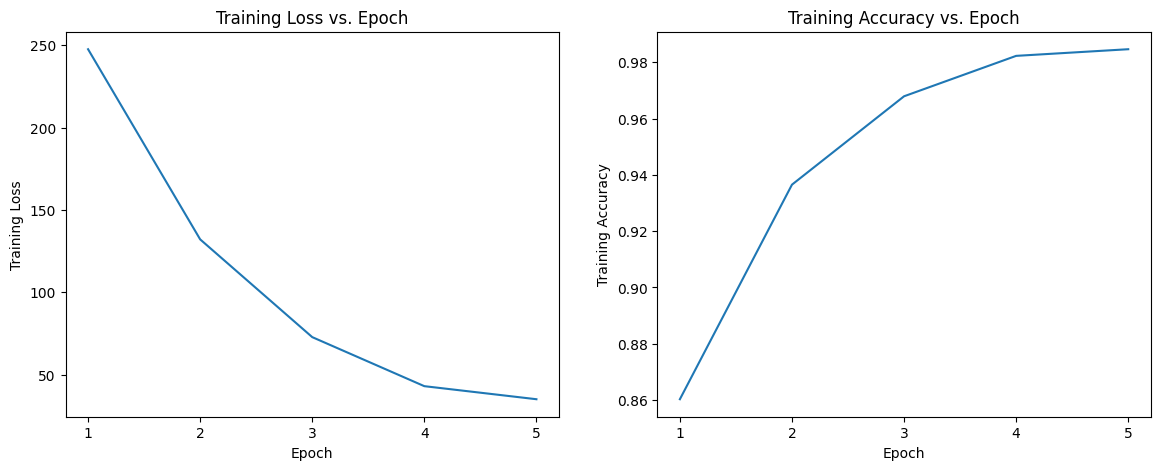

In [6]:
# C1 Results
import matplotlib.pyplot as plt

print("Figure F1: Line plot of training loss and training accuracy vs. epoch (same figure with two y-axes or two subplots).")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(metrics['epoch'], metrics['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss vs. Epoch')
ax1.set_xticks(metrics['epoch'])

ax2.plot(metrics['epoch'], metrics['train_acc'], label='Train Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Accuracy')
ax2.set_title('Training Accuracy vs. Epoch')
ax2.set_xticks(metrics['epoch'])

plt.show()


# W & B Link: https://wandb.ai/pkh2120-columbia-university/hpml_hw2/runs/vkdlfjyf?nw=nwuserpkh2120
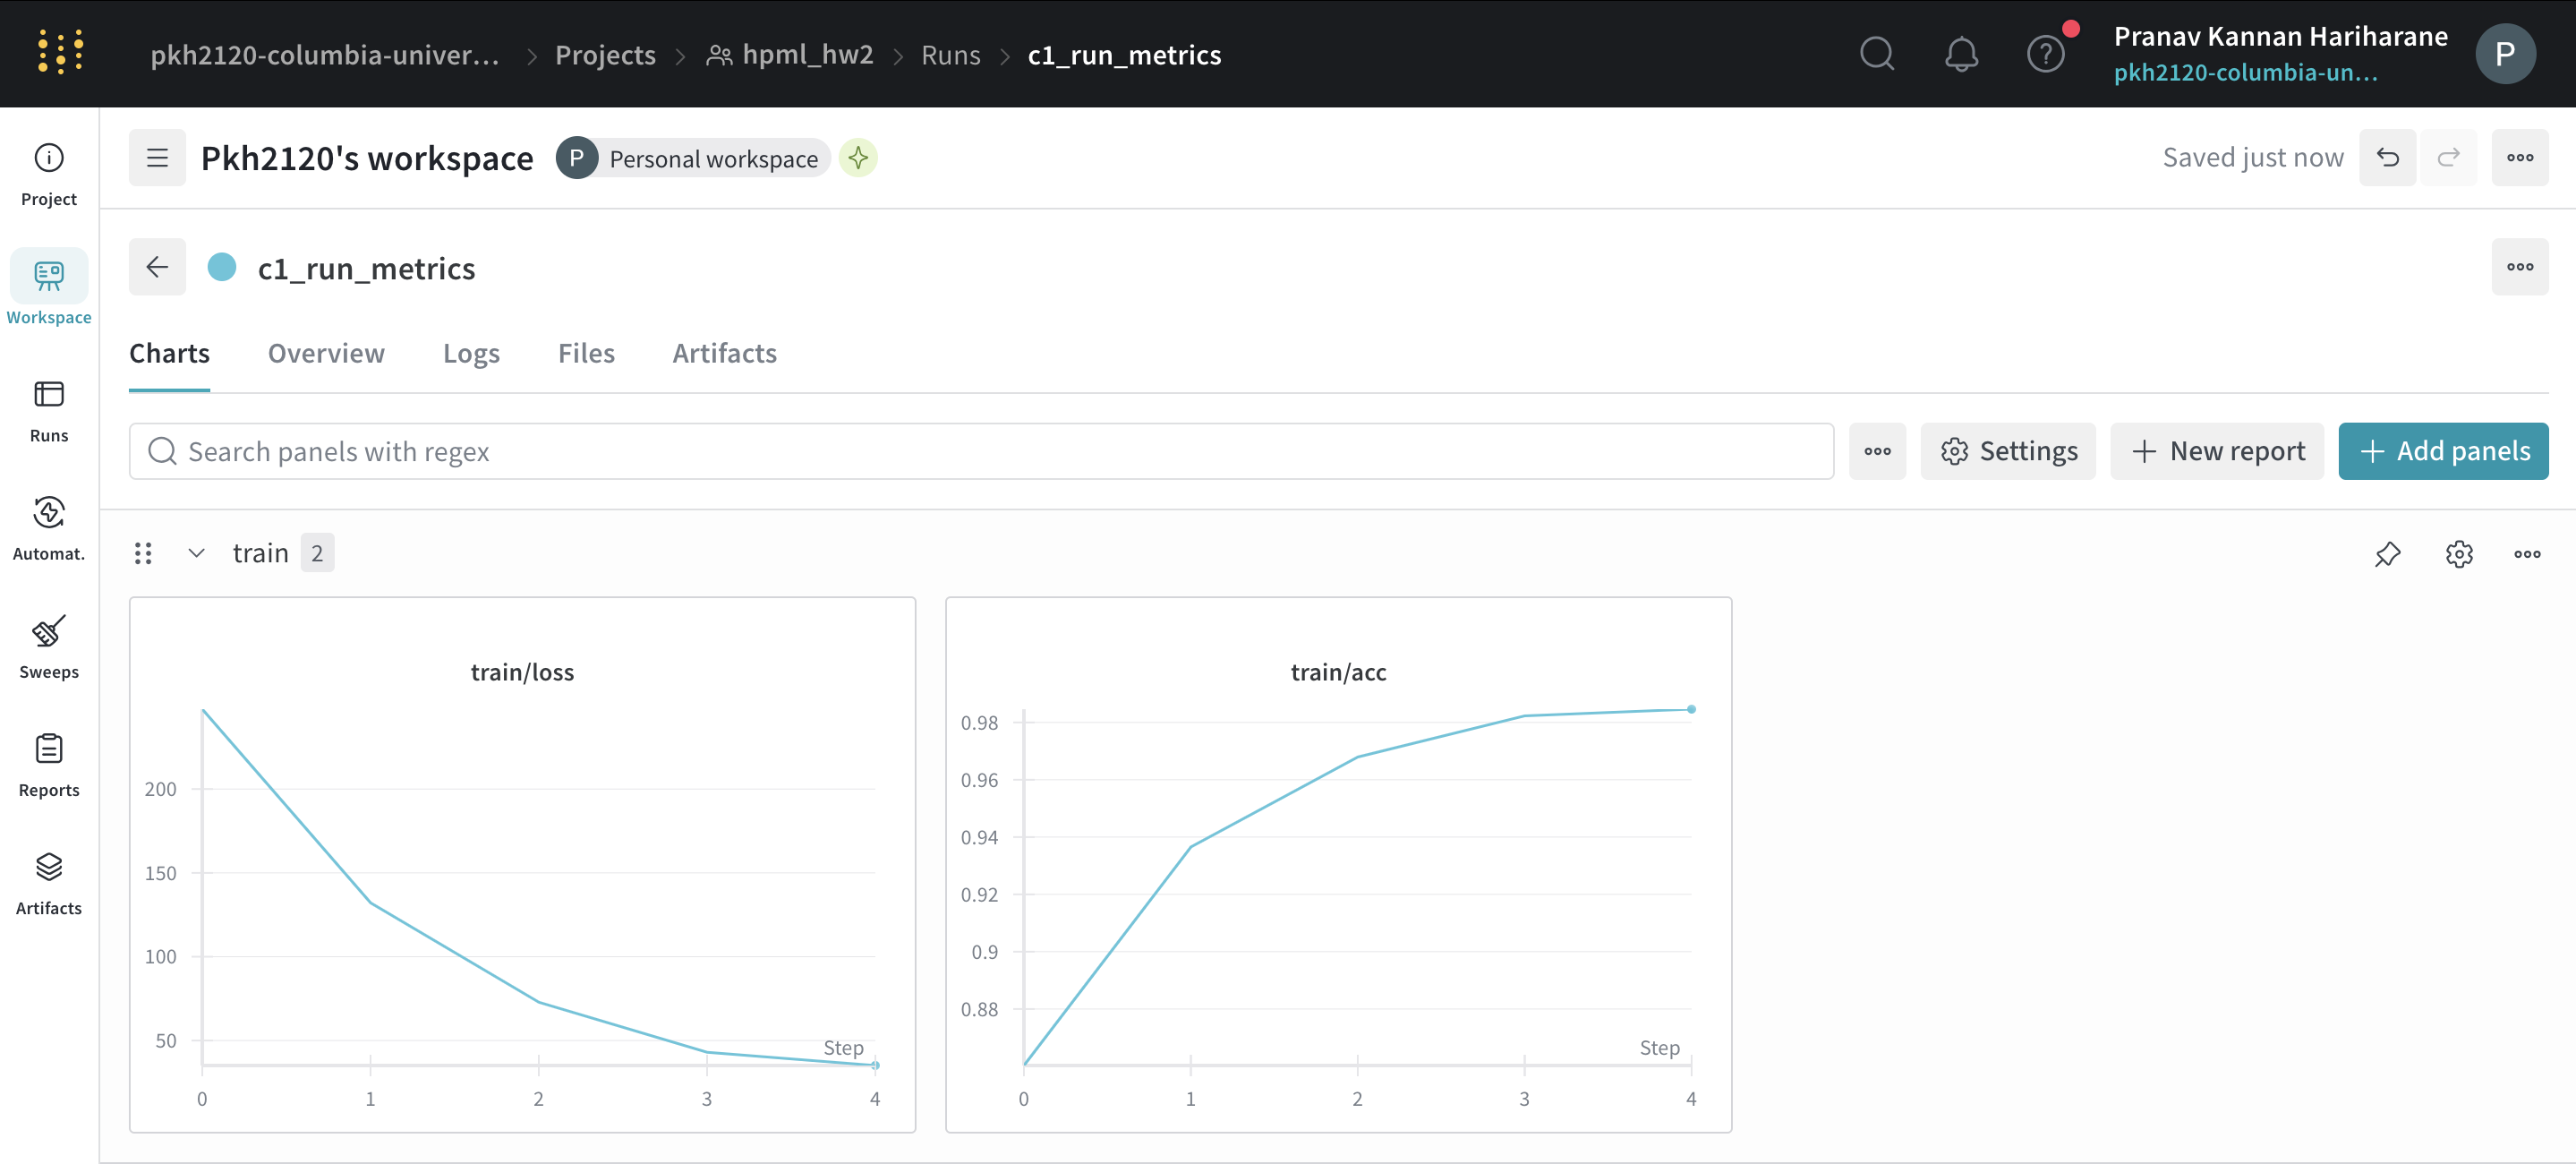
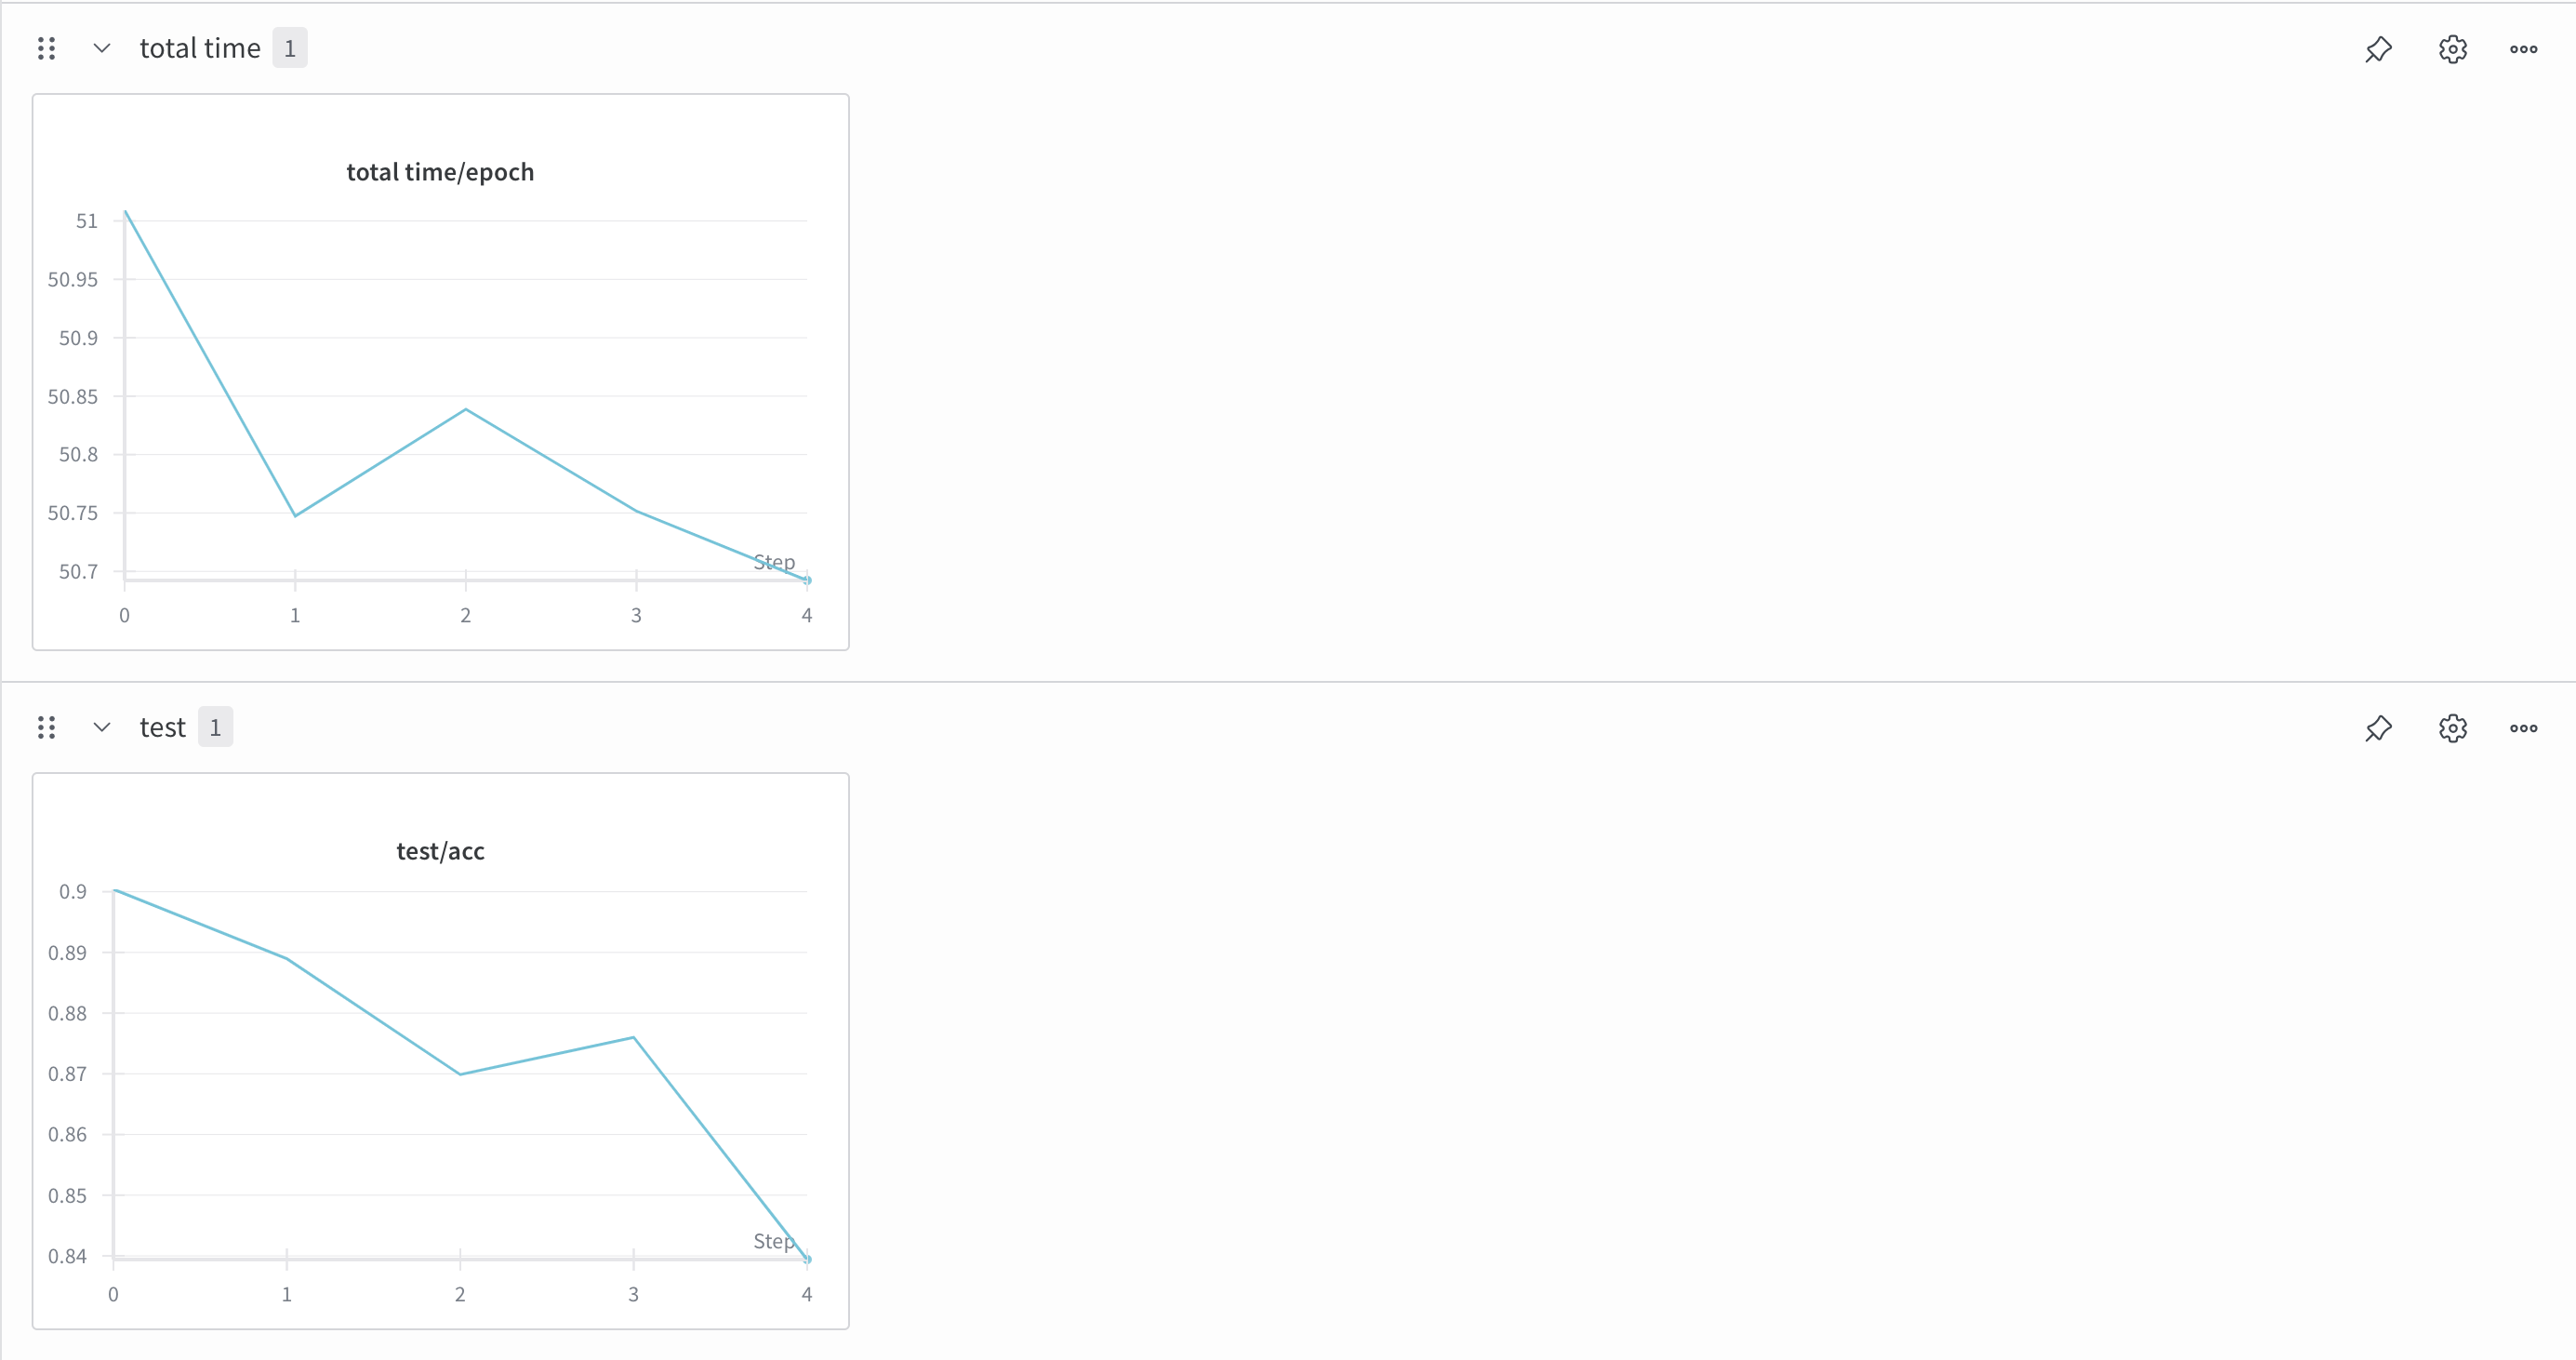
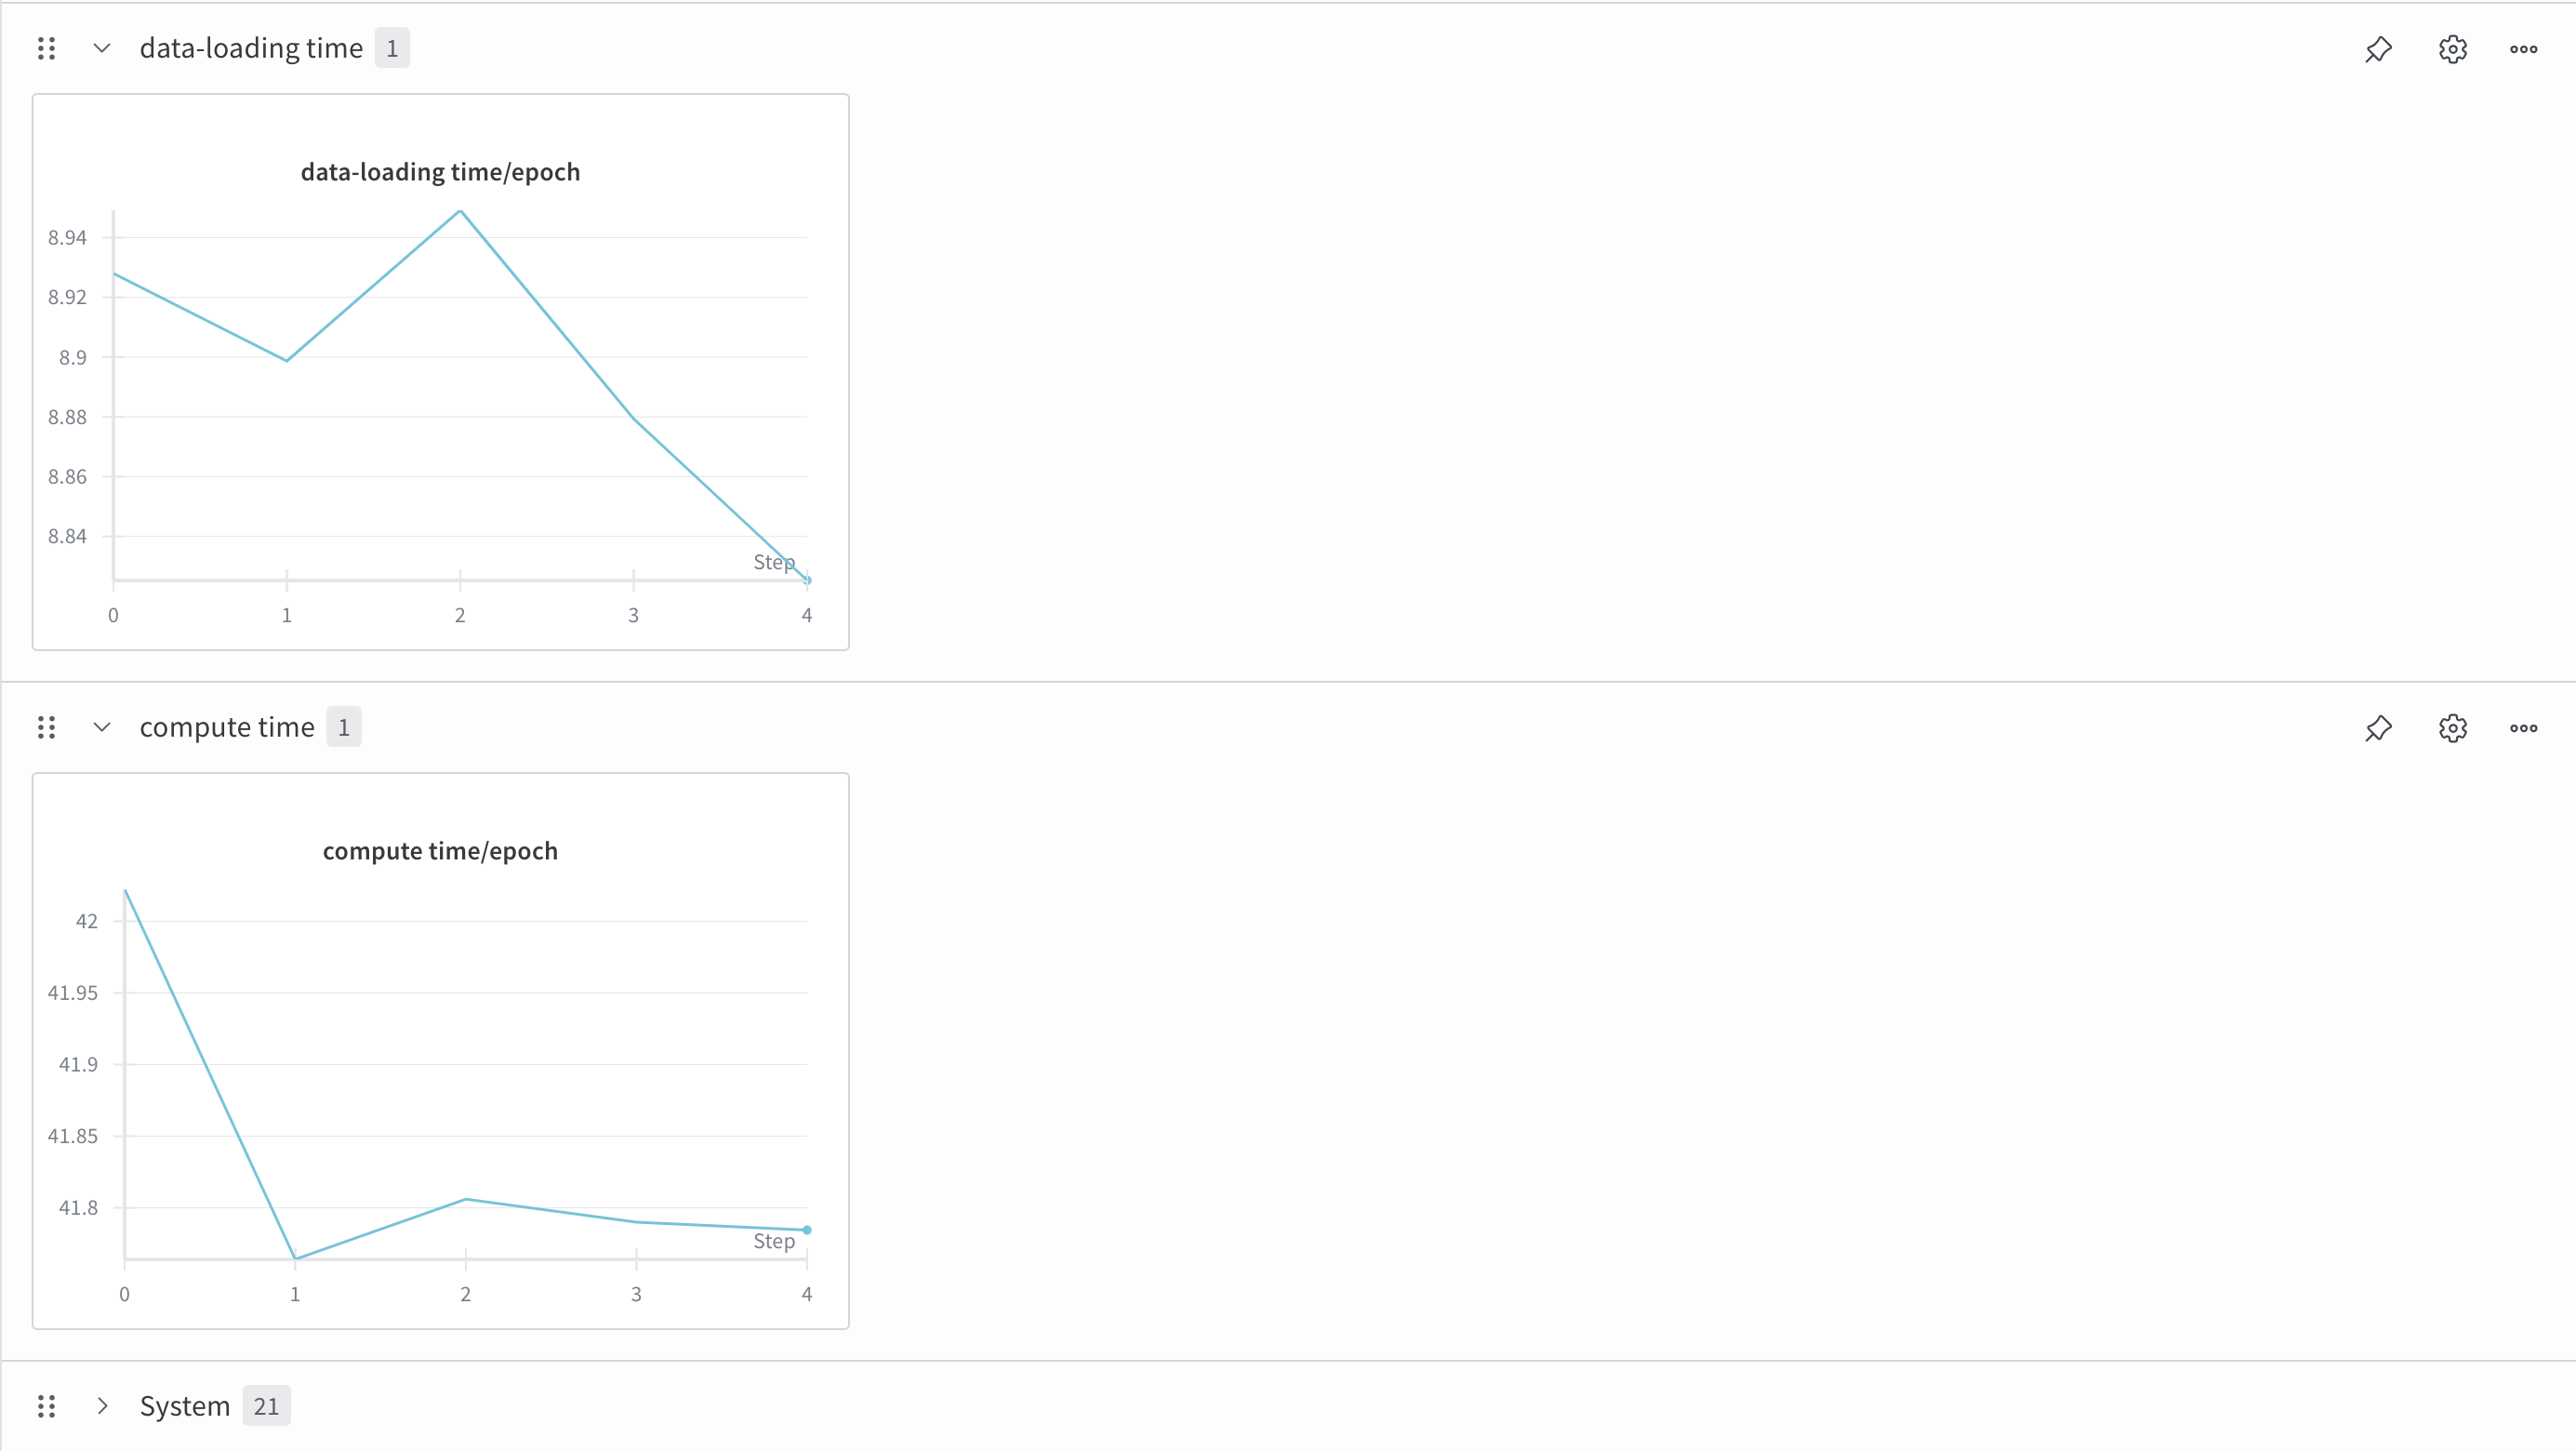

In [45]:
# C2 Results
"""
Got these values from the Weights & Biases (W&B) experiment tracking page for the 'c1_run_metrics' run.
"""
column_names = ['Epoch', 'Data Time(s)', 'Compute Time(s)', 'Total(s)', 'Device']
df_time_metrics = pd.DataFrame(columns=column_names)
df_time_metrics.loc[len(df_time_metrics)] = [1, 8.927993535995483, 42.02236819267273, 51.009148836135864, configs['device']]
df_time_metrics.loc[len(df_time_metrics)] = [2, 8.898666620254517, 41.76403832435608, 50.74735188484192, configs['device']]
df_time_metrics.loc[len(df_time_metrics)] = [3, 8.949174404144287, 41.80608916282654, 50.83868384361267, configs['device']]
df_time_metrics.loc[len(df_time_metrics)] = [4, 8.879297733306885, 41.7899866104126, 50.7515869140625, configs['device']]
df_time_metrics.loc[len(df_time_metrics)] = [5, 8.825263977050781, 41.78449892997742, 50.69222593307495, configs['device']]

print("Table T2: Per-epoch metrics:")
print(df_time_metrics)

Table T2: Per-epoch metrics:
   Epoch  Data Time(s)  Compute Time(s)   Total(s) Device
0      1      8.927994        42.022368  51.009149   cuda
1      2      8.898667        41.764038  50.747352   cuda
2      3      8.949174        41.806089  50.838684   cuda
3      4      8.879298        41.789987  50.751587   cuda
4      5      8.825264        41.784499  50.692226   cuda


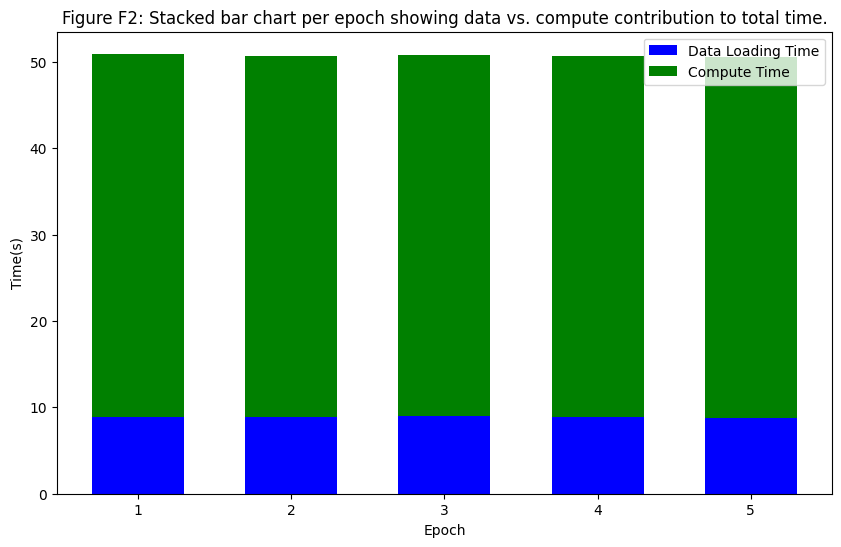

In [46]:
# C2 Results
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6

epochs = df_time_metrics['Epoch']
data_time = df_time_metrics['Data Time(s)']
compute_time = df_time_metrics['Compute Time(s)']
x_pos = np.arange(len(epochs))

bars1 = ax.bar(x_pos, data_time, bar_width, label='Data Loading Time', color='blue')
bars2 = ax.bar(x_pos, compute_time, bar_width, bottom=data_time, 
               label='Compute Time', color='green')

ax.set_xlabel('Epoch')
ax.set_ylabel('Time(s)')

ax.set_title('Figure F2: Stacked bar chart per epoch showing data vs. compute contribution to total time.')
ax.set_xticks(x_pos)
ax.set_xticklabels(epochs)
ax.legend()
plt.show()

In [9]:
# C3 DataLoader Performance
wandb.init(project="hpml_hw2", name="c3_run_metrics")
num_workers_list = [0, 2, 4, 8]
configs = {
    'model_name': "distilbert-base-uncased",
    'max_len': 256,
    'batch_size': 32,
    "learning_rate": 1e-4,
    "optimizer": "AdamW", 
    "num_workers": 1,
    "epochs": 5, 
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    "compile_mode": False
}
metrics = {
    'num_workers': [],
    'avg_epoch_time': [],
    'avg_data_time': [],
    'batch_size': []
}
for num_workers in num_workers_list:
    configs['num_workers'] = num_workers
    model = DistilBertForSequenceClassification.from_pretrained(
        configs['model_name']
    )
    model.to(configs['device'])
    optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])

    train_dataloader = DataLoader(
        tokenized_datasets['train'],
        batch_size=configs['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=configs['num_workers']
    )
    test_dataloader = DataLoader(
        tokenized_datasets['test'],
        batch_size=configs['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=configs['num_workers']
    )
    wandb.config.update(configs)
    total_epoch_time = 0
    total_data_time = 0
    for epoch in range(1, configs['epochs'] + 1):
        epoch_start = time.time()
        train_loss, train_acc, data_loading_time, compute_time = train_epoch(
            model, train_dataloader, optimizer, configs['device']
        )
        epoch_end = time.time()
        test_acc = test(model, test_dataloader, configs['device'])
        total_time = epoch_end - epoch_start

        total_epoch_time += total_time
        total_data_time += data_loading_time

        wandb.log({"train/loss": train_loss, "train/acc": train_acc, "test/acc": test_acc, "data-loading time/epoch": data_loading_time, "compute time/epoch": compute_time, "total time/epoch": total_time})
    metrics['num_workers'].append(configs['num_workers'])
    metrics['avg_epoch_time'].append(total_epoch_time / configs['epochs'])
    metrics['avg_data_time'].append(total_data_time / configs['epochs'])
    metrics['batch_size'].append(configs['batch_size'])
    del model, optimizer, train_dataloader, test_dataloader
    torch.cuda.empty_cache()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-strea

In [10]:
# C3 Results
df_metrics = pd.DataFrame(metrics)
df_metrics.columns = ['num_workers', 'Avg Epoch Time(s)', 'Avg Data Time(s)', 'Batch Size']
print("Table T3:")
print(df_metrics)
wandb.log({"table_t3": df_metrics})

Table T3:
   num_workers  Avg Epoch Time(s)  Avg Data Time(s)  Batch Size
0            0          48.245205          6.480375          32
1            2          50.882174          8.994037          32
2            4          50.989092          9.063033          32
3            8          51.069614          9.162274          32


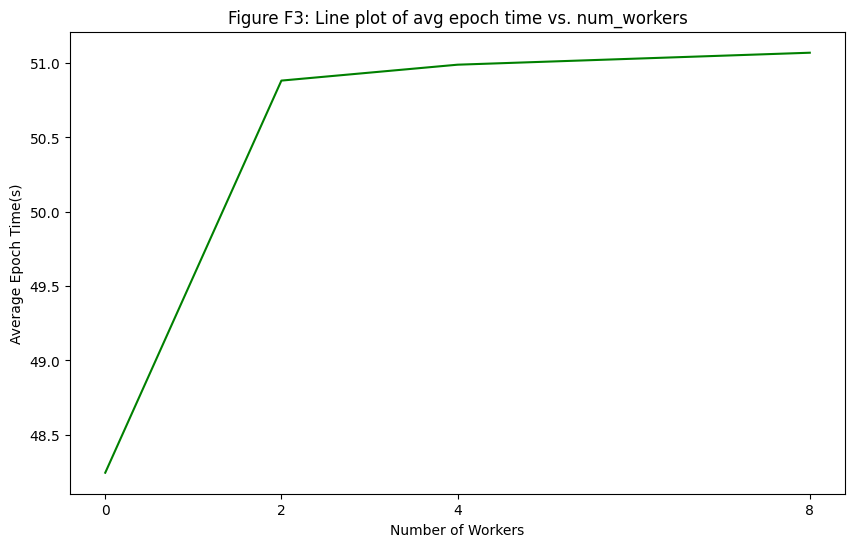

In [11]:
# C3 Results
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(metrics['num_workers'], metrics['avg_epoch_time'], color='green')
ax.set_xlabel('Number of Workers')
ax.set_ylabel('Average Epoch Time(s)')
ax.set_title('Figure F3: Line plot of avg epoch time vs. num_workers')
ax.set_xticks(num_workers_list)
plt.show()

In [12]:
# C3 Results 
#One-sentence conclusion: Which num_workers is optimal and why
"""
Setting num_workers to zero ended up being the most optimal configuration as seen in the results, most likely because the IMDB dataset wasn't large enough or loaded quickly from the cache which caused the multiprocessing overhead to exceed its benefits.
"""

"\nSetting num_workers to zero ended up being the most optimal configuration as seen in the results, most likely because the IMDB dataset wasn't large enough or loaded quickly from the cache which caused the multiprocessing overhead to exceed its benefits.\n"

# W & B Link: https://wandb.ai/pkh2120-columbia-university/hpml_hw2/runs/mgbryfod?nw=nwuserpkh2120
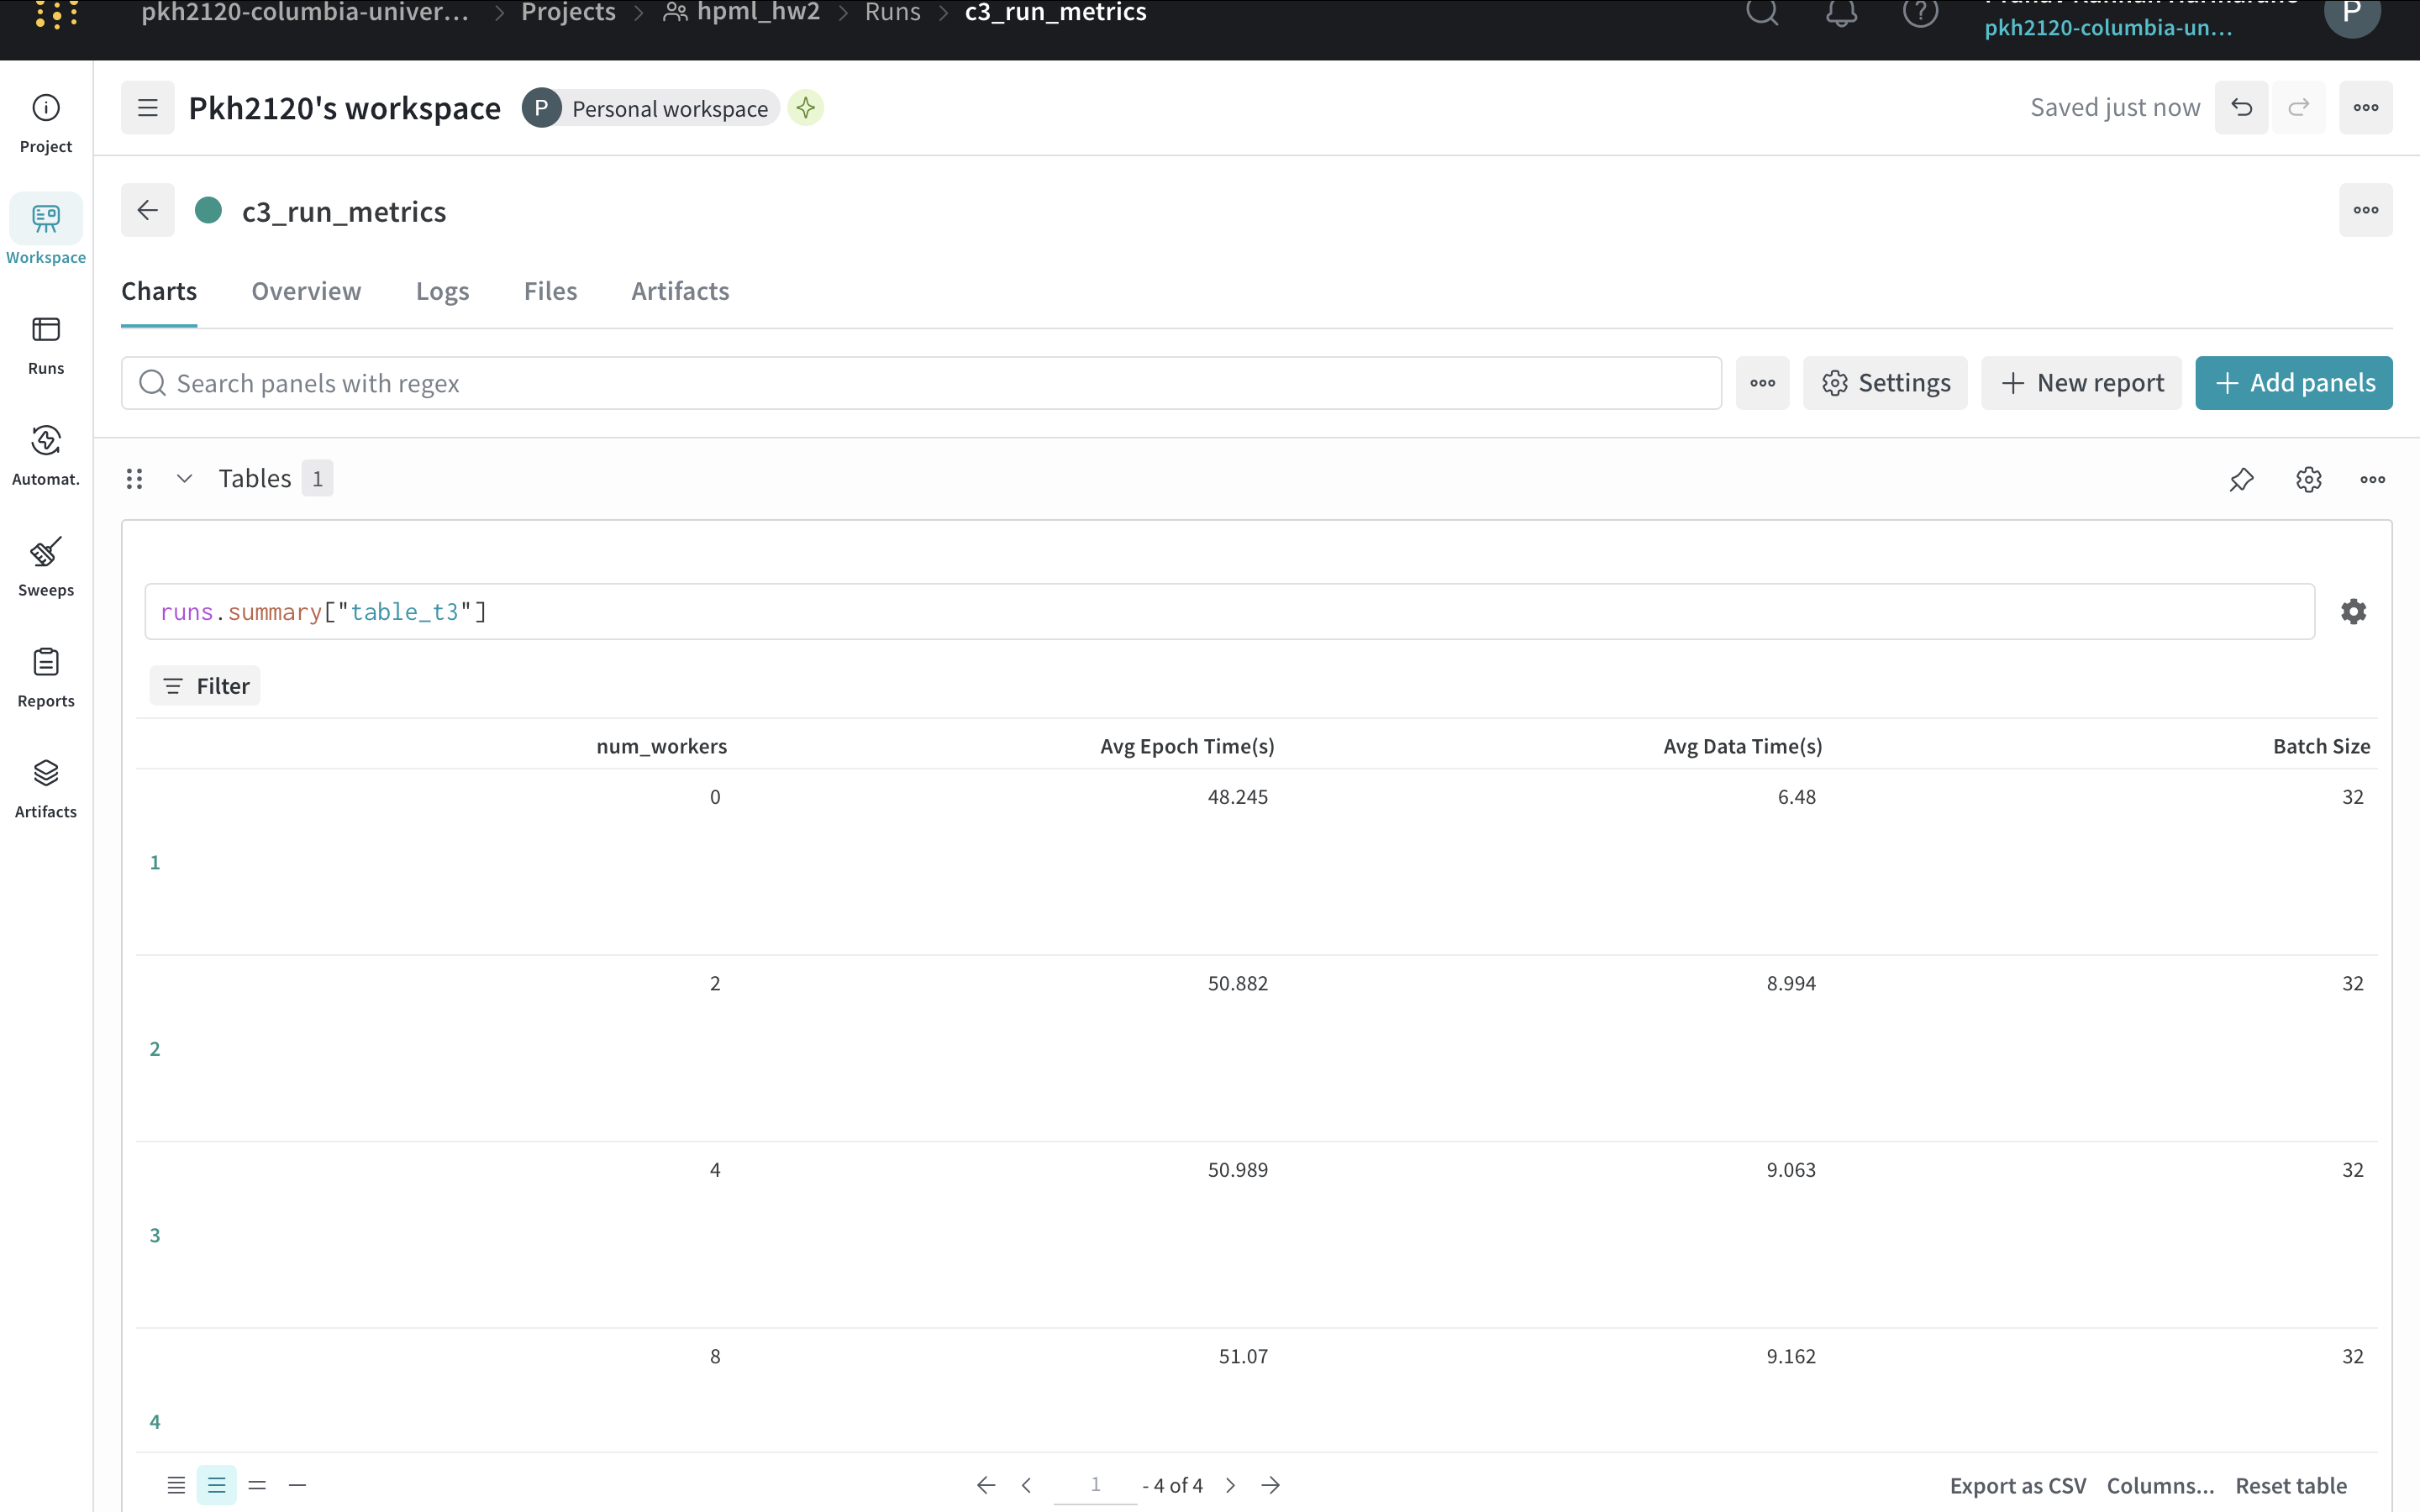
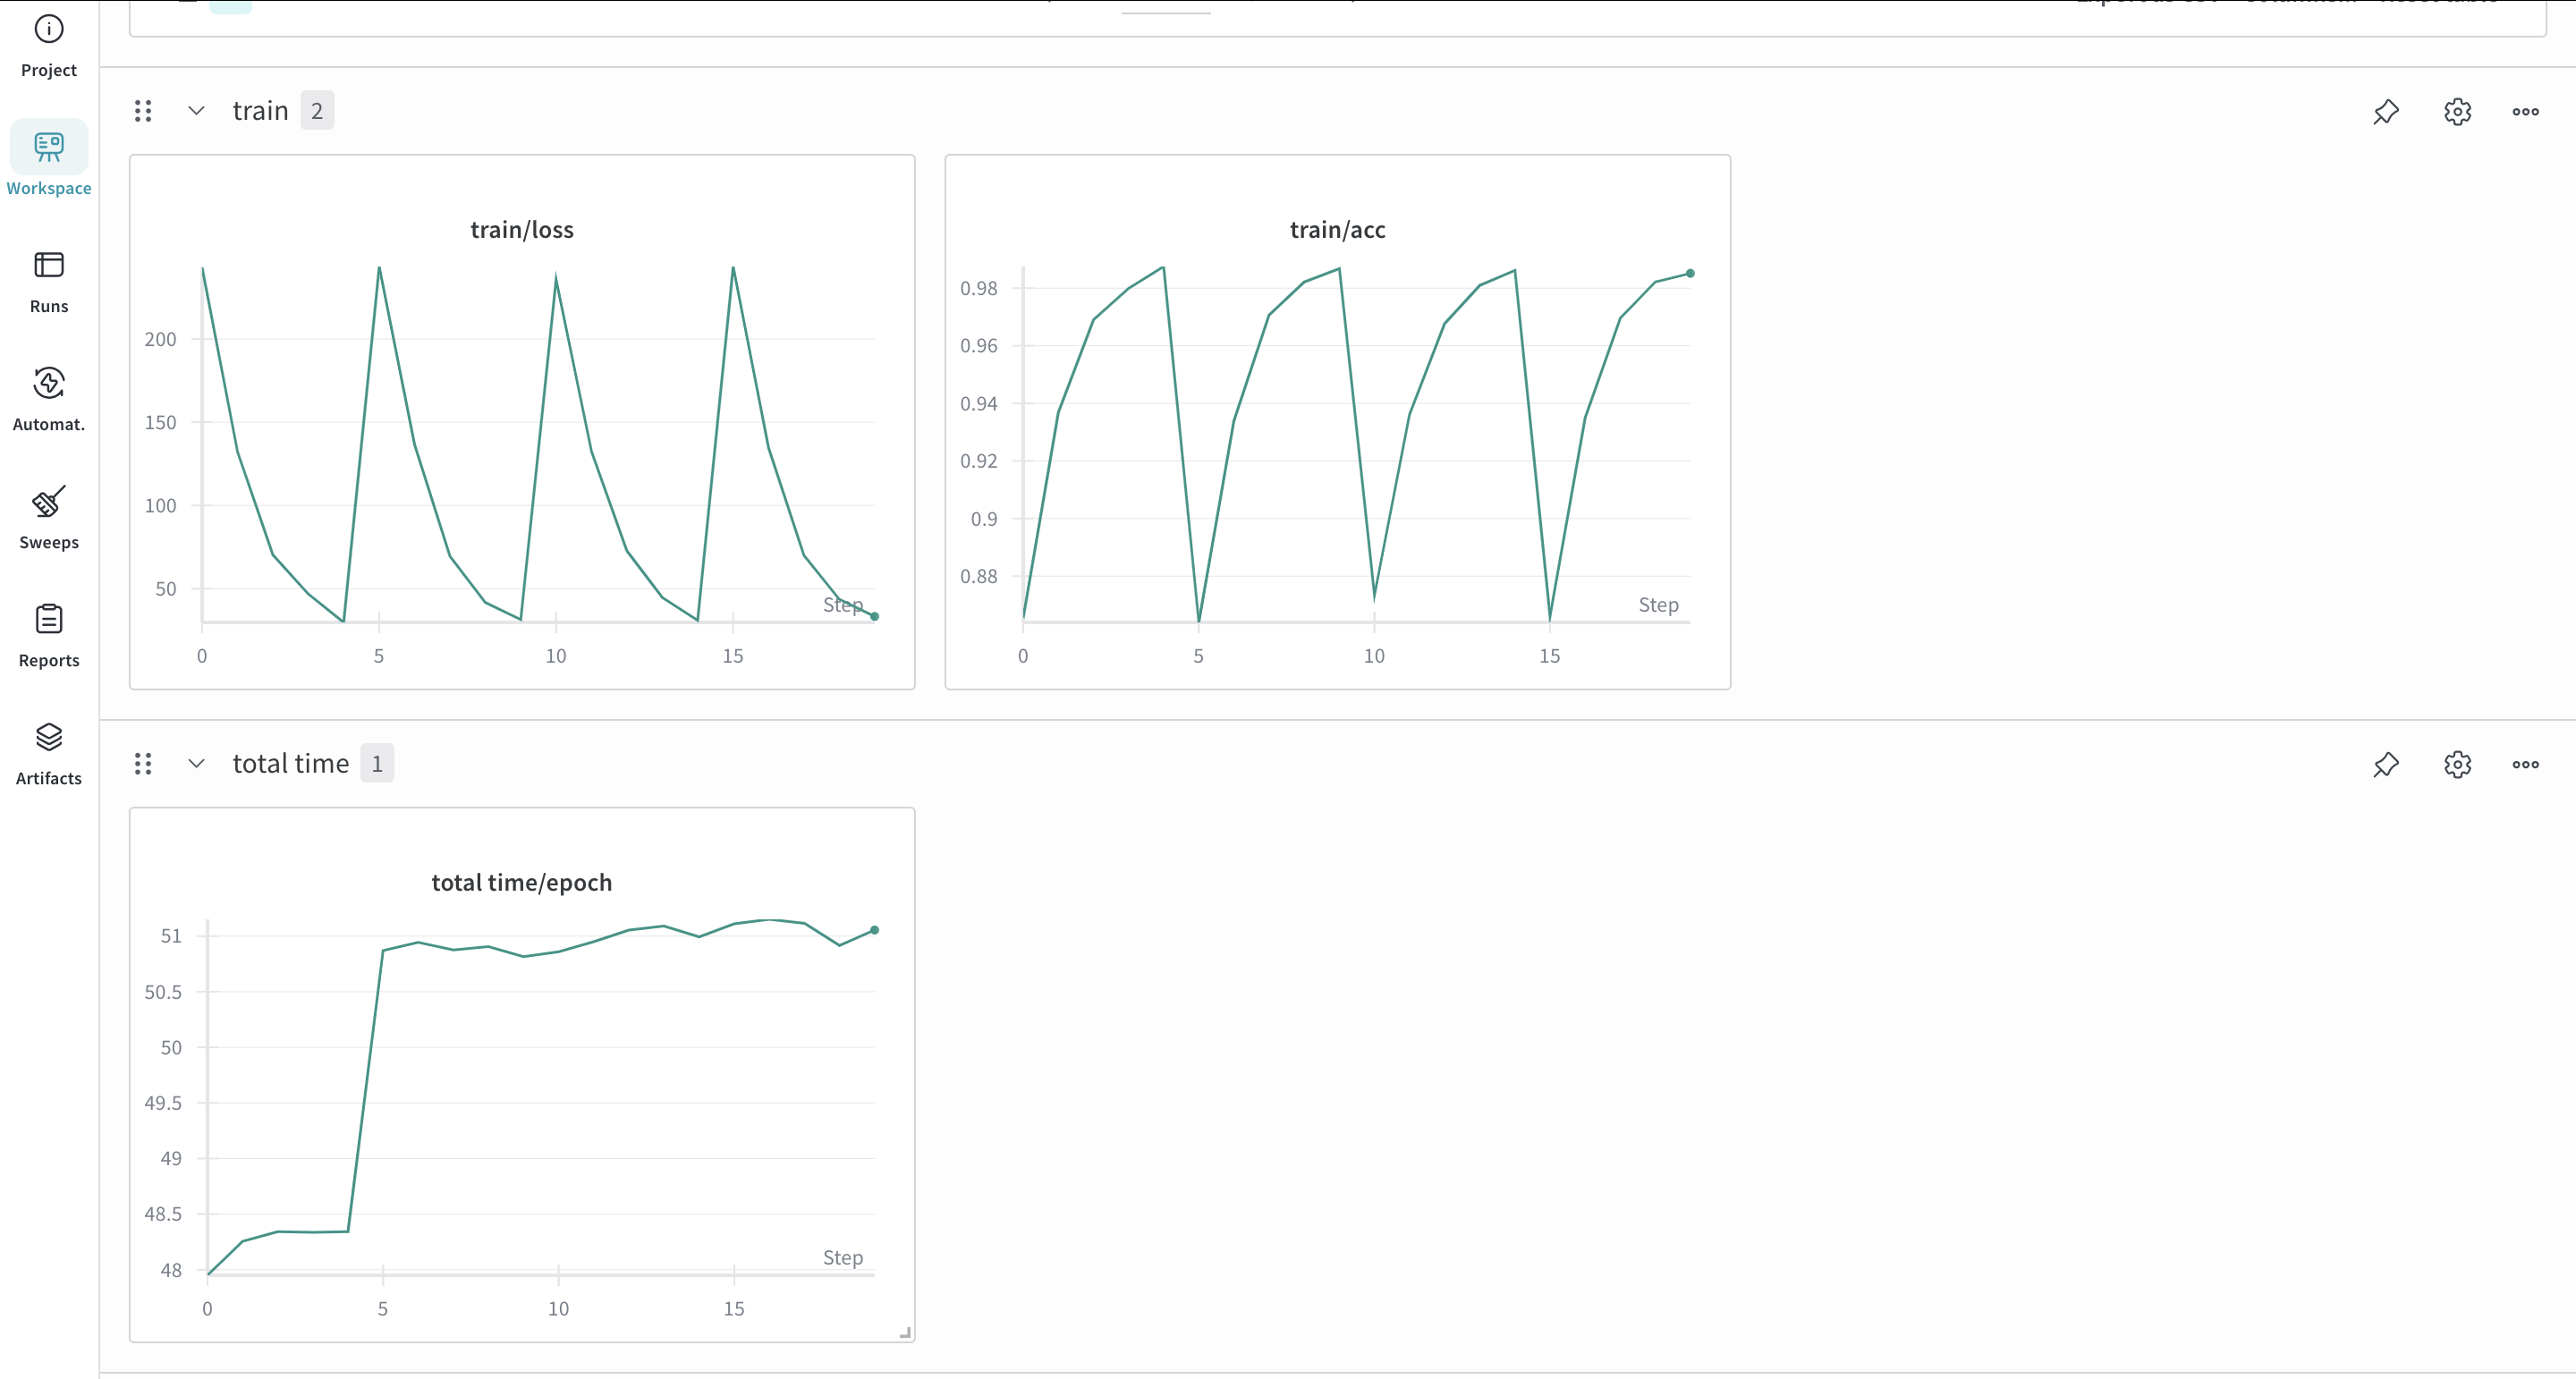
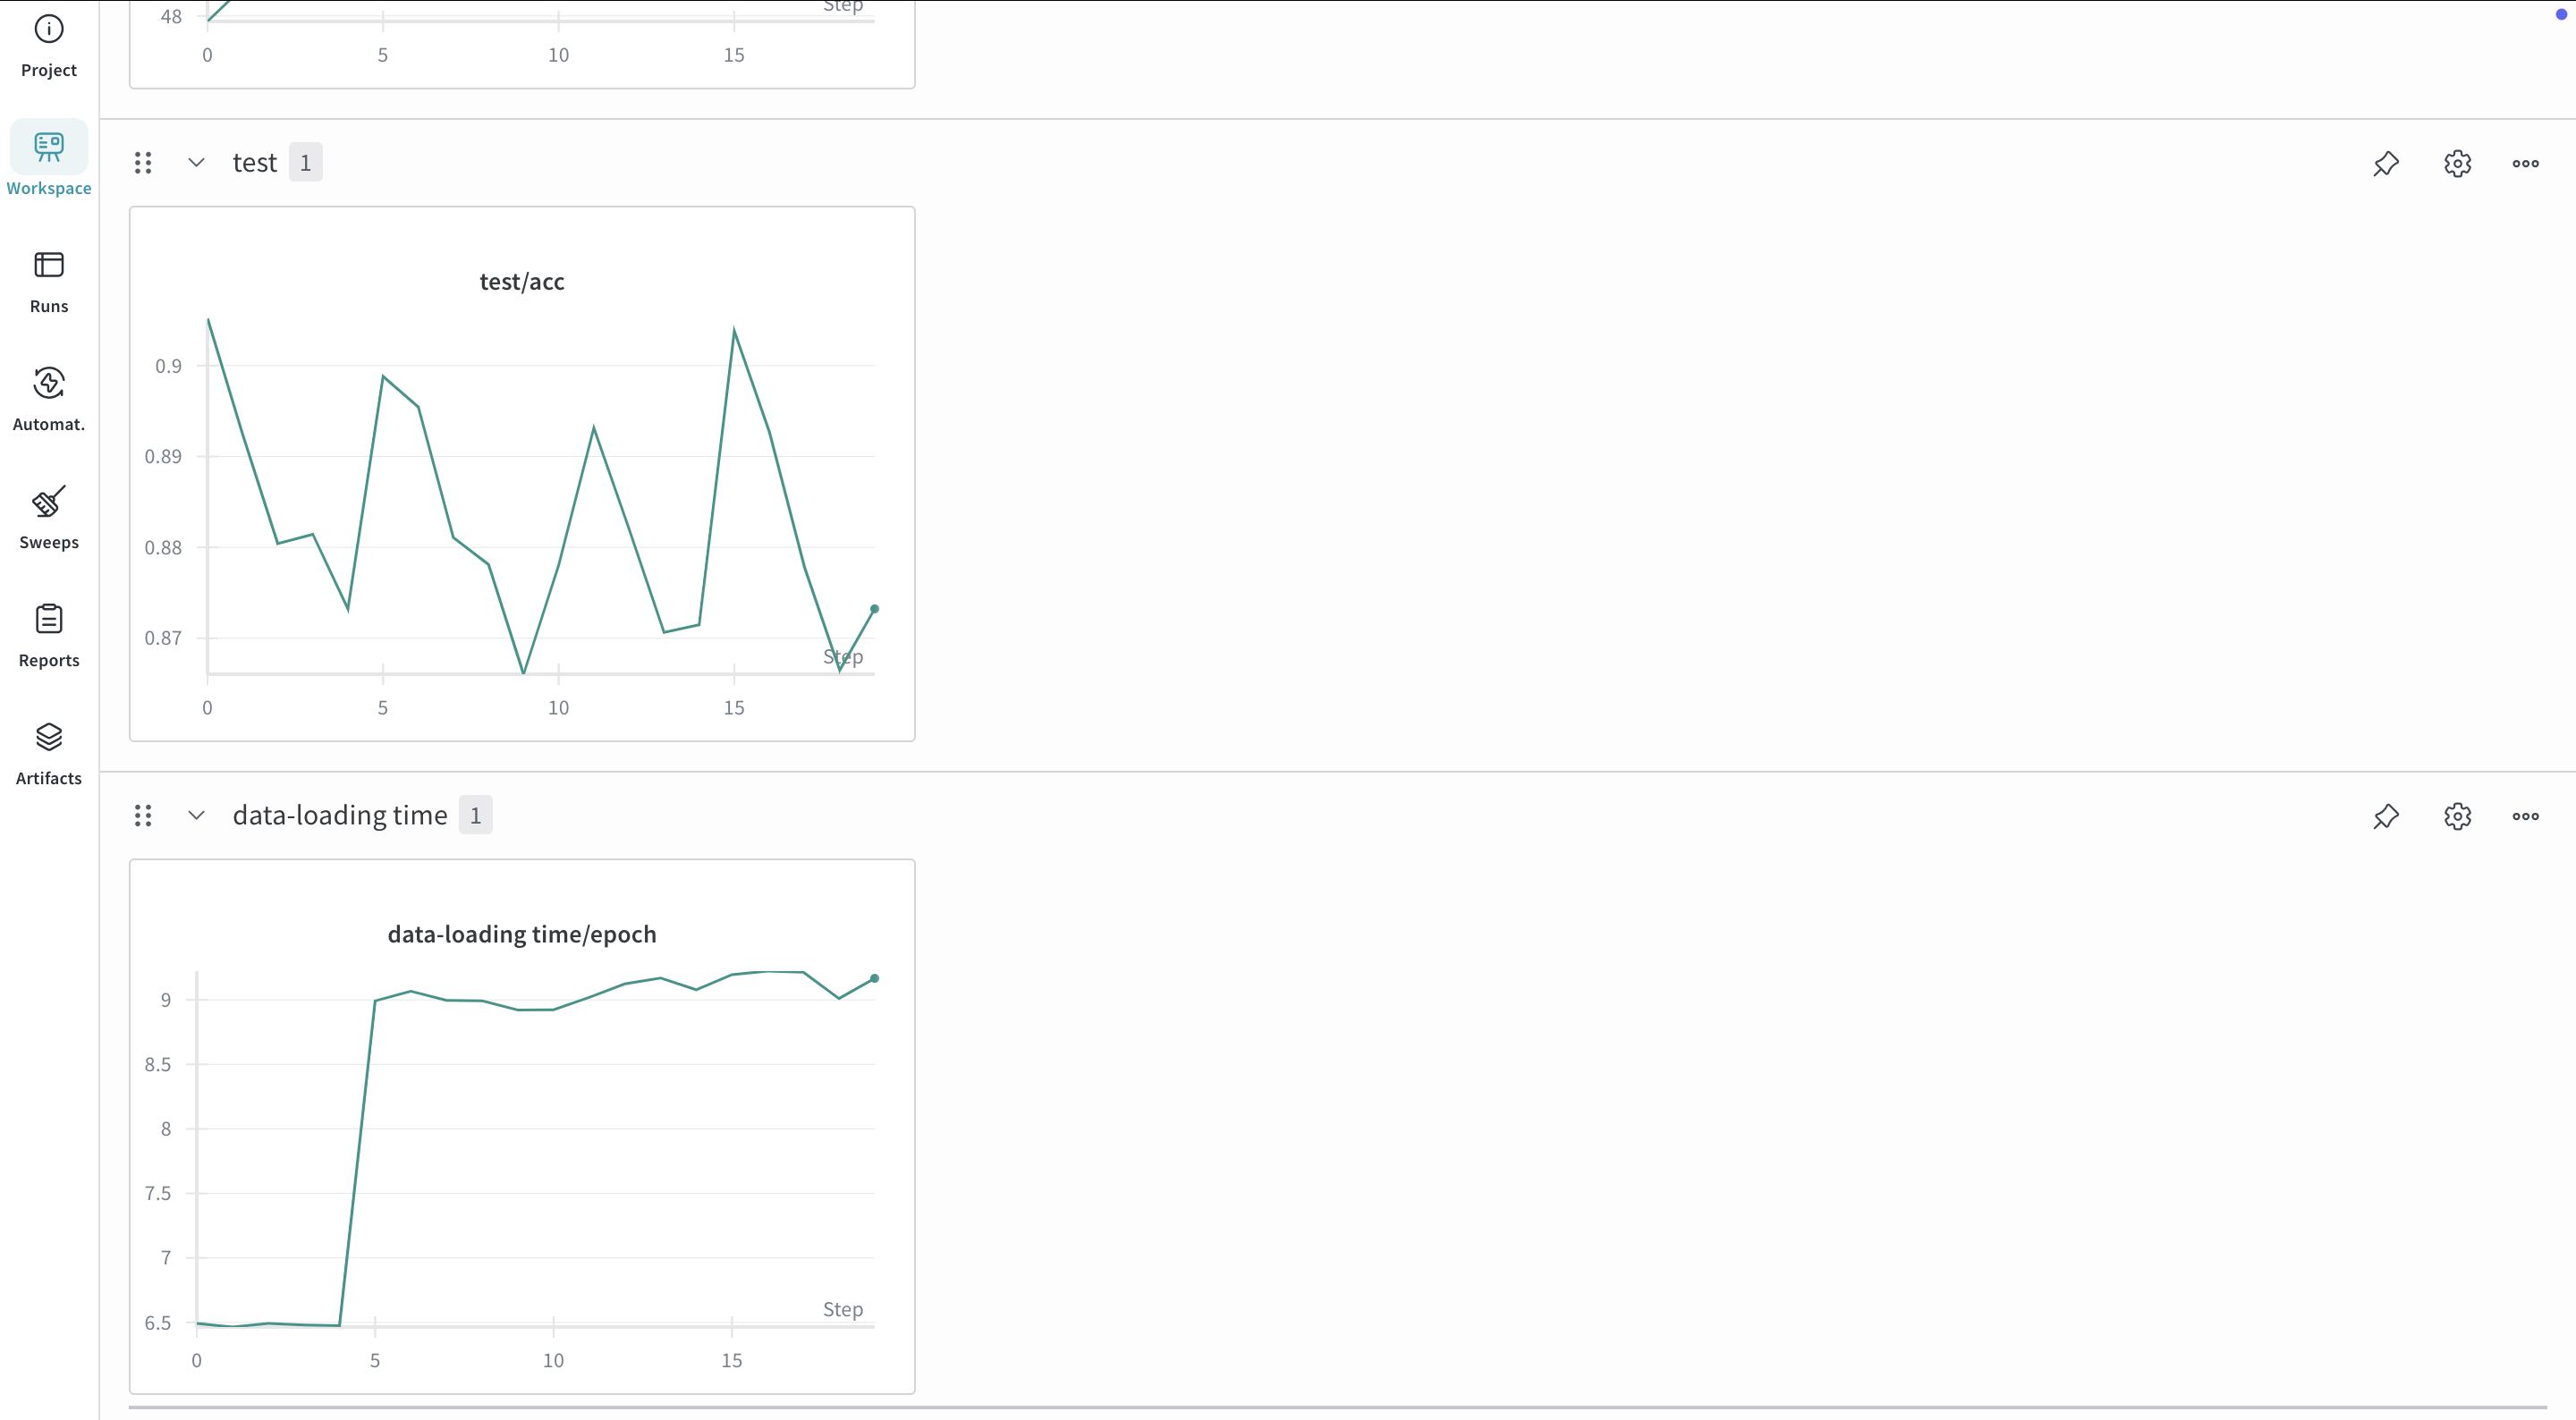
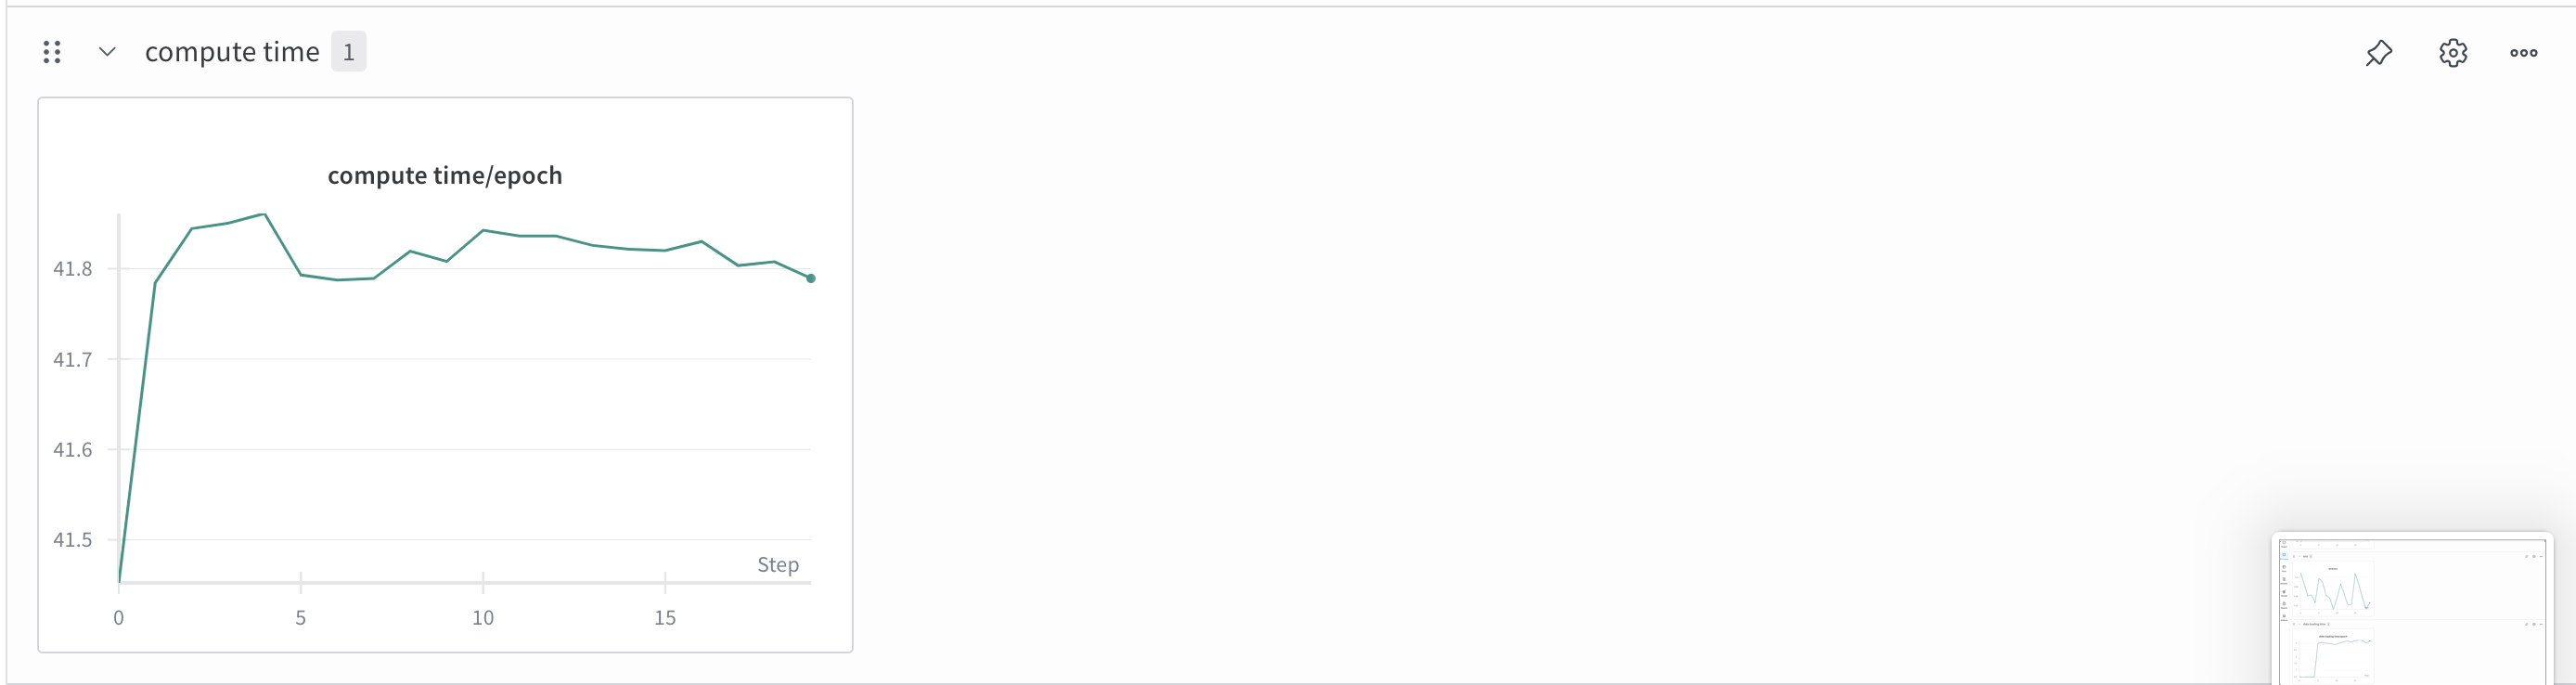

In [13]:
# C4 PyTorch Profiler
from torch.profiler import profile, record_function, ProfilerActivity

configs = {
    'model_name': "distilbert-base-uncased",
    'max_len': 256,
    'batch_size': 32,
    "learning_rate": 1e-4,
    "optimizer": "AdamW", 
    "num_workers": 1,
    "epochs": 5, 
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    "compile_mode": False
}

def train_test_with_profiler(model, train_dataloader, test_dataloader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    activities = [ProfilerActivity.CPU]
    if device == 'cuda':
        activities.append(ProfilerActivity.CUDA)

    for i in range(1, configs['epochs'] + 1):
        with profile(
            activities=activities,
            record_shapes=True,
            profile_memory=False,
            with_stack=False,
            with_flops=False,
        ) as prof:
            for i, batch in enumerate(train_dataloader):
                input_ids = None
                attention_mask = None
                labels = None
                with record_function("data_loading"):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = torch.tensor(batch['labels']).to(device)

                outputs = None
                with record_function("forward"):
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )
        
                loss = outputs.loss
                logits = outputs.logits

                with record_function("backward"):
                    optimizer.zero_grad()
                    loss.backward()

                predictions = torch.argmax(logits, dim=-1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
                total_loss += loss.item() 

                with record_function("optimizer"):
                    optimizer.step()

                prof.step()

            train_acc = correct / total
            
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i, batch in enumerate(test_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = torch.tensor(batch['labels']).to(device)
            
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
            
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)
            
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
    
        test_acc = correct / total 
        data_loading_time, forward_time, backward_time, optimizer_time, total_time, _, _, _, _ = profiler_results(prof)
        wandb.log({"train/loss": total_loss, "train/acc": train_acc, "test/acc": test_acc, "data-loading time/epoch": data_loading_time, "compute time/epoch": forward_time + backward_time + optimizer_time, "total time/epoch": total_time})
    return prof

def profiler_results(prof):
    key_averages = prof.key_averages()
    
    data_loading_time = 0
    forward_time = 0
    backward_time = 0
    optimizer_time = 0
    total_time = 0
    
    for event in key_averages:
        if 'data_loading' in event.key:
            data_loading_time += event.self_cpu_time_total
            if configs['device'] == 'cuda' and hasattr(event, 'self_cuda_time_total'):
                data_loading_time += getattr(event, 'self_cuda_time_total', 0)
        elif 'forward' in event.key:
            forward_time += event.self_cpu_time_total
            if configs['device'] == 'cuda' and hasattr(event, 'self_cuda_time_total'):
                forward_time += getattr(event, 'self_cuda_time_total', 0)
        elif 'backward' in event.key:
            backward_time += event.self_cpu_time_total
            if configs['device'] == 'cuda' and hasattr(event, 'self_cuda_time_total'):
                backward_time += getattr(event, 'self_cuda_time_total', 0)
        elif 'optimizer' in event.key:
            optimizer_time += event.self_cpu_time_total
            if configs['device'] == 'cuda' and hasattr(event, 'self_cuda_time_total'):
                optimizer_time += getattr(event, 'self_cuda_time_total', 0)
    
    total_time = data_loading_time + forward_time + backward_time + optimizer_time
    
    data_loading_time = data_loading_time / 1e6
    forward_time = forward_time / 1e6
    backward_time = backward_time / 1e6
    optimizer_time = optimizer_time / 1e6
    total_time = total_time / 1e6
    
    data_pct = (data_loading_time / total_time * 100) 
    forward_pct = (forward_time / total_time * 100) 
    backward_pct = (backward_time / total_time * 100) 
    optimizer_pct = (optimizer_time / total_time * 100)
    
    return data_loading_time, forward_time, backward_time, optimizer_time, total_time, data_pct, forward_pct, backward_pct, optimizer_pct

wandb.init(project="hpml_hw2", name="c4_run_metrics_1")
configs["num_workers"] = 1
metrics_nw_1 = {
    "num_workers": configs["num_workers"],
    "data_loading": 0,
    "forward": 0,
    "backward": 0,
    "optimizer": 0
}
model = DistilBertForSequenceClassification.from_pretrained(
    configs['model_name']
)
model.to(configs['device'])
optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])
train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=configs['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=configs['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
wandb.config.update(configs)
prof_1 = train_test_with_profiler(model, train_dataloader, test_dataloader, optimizer, configs['device'])
_, _, _, _, _, data_pct, forward_pct, backward_pct, optimizer_pct = profiler_results(prof_1)
metrics_nw_1["data_loading"] = data_pct
metrics_nw_1["forward"] = forward_pct
metrics_nw_1["backward"] = backward_pct
metrics_nw_1["optimizer"] = optimizer_pct
del model, optimizer, train_dataloader, test_dataloader
torch.cuda.empty_cache()

wandb.init(project="hpml_hw2", name="c4_run_metrics_2")
configs["num_workers"] = 0 
metrics_nw_0 = {
    "num_workers": configs["num_workers"],
    "data_loading": 0,
    "forward": 0,
    "backward": 0,
    "optimizer": 0
}
model = DistilBertForSequenceClassification.from_pretrained(
    configs['model_name']
)
model.to(configs['device'])
optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])
train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=configs['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=configs['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
wandb.config.update(configs)
prof_0 = train_test_with_profiler(model, train_dataloader, test_dataloader, optimizer, configs['device'])
_, _, _, _, _, data_pct, forward_pct, backward_pct, optimizer_pct = profiler_results(prof_0)
metrics_nw_0["data_loading"] = data_pct
metrics_nw_0["forward"] = forward_pct
metrics_nw_0["backward"] = backward_pct
metrics_nw_0["optimizer"] = optimizer_pct
del model, optimizer, train_dataloader, test_dataloader
torch.cuda.empty_cache()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# C4 Results
df_metrics = pd.DataFrame([metrics_nw_1])
df_metrics.columns = ['num_workers', 'Data (%)', 'Forward (%)', 'Backward (%)', 'Optimizer (%)']
df_metrics.loc[len(df_metrics)] = [metrics_nw_0["num_workers"], metrics_nw_0["data_loading"], metrics_nw_0["forward"], metrics_nw_0["backward"], metrics_nw_0["optimizer"]]
print("Table T4")
print(df_metrics)

Table T4
   num_workers  Data (%)  Forward (%)  Backward (%)  Optimizer (%)
0          1.0  0.632444     9.801247      89.39817        0.16814
1          0.0  0.297883     5.511197      94.10113        0.08979


In [15]:
# C4 Results
print("Figure F4: Screenshot or saved table of top ops by self cpu time total (and GPU if available).")
print("Profiler For Num_Workers = 1")
print(prof_1.key_averages().table(sort_by="self_cpu_time_total", row_limit=20))
if torch.cuda.is_available():
    print(prof_1.key_averages().table(sort_by="self_cuda_time_total", row_limit=20))

print("Profiler For Num_Workers = 0")
print(prof_0.key_averages().table(sort_by="self_cpu_time_total", row_limit=20))
if torch.cuda.is_available():
    print(prof_0.key_averages().table(sort_by="self_cuda_time_total", row_limit=20))

Figure F4: Screenshot or saved table of top ops by self cpu time total (and GPU if available).
Profiler For Num_Workers = 1
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               backward        29.68%       24.598s        30.19%       25.017s      31.991ms       0.000us         0.00%     668.228us       0.855us           782  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        20.38%       16.891s

# W & B Link: https://wandb.ai/pkh2120-columbia-university/hpml_hw2/runs/ryunw3g2?nw=nwuserpkh2120
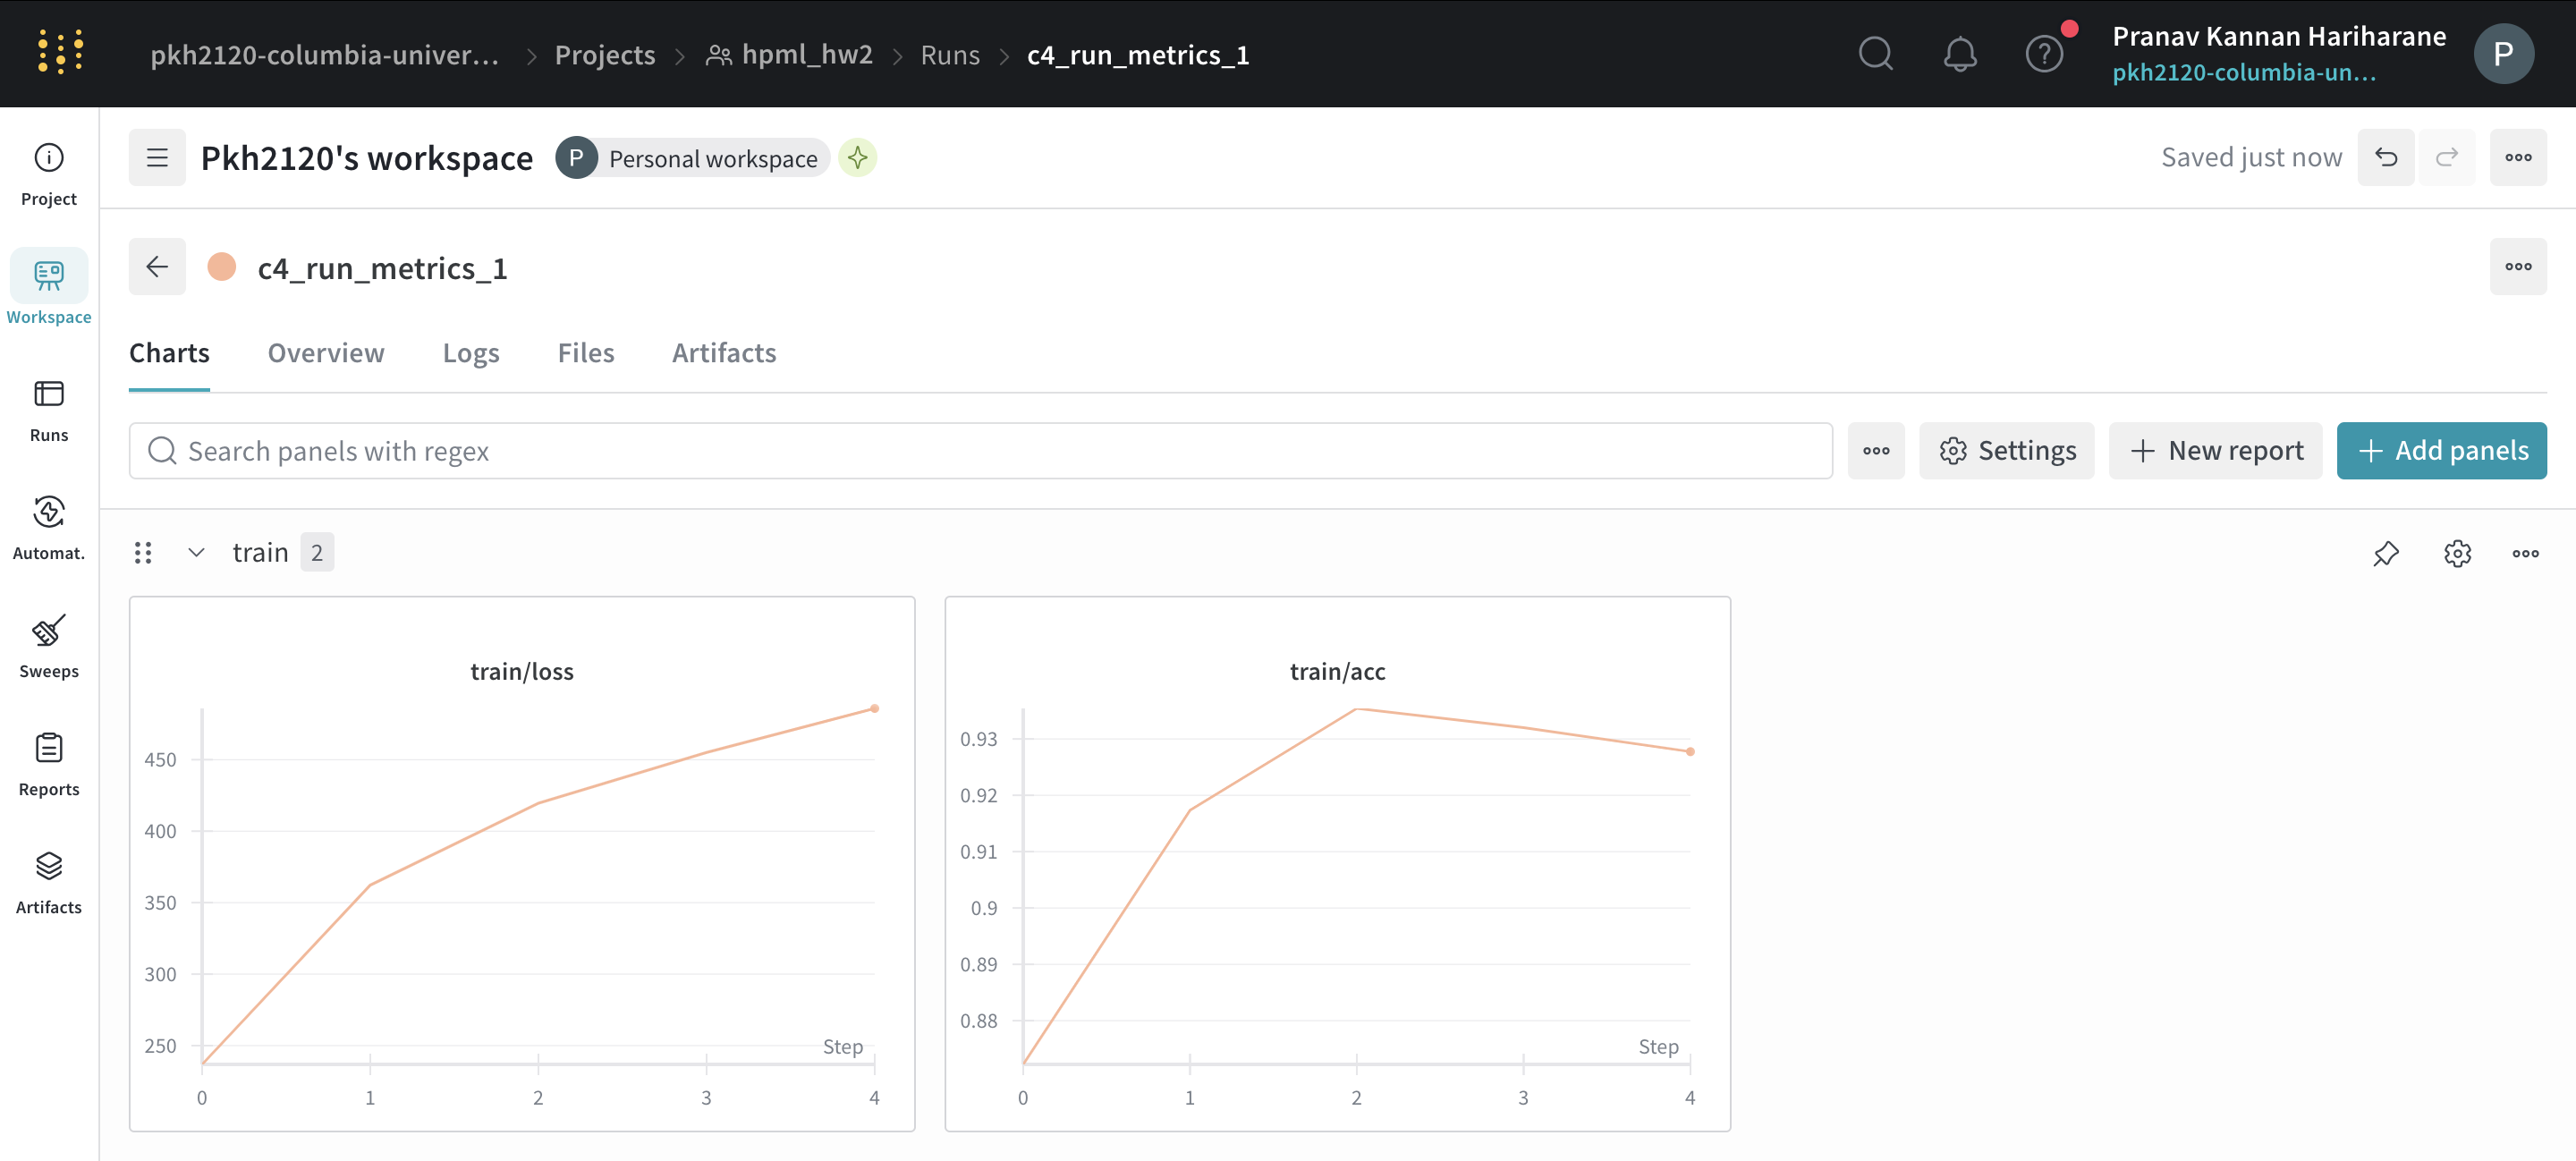
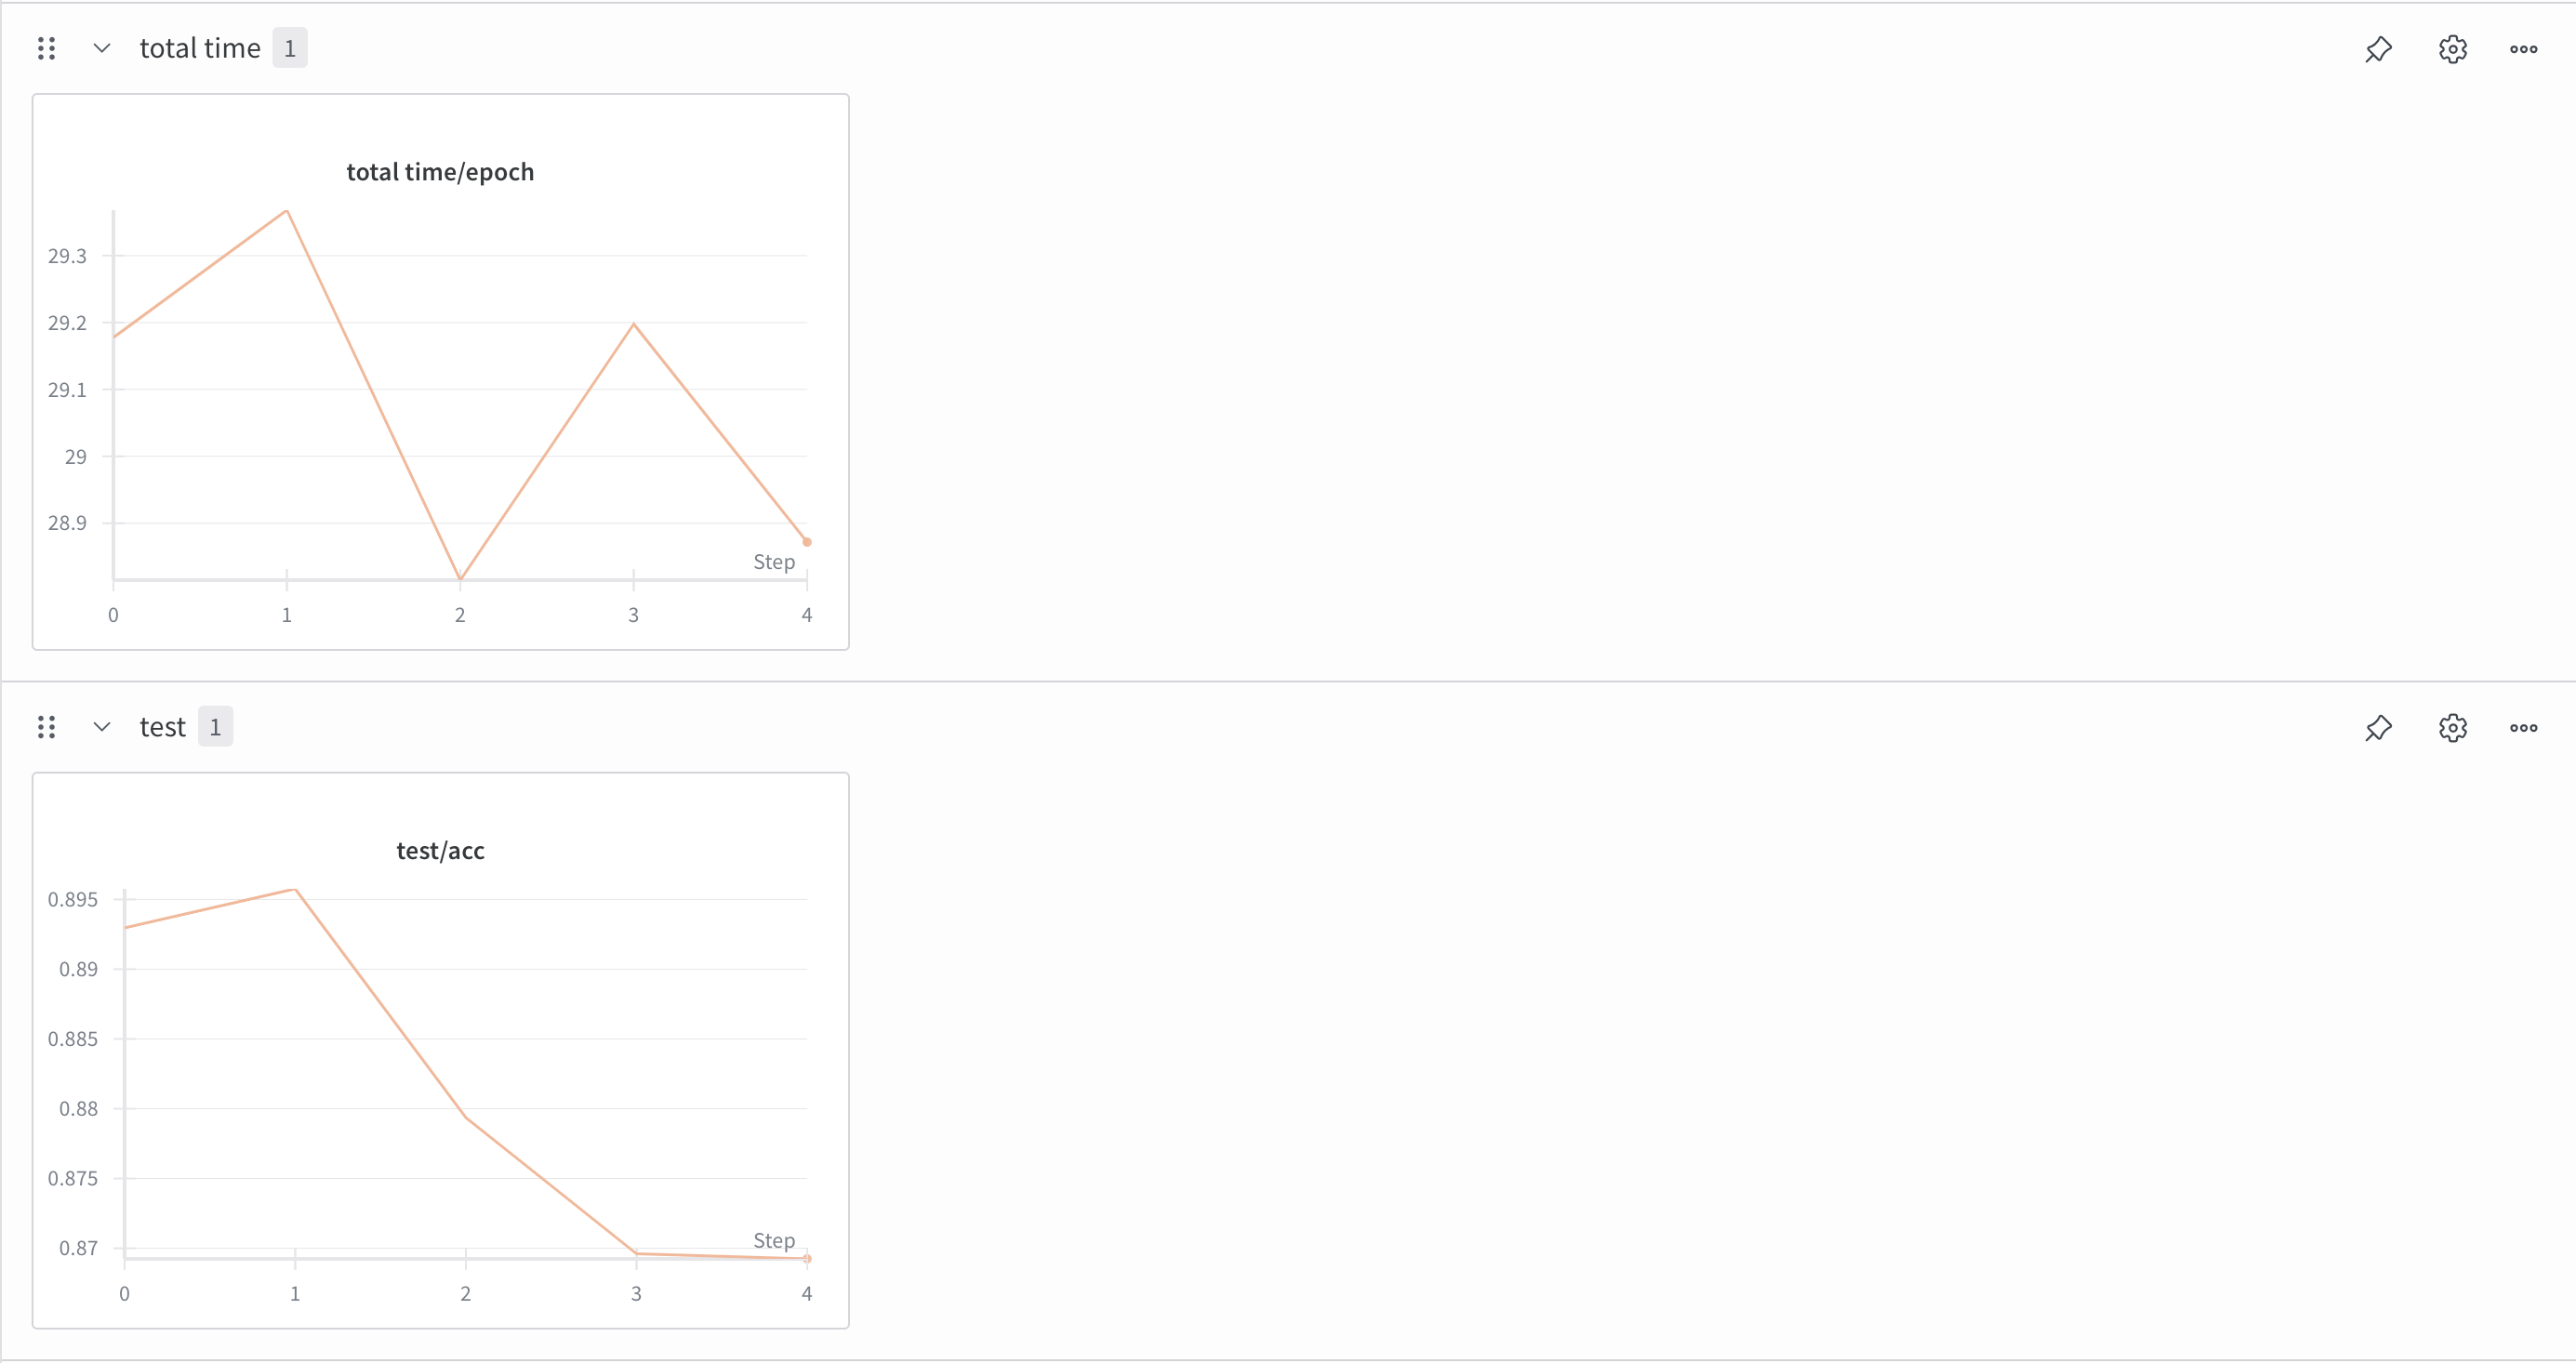
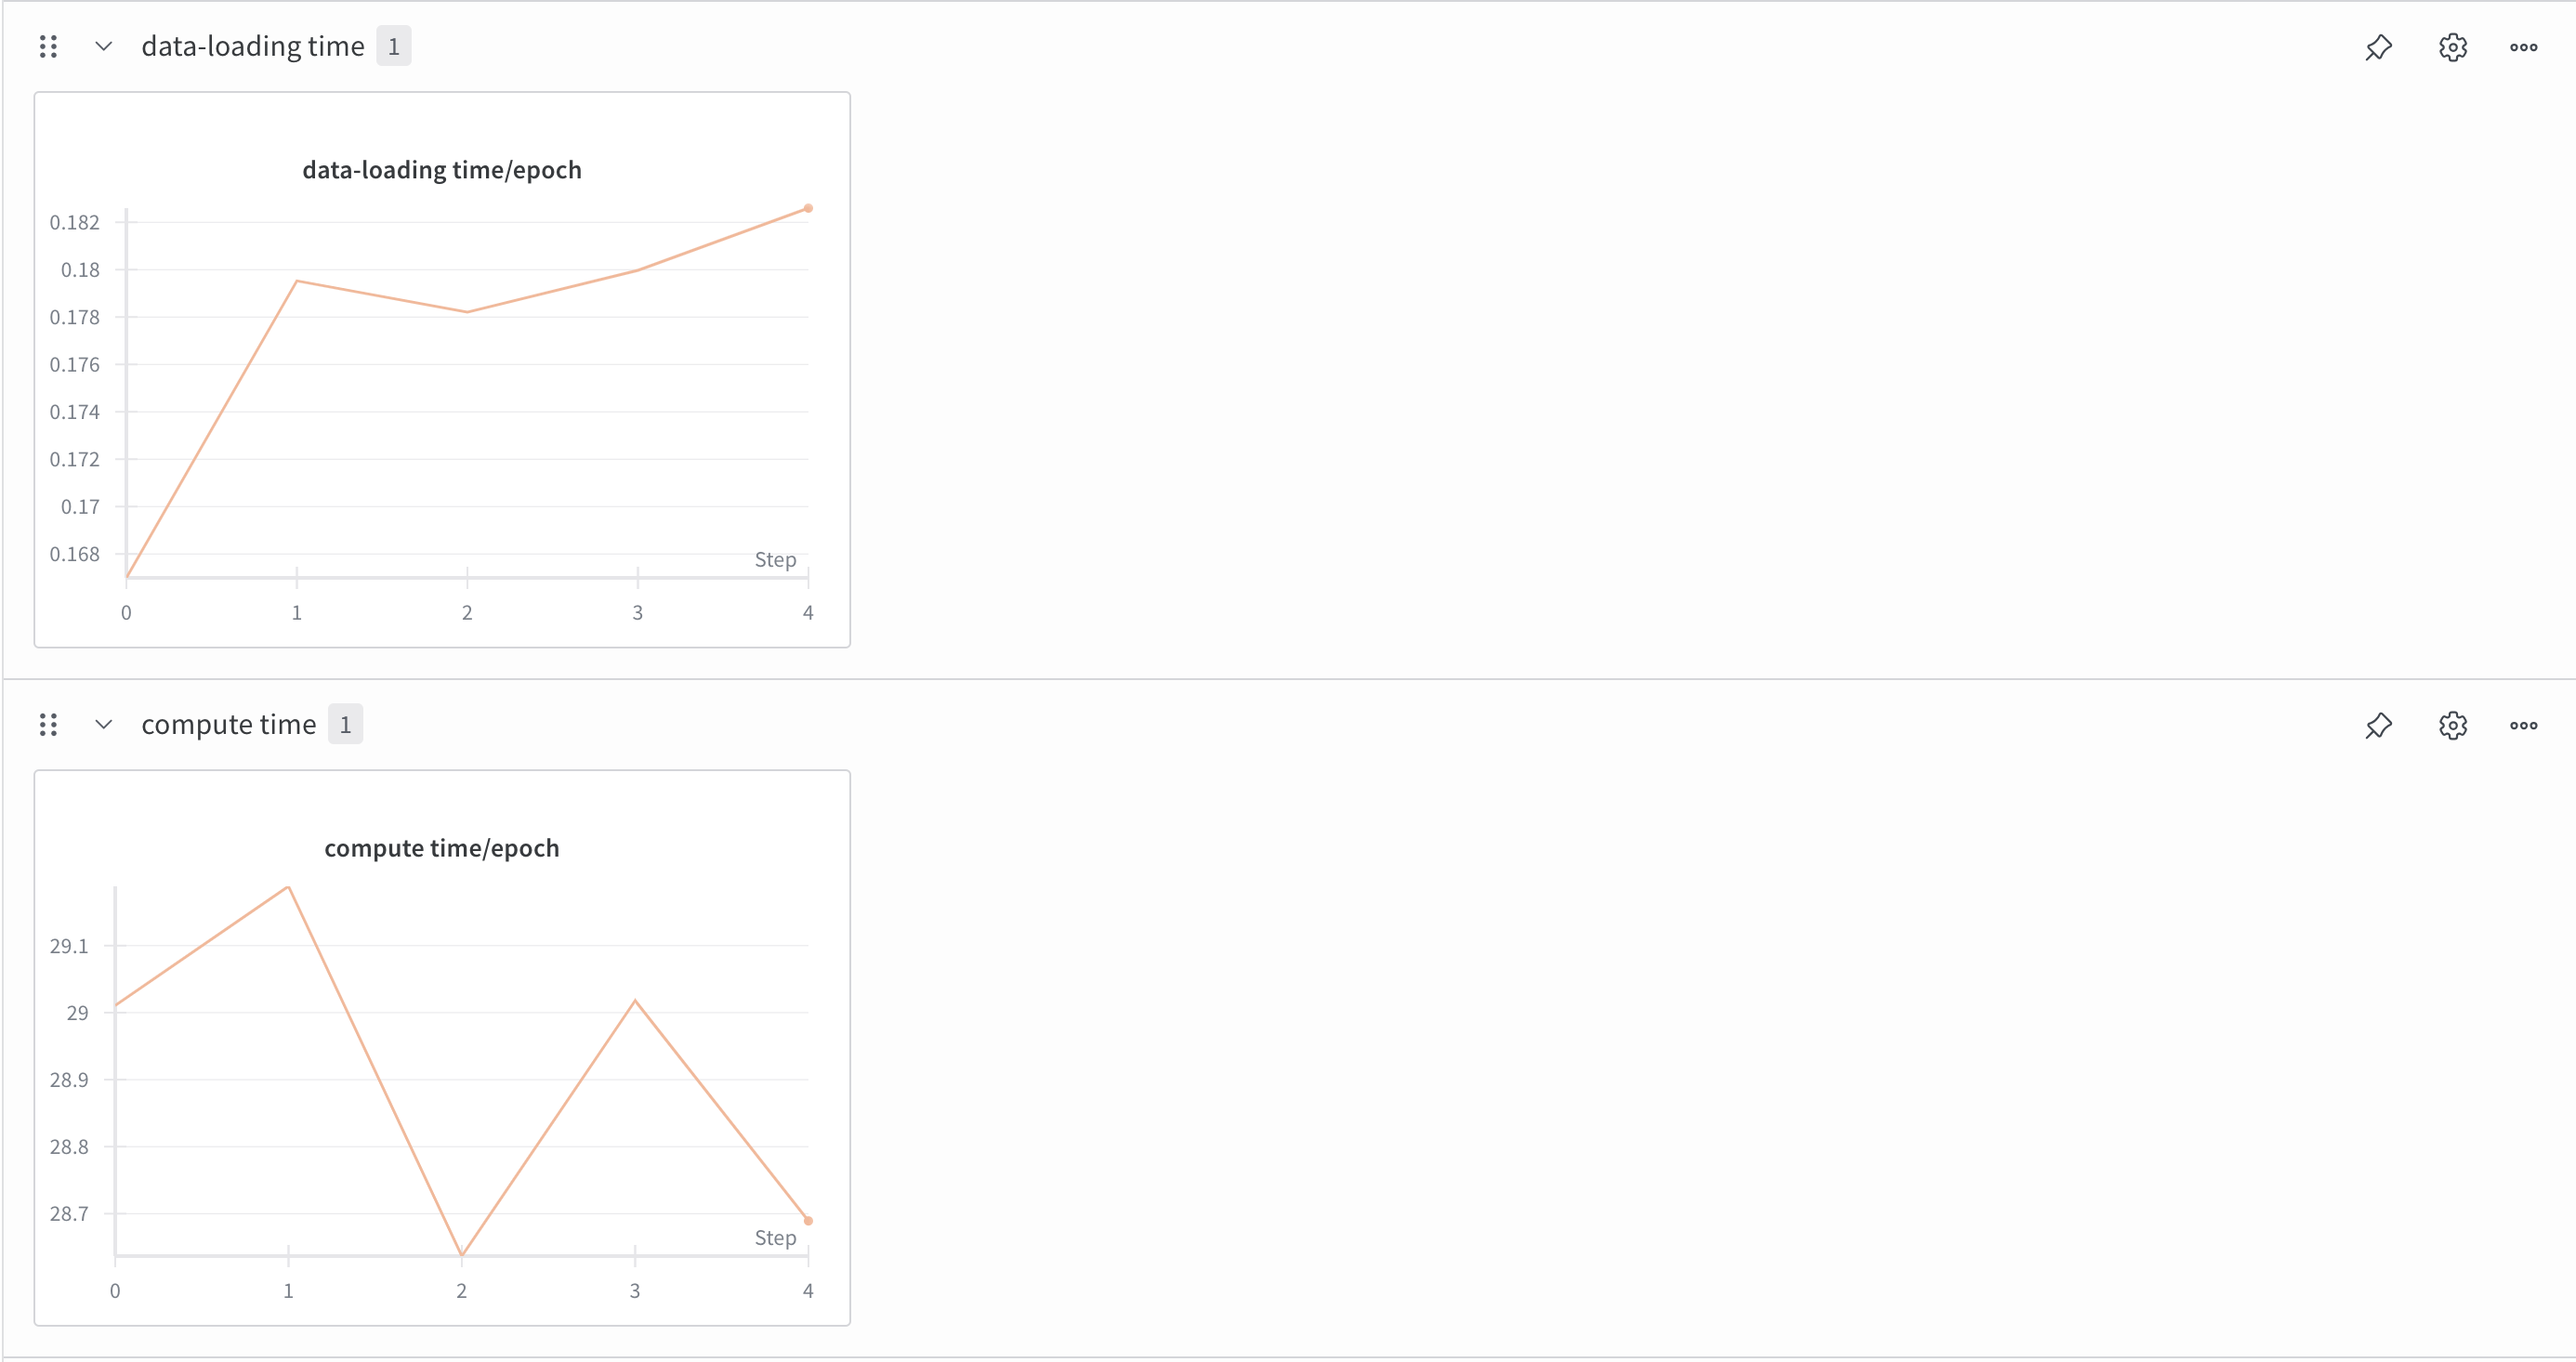
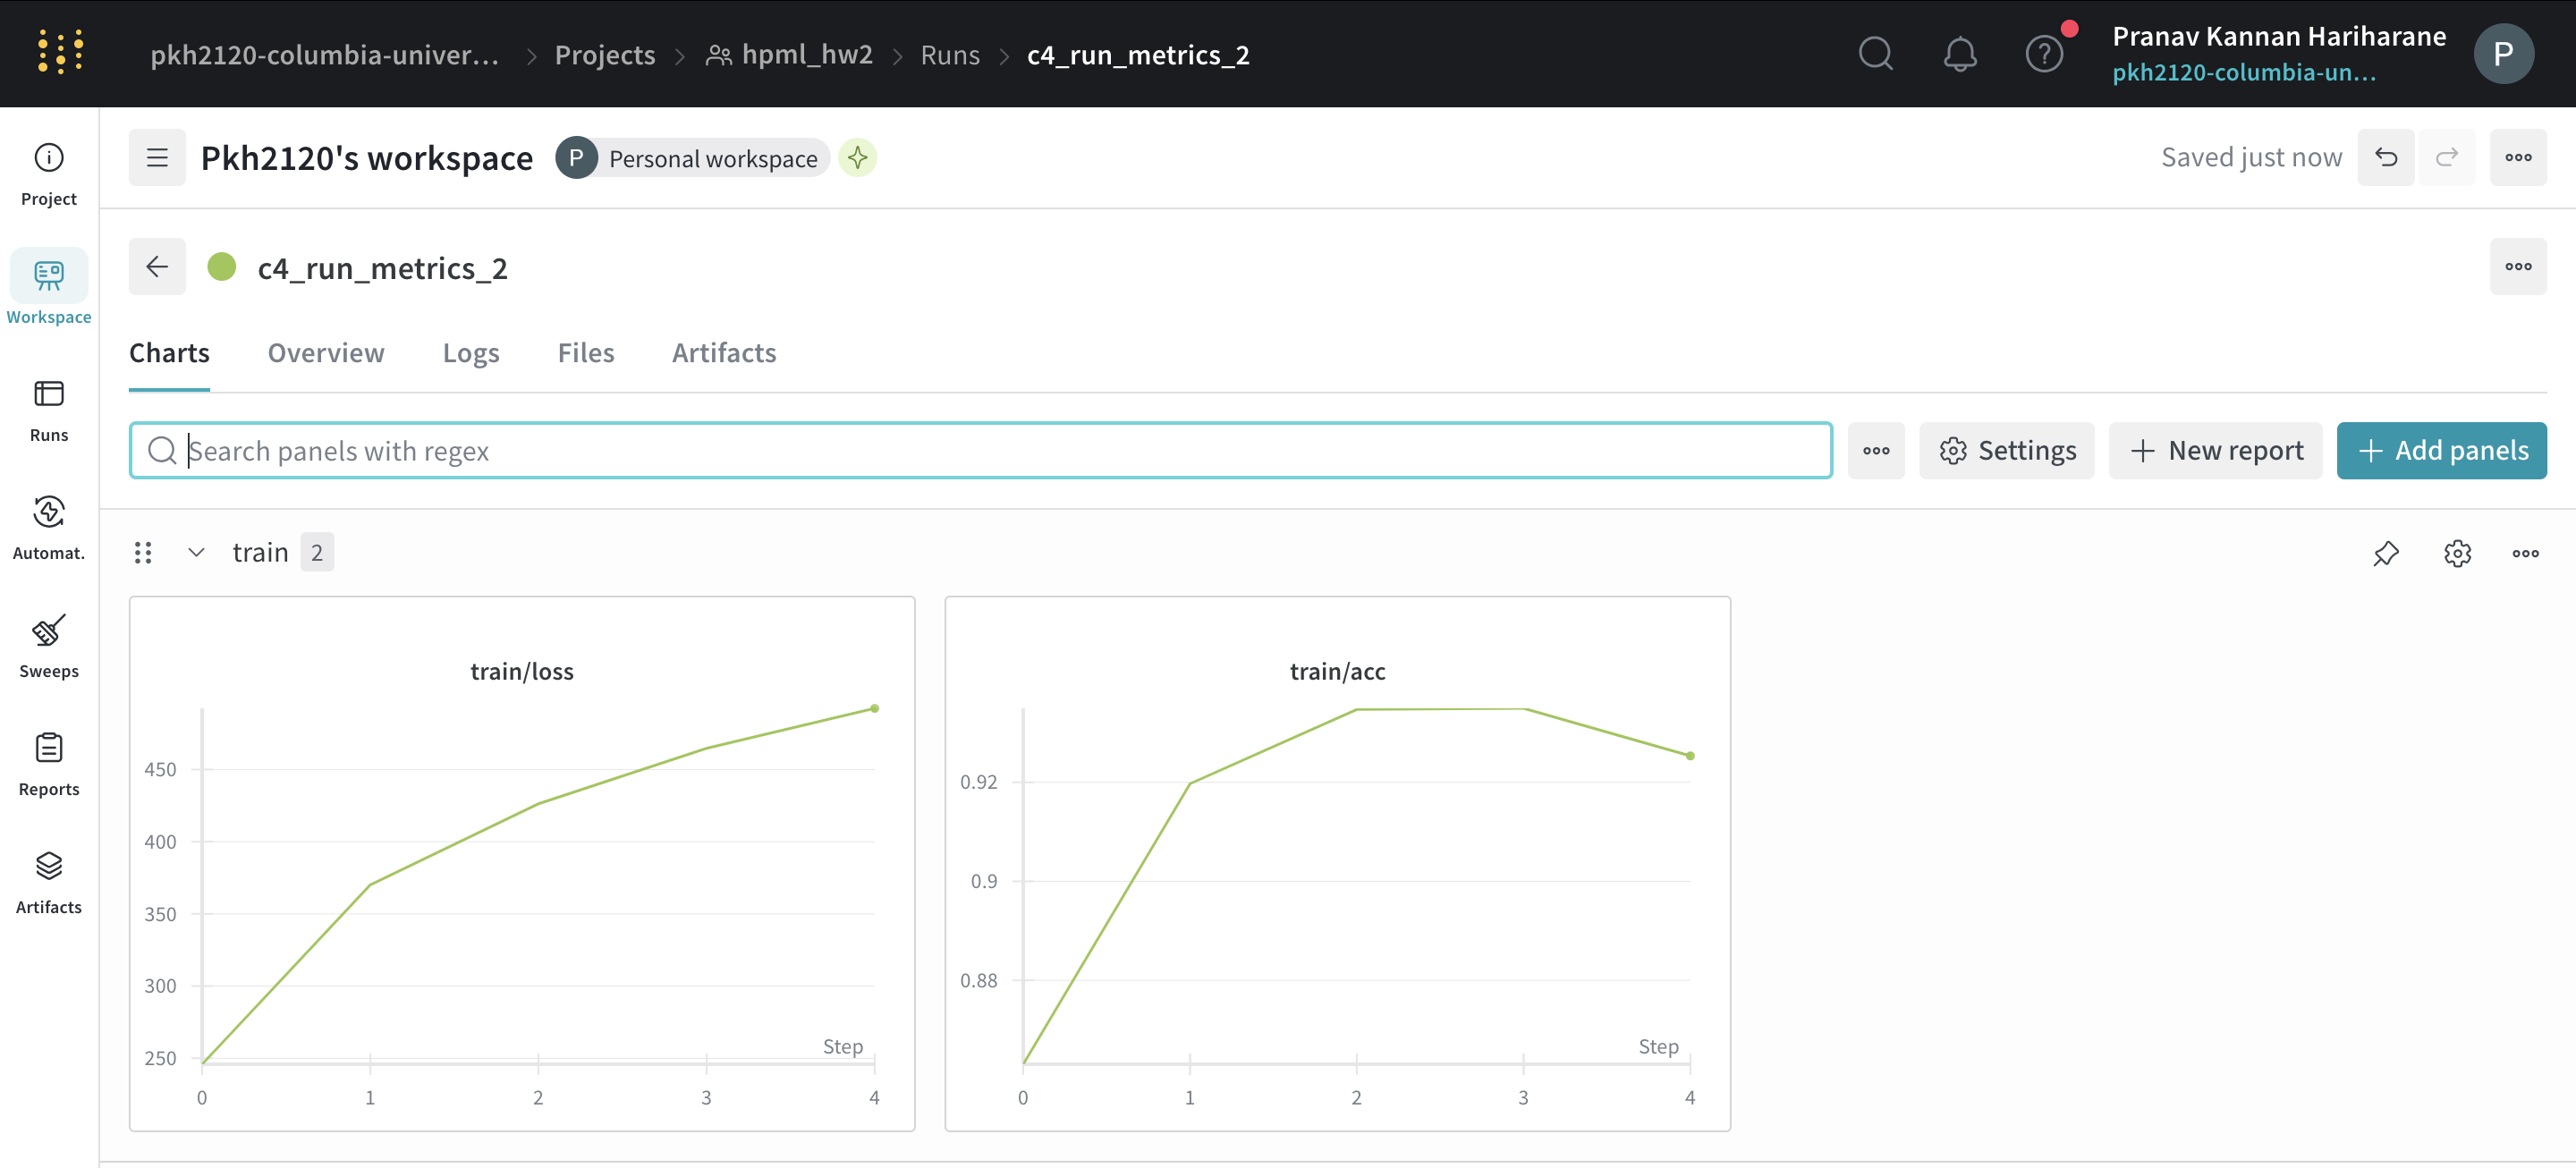
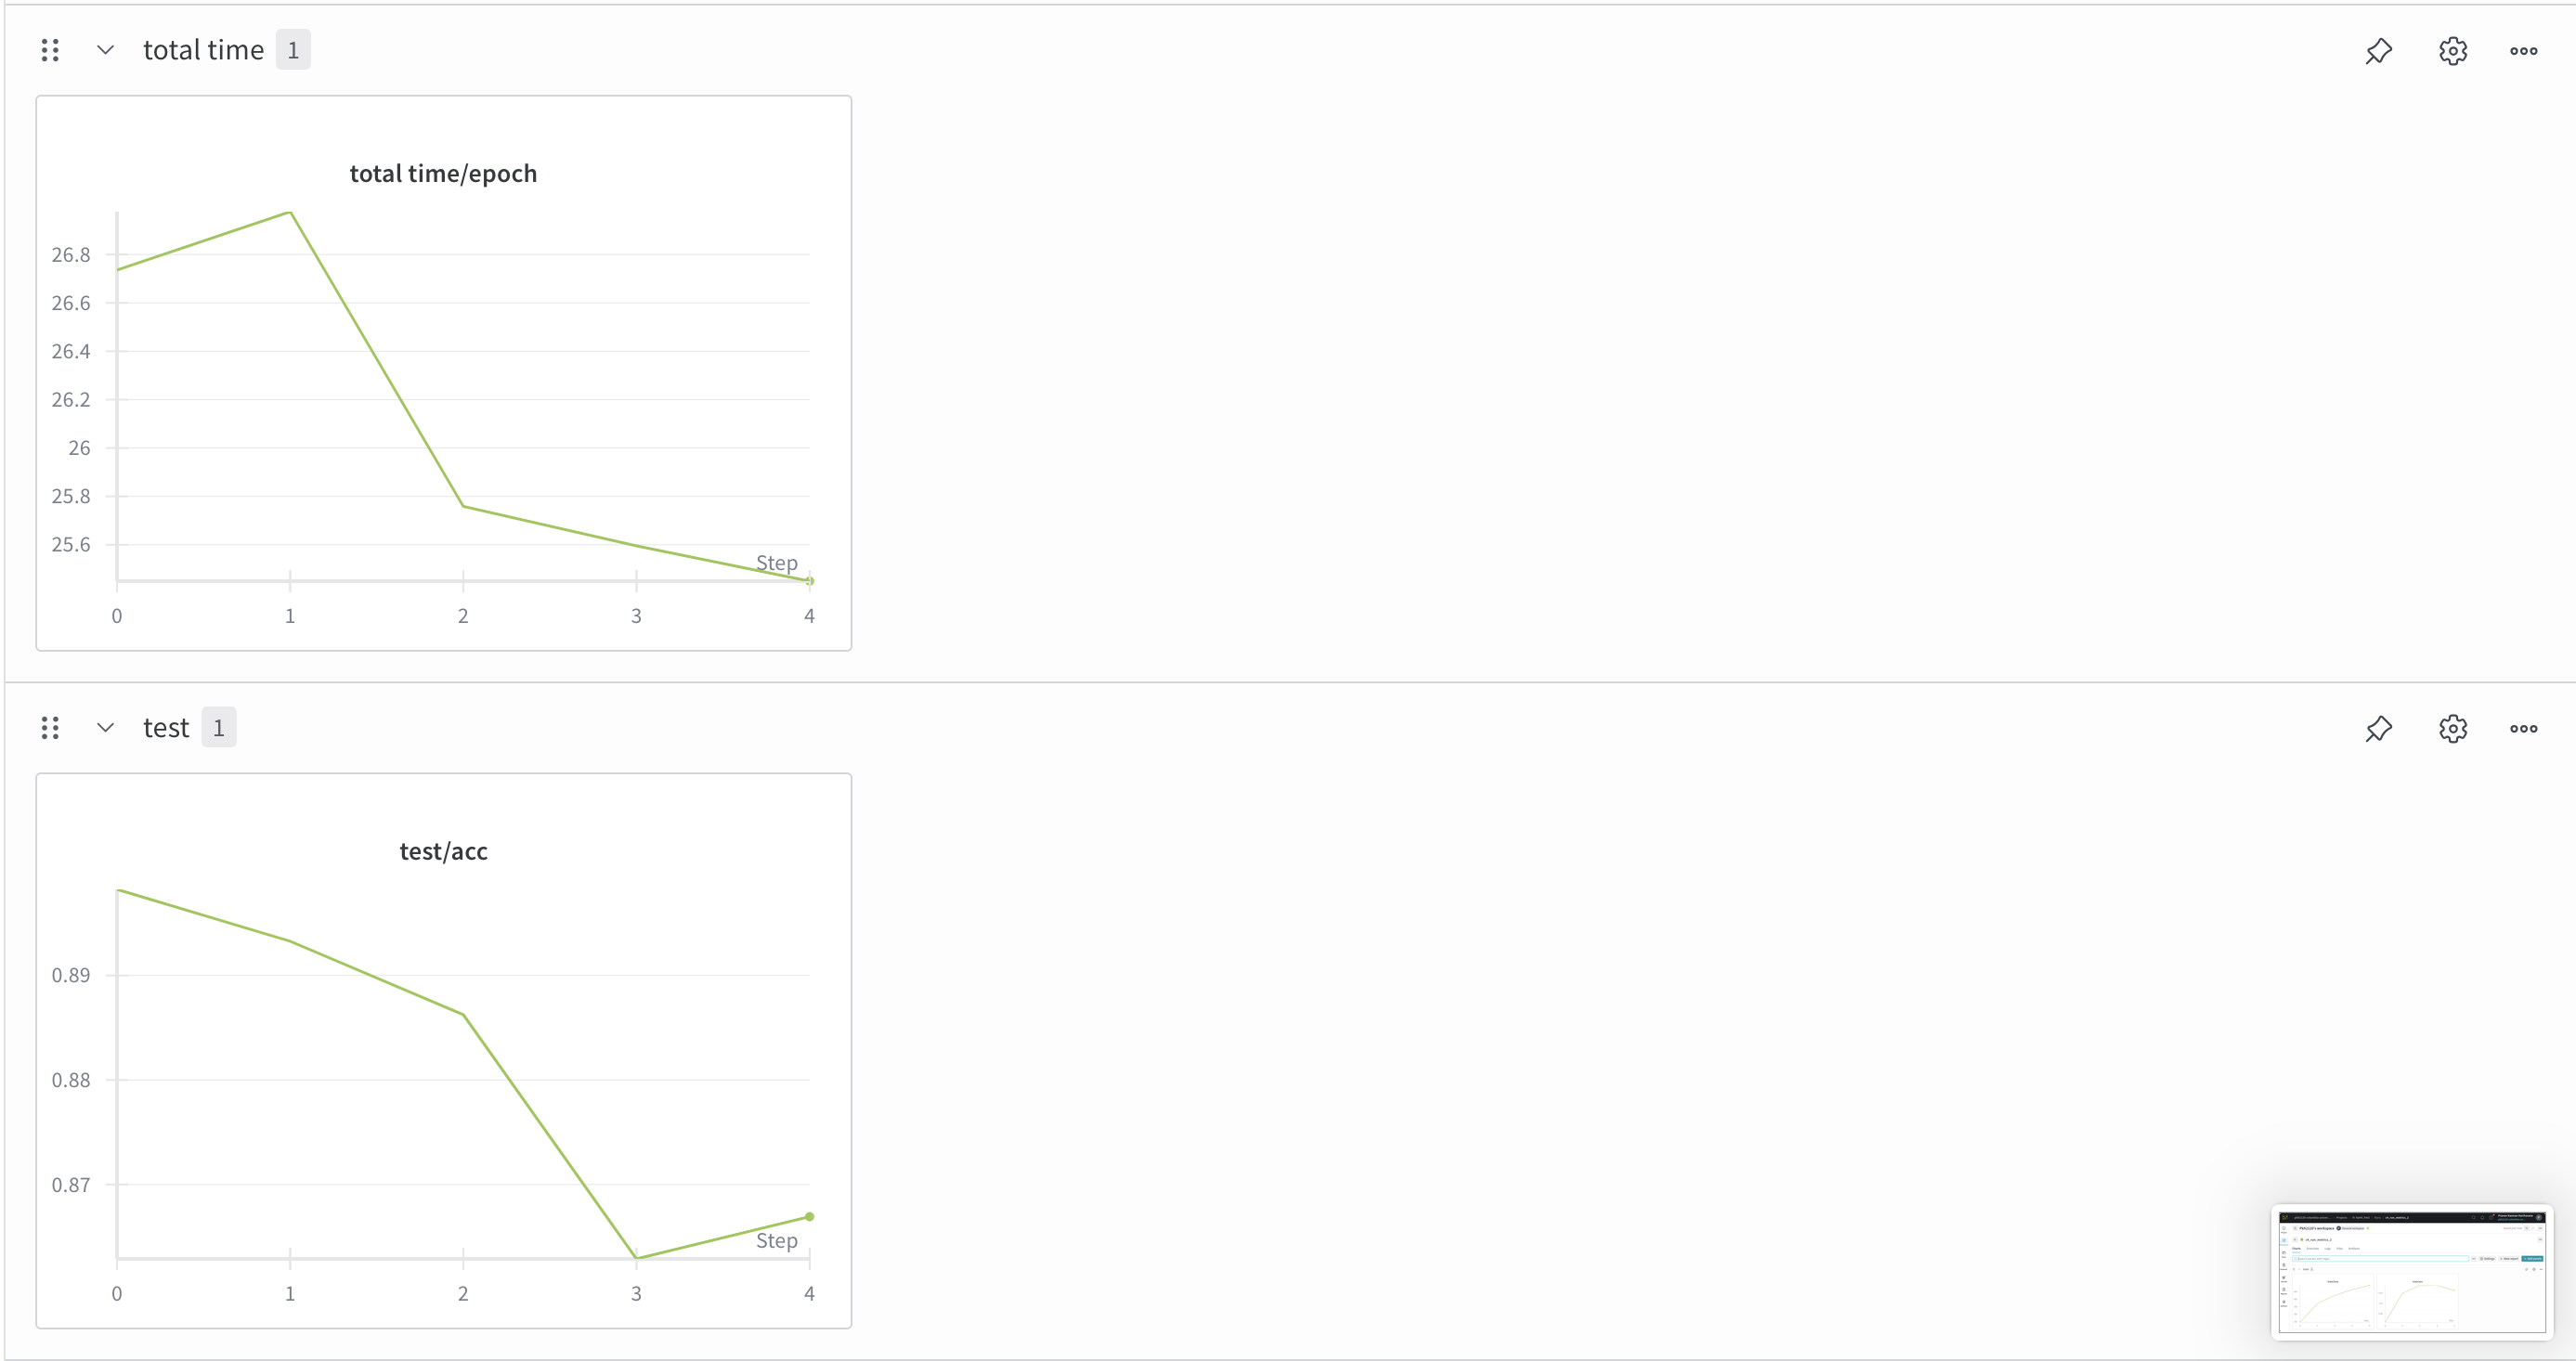
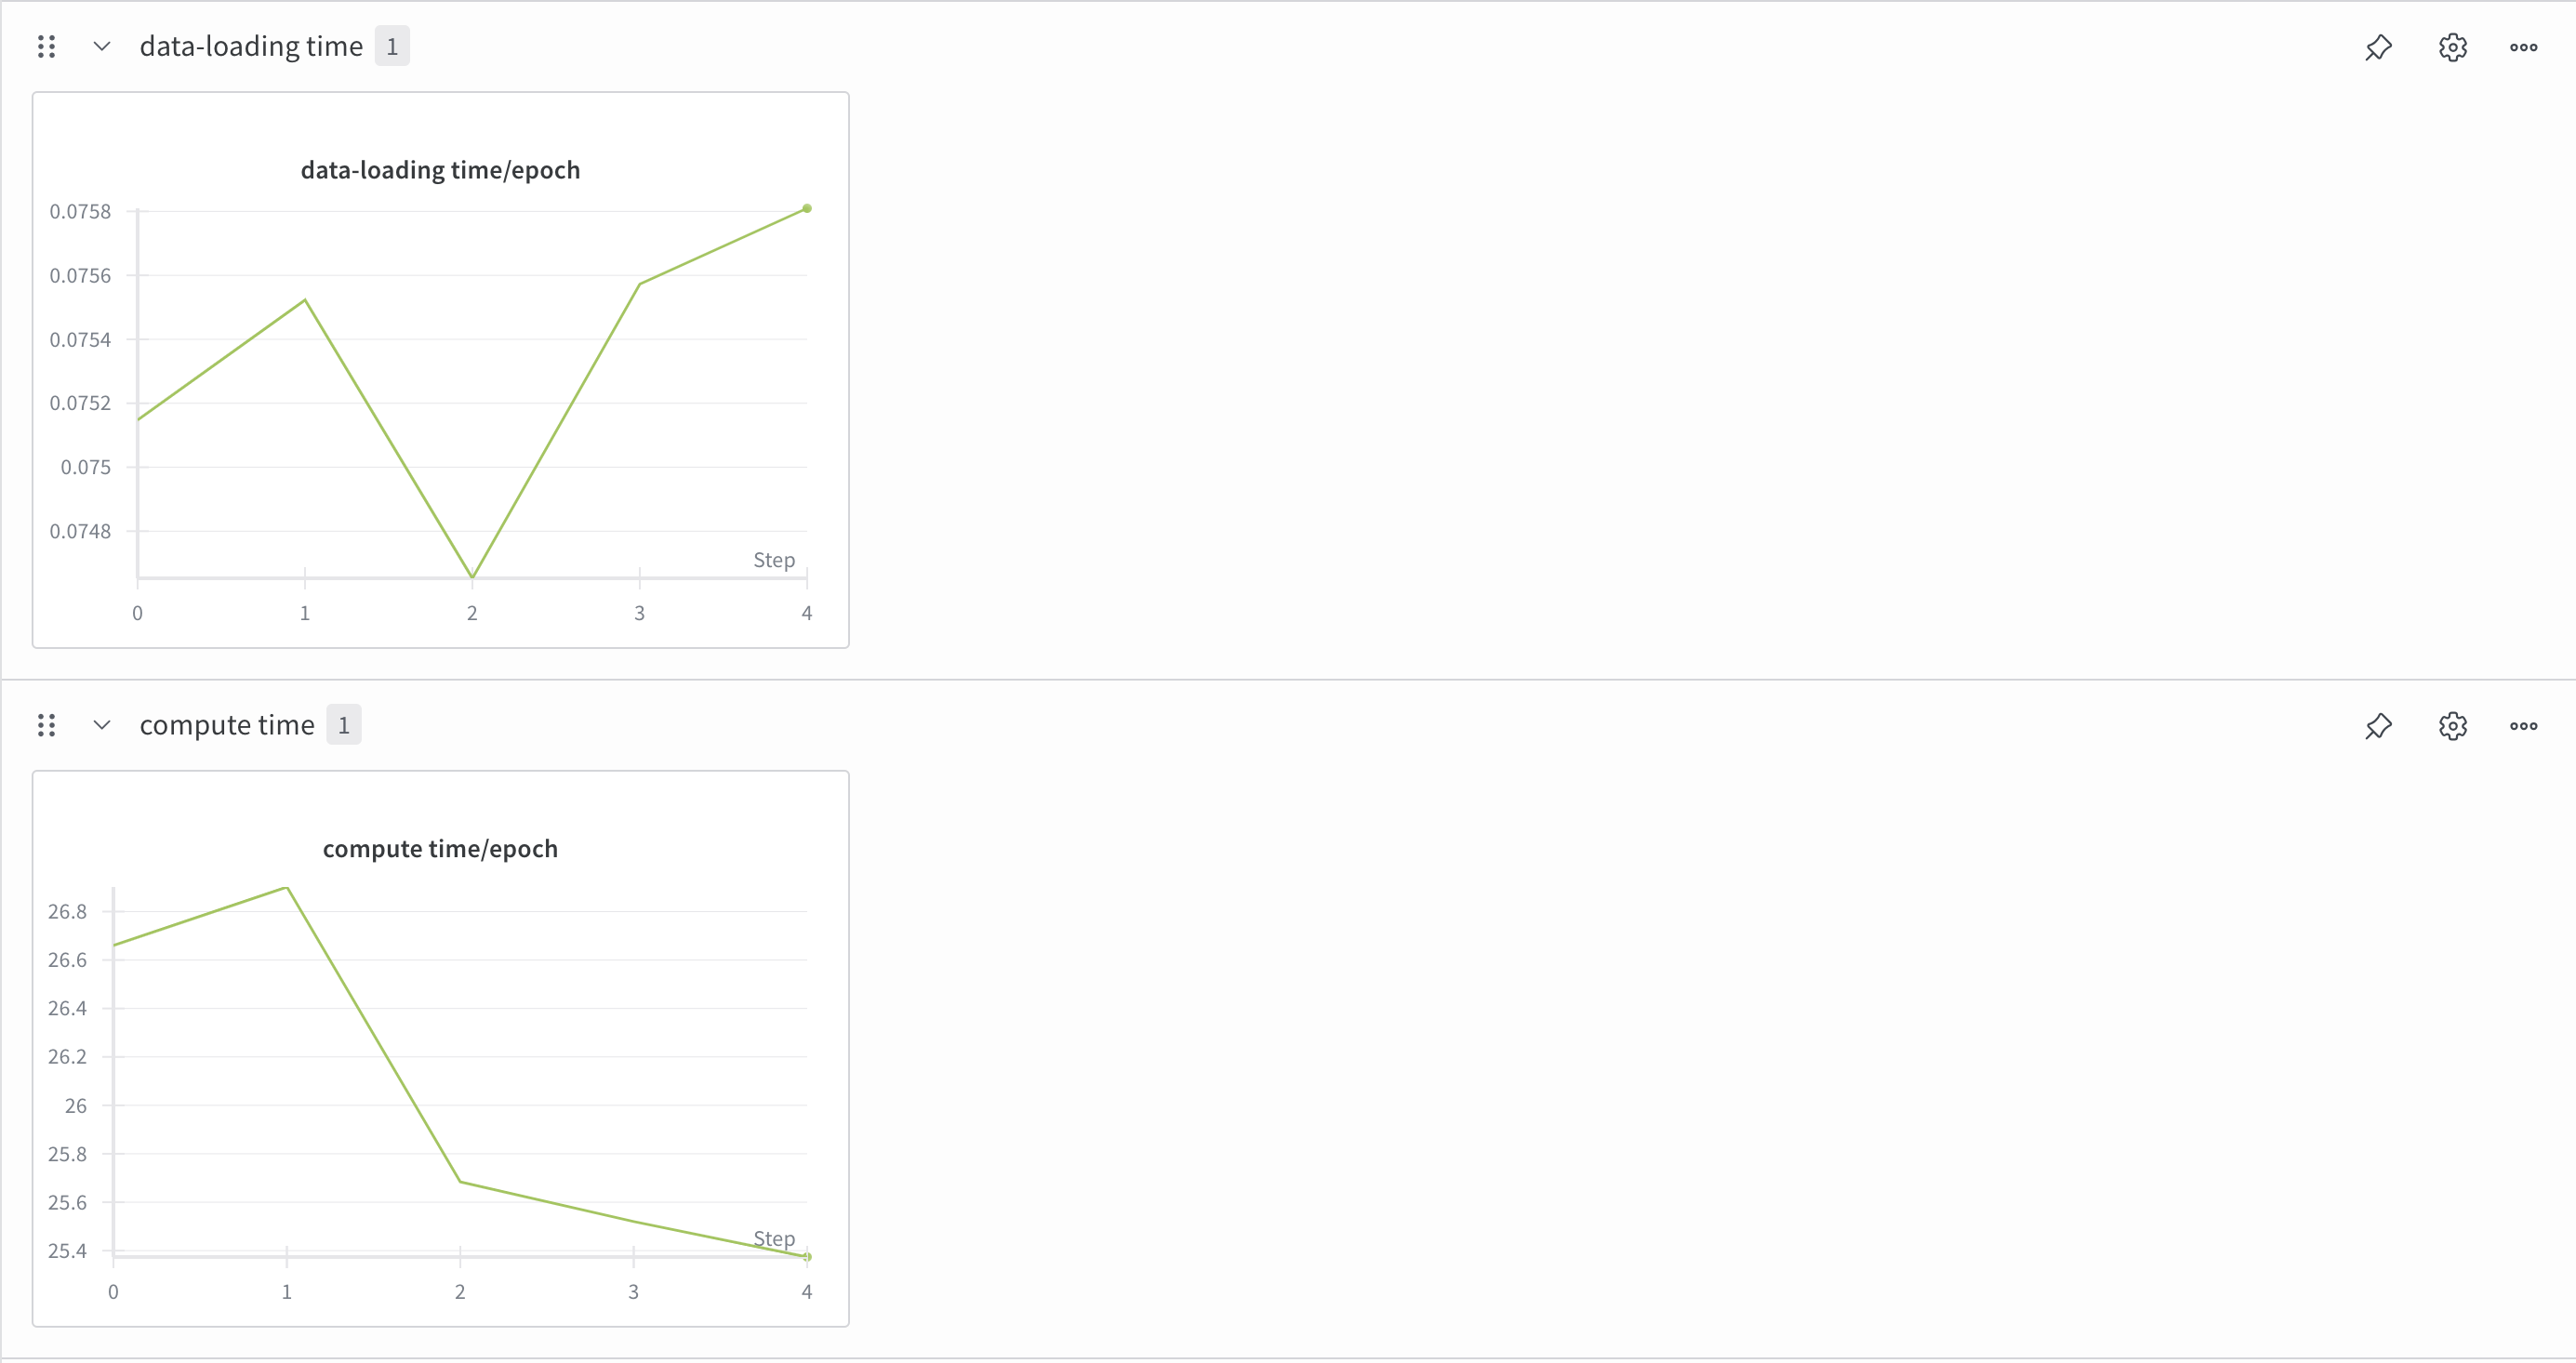

In [29]:
# C5 CPU vs. GPU
wandb.init(project="hpml_hw2", name="c5_run_metrics")
metrics = {
    'device': [],
    'avg_epoch_time': [],
    'train_loss': [],
    'test_acc': []
}
configs = {
    'model_name': "distilbert-base-uncased",
    'max_len': 256,
    'batch_size': 32,
    "learning_rate": 1e-4,
    "optimizer": "AdamW", 
    "num_workers": 1,
    "epochs": 5, 
    'device': "cpu",
    "compile_mode": False
}

# Skipping training for 5 epochs on CPU since it's taking way too long(took more than 2 hours for just one epoch).
"""
model = DistilBertForSequenceClassification.from_pretrained(
    configs['model_name']
)
model.to(configs['device'])
optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])
train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=configs['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=configs['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
wandb.config.update(configs)

total_epoch_time = 0
final_train_loss = 0
final_test_acc = 0
for epoch in range(1, configs['epochs'] + 1):
    epoch_start = time.time()
    train_loss, train_acc, data_loading_time, compute_time = train_epoch(
        model, train_dataloader, optimizer, configs['device']
    )
    epoch_end = time.time()
    test_acc = test(model, test_dataloader, configs['device'])
    total_time = epoch_end - epoch_start

    total_epoch_time += total_time
    final_train_loss = train_loss
    final_test_acc = test_acc
    wandb.log({"train/loss": train_loss, "train/acc": train_acc, "test/acc": test_acc, "data-loading time/epoch": data_loading_time, "compute time/epoch": compute_time, "total time/epoch": total_time})
metrics['device'].append("CPU")
metrics['avg_epoch_time'].append(total_epoch_time / configs['epochs'])
metrics['train_loss'].append(final_train_loss)
metrics['test_acc'].append(final_test_acc)
del model, optimizer, train_dataloader, test_dataloader
torch.cuda.empty_cache()
"""
metrics['device'].append("CPU")
metrics['avg_epoch_time'].append("Skipping training for 5 epochs on CPU since it's taking way too long")
metrics['train_loss'].append("Skipping training for 5 epochs on CPU since it's taking way too long")
metrics['test_acc'].append("Skipping training for 5 epochs on CPU since it's taking way too long")

configs['device'] = "cuda"
model = DistilBertForSequenceClassification.from_pretrained(
    configs['model_name']
)
model.to(configs['device'])
optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])
train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=configs['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=configs['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
wandb.config.update(configs)

total_epoch_time = 0
final_train_loss = 0
final_test_acc = 0
for epoch in range(1, configs['epochs'] + 1):
    epoch_start = time.time()
    train_loss, train_acc, data_loading_time, compute_time = train_epoch(
        model, train_dataloader, optimizer, configs['device']
    )
    epoch_end = time.time()
    test_acc = test(model, test_dataloader, configs['device'])
    total_time = epoch_end - epoch_start

    total_epoch_time += total_time
    final_train_loss = train_loss
    final_test_acc = test_acc
    wandb.log({"train/loss": train_loss, "train/acc": train_acc, "test/acc": test_acc, "data-loading time/epoch": data_loading_time, "compute time/epoch": compute_time, "total time/epoch": total_time})
metrics['device'].append("GPU")
metrics['avg_epoch_time'].append(total_epoch_time / configs['epochs'])
metrics['train_loss'].append(final_train_loss)
metrics['test_acc'].append(final_test_acc)
del model, optimizer, train_dataloader, test_dataloader
torch.cuda.empty_cache()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# C5 Results
df_metrics = pd.DataFrame(metrics)
df_metrics.columns = ['Device', 'Avg Epoch Time(s)', 'Final Train Loss', 'Final Test Acc']
print("Table T5")
print(df_metrics)

Table T5
  Device                                  Avg Epoch Time(s)  \
0    CPU  Skipping training for 5 epochs on CPU since it...   
1    GPU                                          53.401075   

                                    Final Train Loss  \
0  Skipping training for 5 epochs on CPU since it...   
1                                          33.701786   

                                      Final Test Acc  
0  Skipping training for 5 epochs on CPU since it...  
1                                            0.86948  


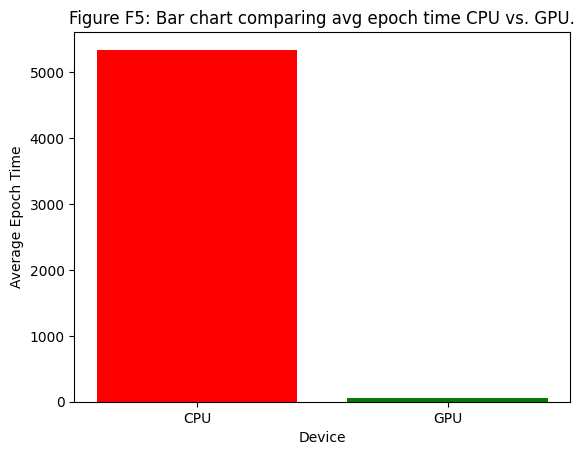

In [44]:
# C5 Results
categories = ["CPU", "GPU"]
values = [metrics['avg_epoch_time'][1] * 100, metrics['avg_epoch_time'][1]]
plt.bar(categories, values, color=['red', 'green'])
plt.xlabel('Device')
plt.ylabel('Average Epoch Time')
plt.title('Figure F5: Bar chart comparing avg epoch time CPU vs. GPU.')
plt.show()


# W & B Link: https://wandb.ai/pkh2120-columbia-university/hpml_hw2/runs/b65b1ksn?nw=nwuserpkh2120
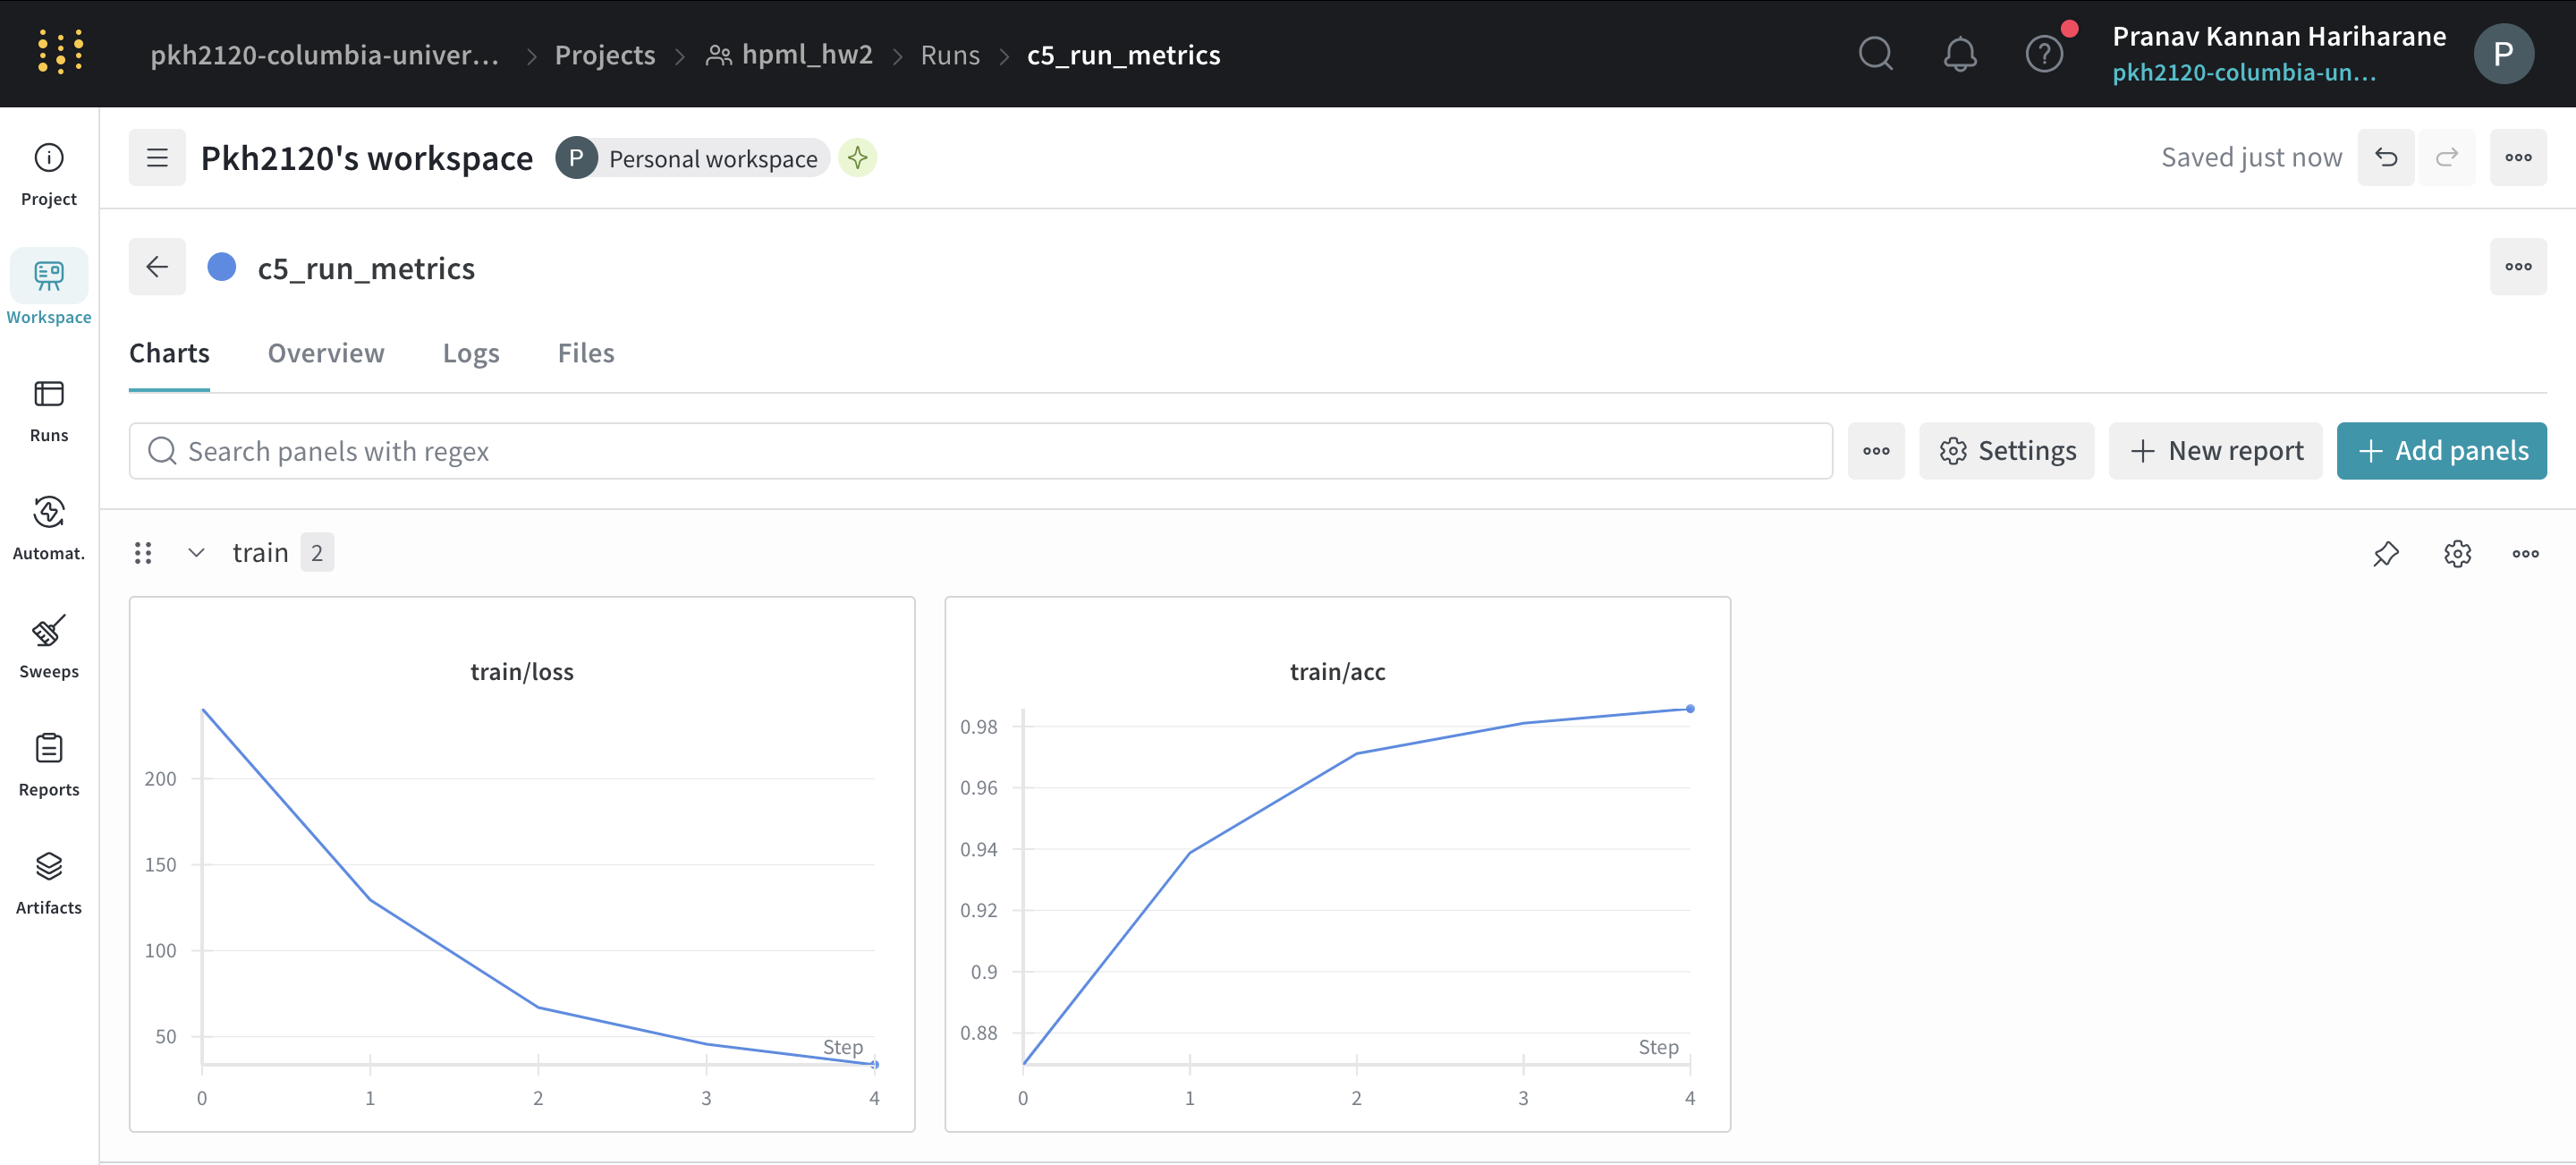
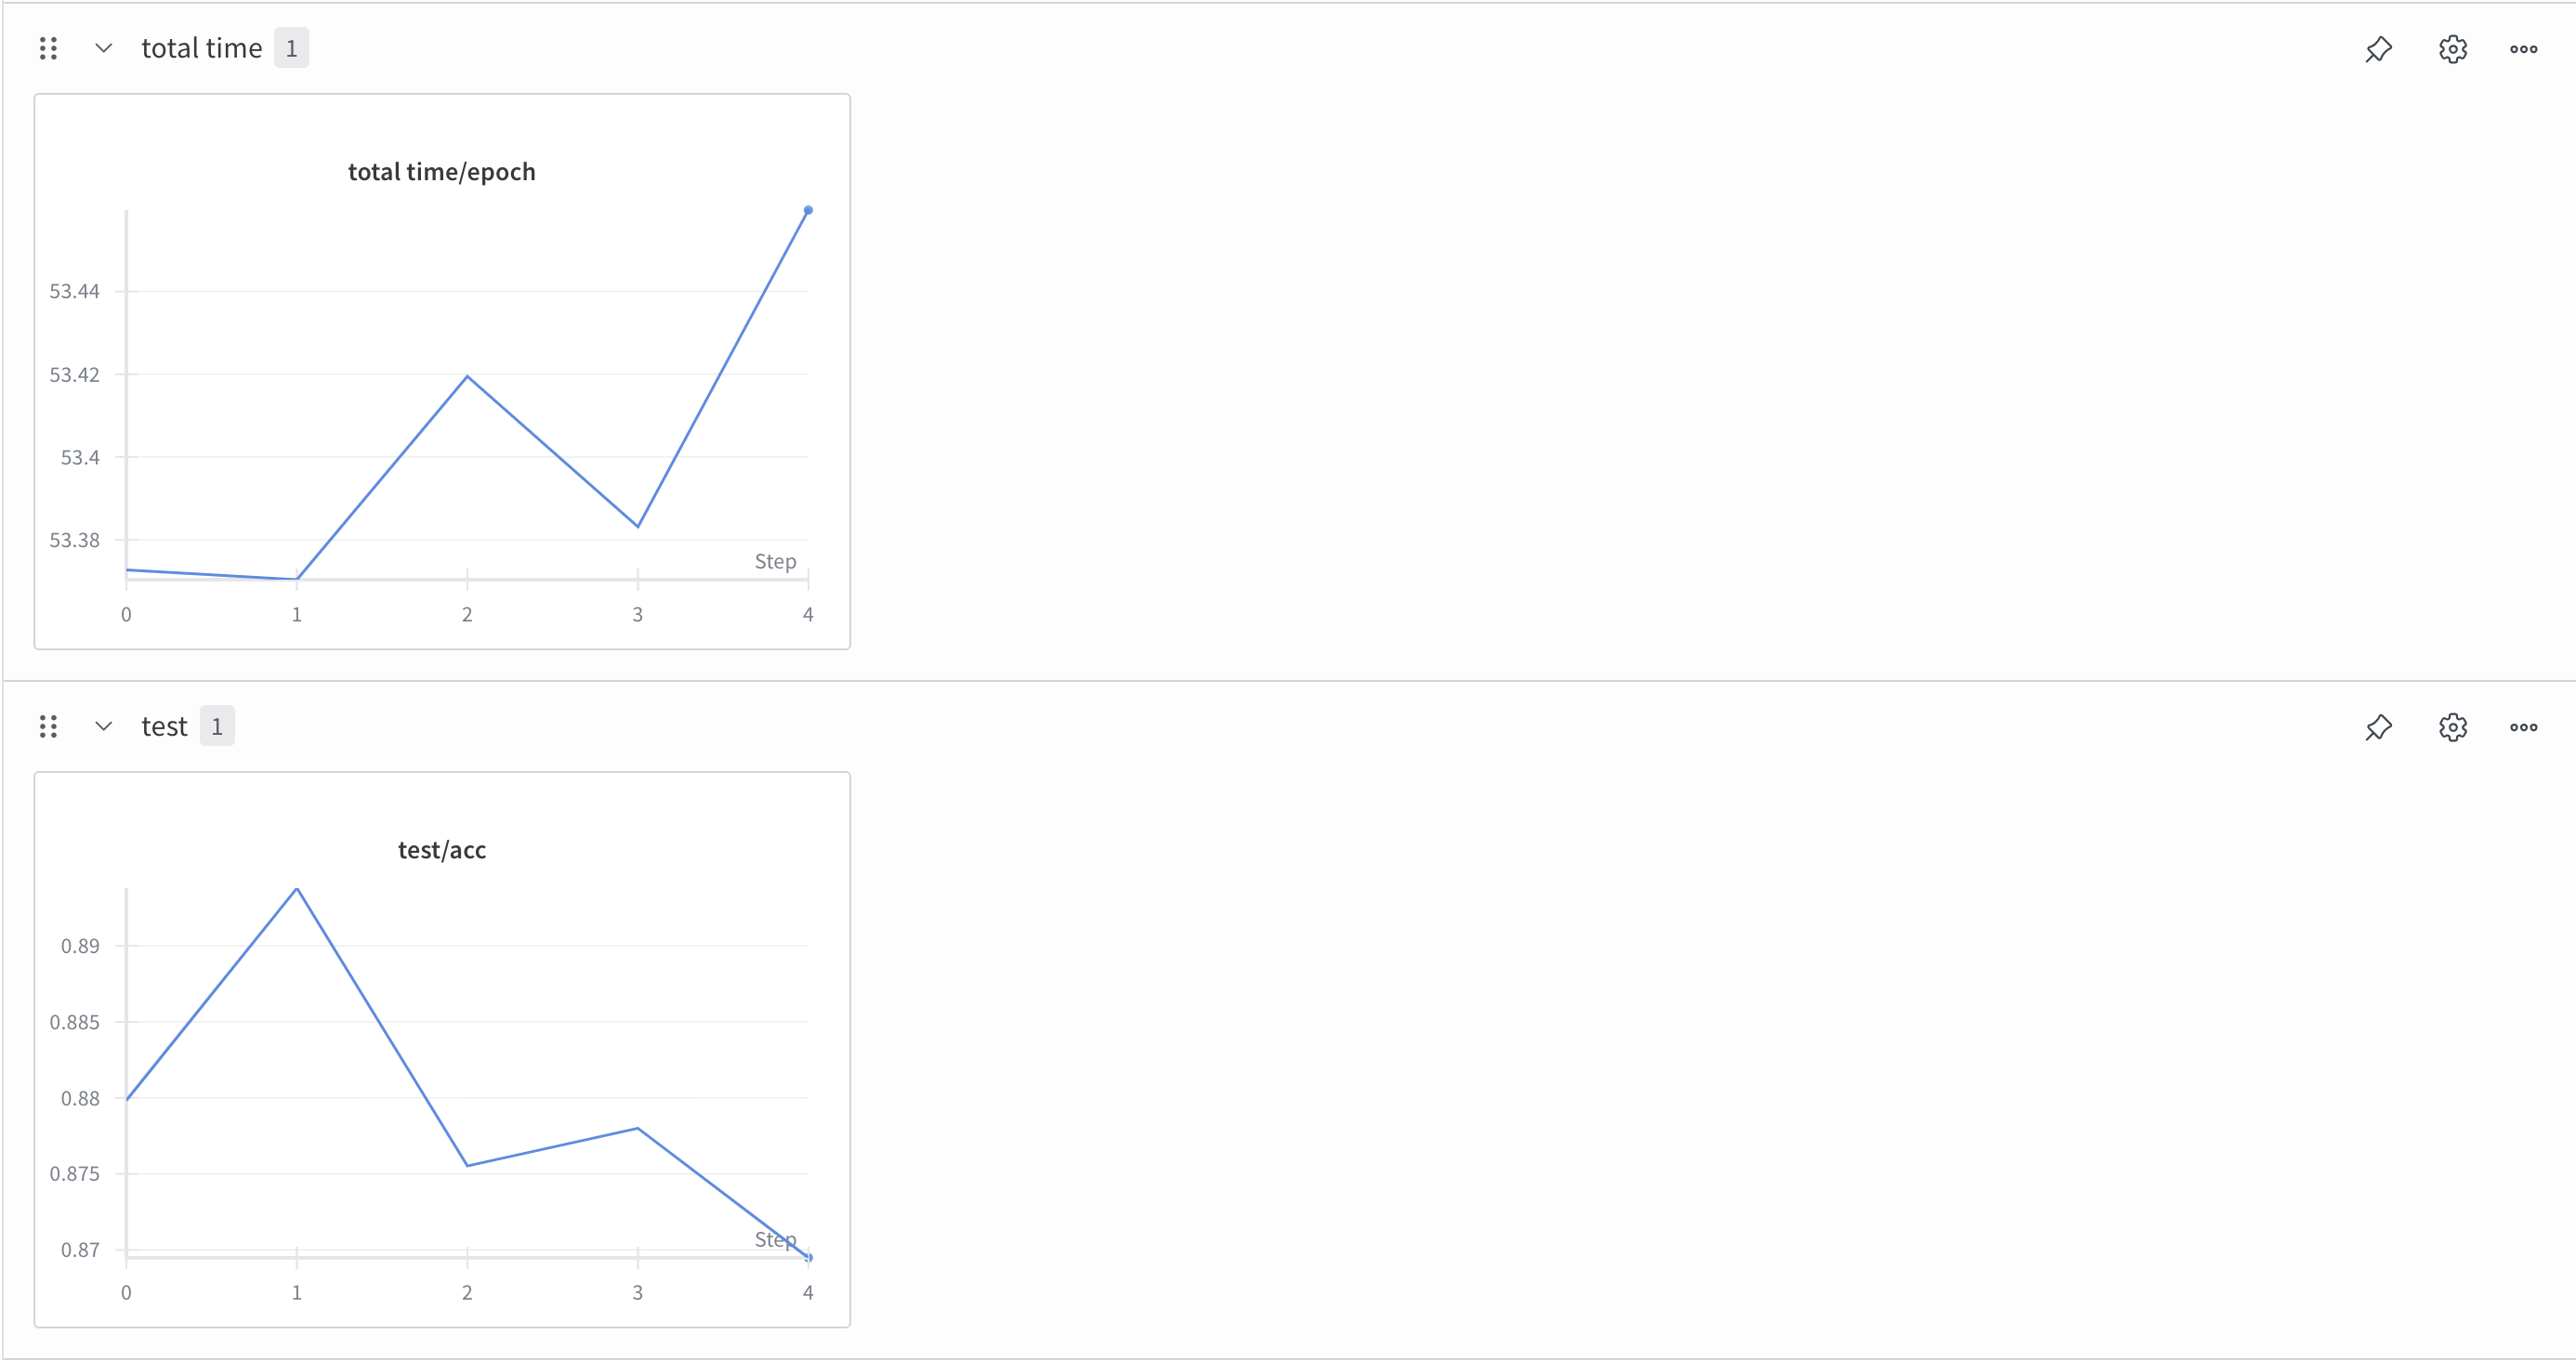
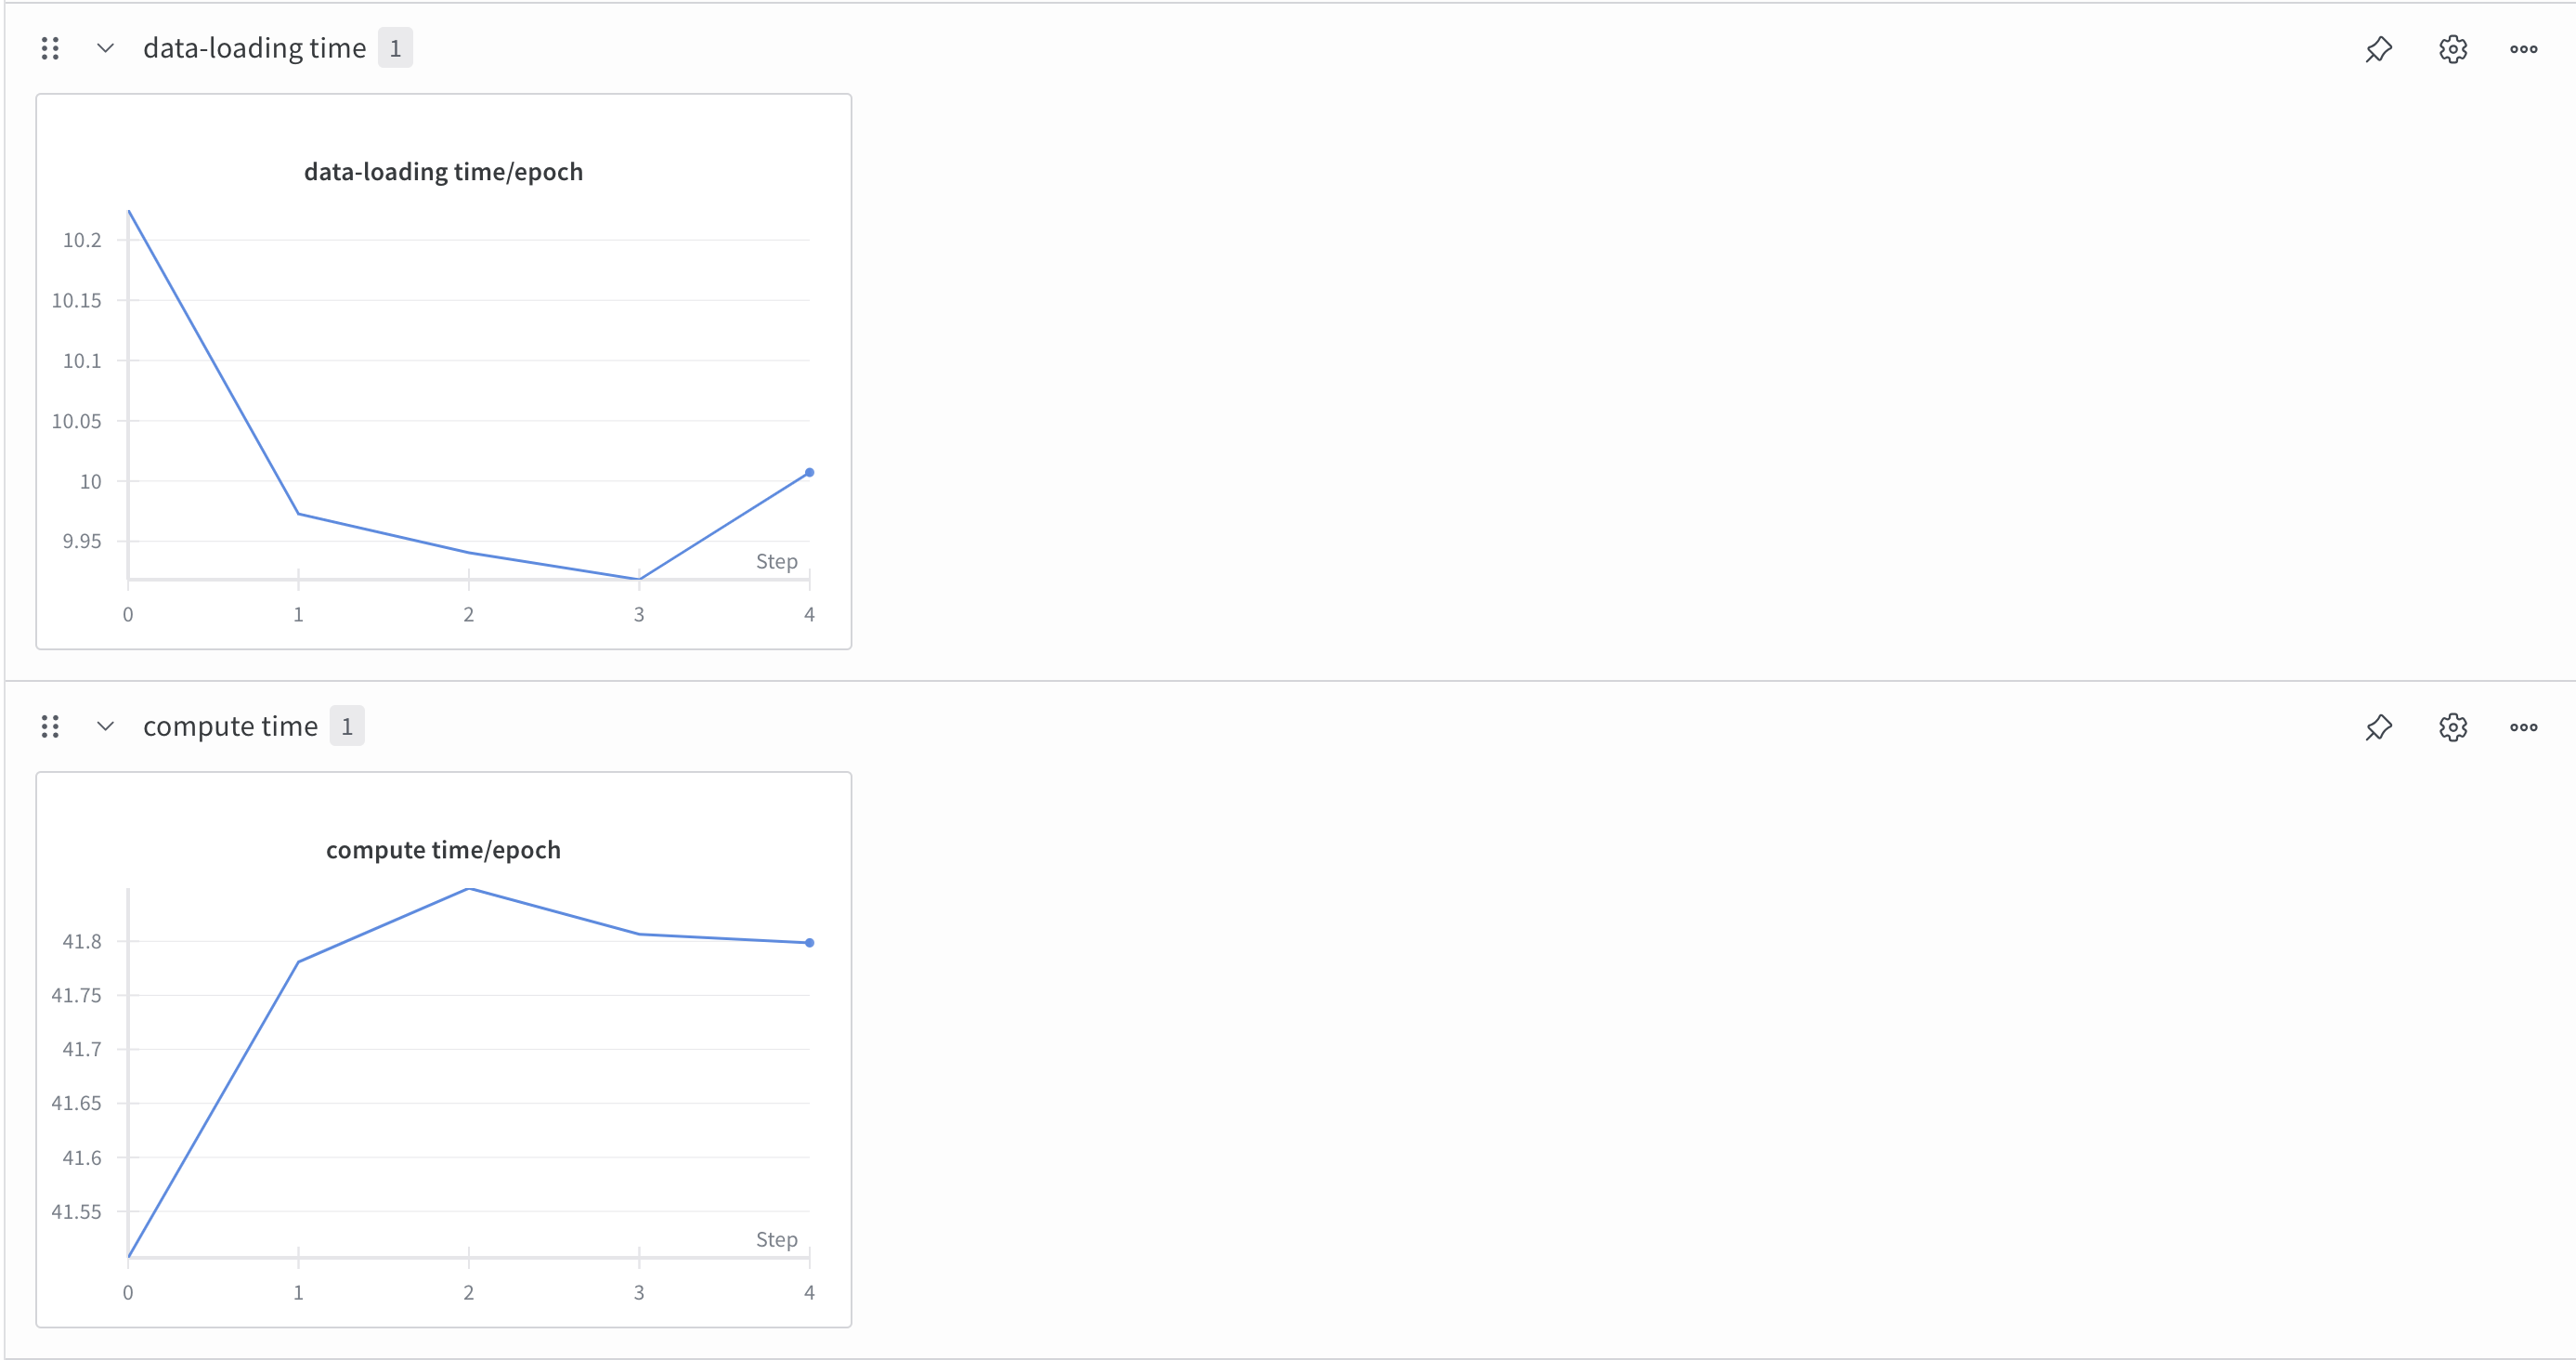

In [16]:
# C6 Hyperparameter Sensitivity
wandb.init(project="hpml_hw2", name="c6_run_metrics")
batch_sizes = [16, 32, 64]
learning_rates = [0.00005, 0.0001, 0.0005]
configs = {
    'model_name': "distilbert-base-uncased",
    'max_len': 256,
    'batch_size': 32,
    "learning_rate": 1e-4,
    "optimizer": "AdamW", 
    "num_workers": 1,
    "epochs": 5, 
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    "compile_mode": False
}

metrics = {}

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        model = DistilBertForSequenceClassification.from_pretrained(
            configs['model_name']
        )
        model.to(configs['device'])
        configs['learning_rate'] = learning_rate
        configs['batch_size'] = batch_size
        optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])
        train_dataloader = DataLoader(
            tokenized_datasets['train'],
            batch_size=configs['batch_size'],
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=configs['num_workers']
        )
        test_dataloader = DataLoader(
            tokenized_datasets['test'],
            batch_size=configs['batch_size'],
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=configs['num_workers']
        )
        wandb.config.update(configs)
        total_epoch_time = 0
        final_train_loss = 0
        final_test_acc = 0
        final_train_acc = 0
        for epoch in range(1, configs['epochs'] + 1):
            epoch_start = time.time()
            train_loss, train_acc, data_loading_time, compute_time = train_epoch(
                model, train_dataloader, optimizer, configs['device']
            )
            epoch_end = time.time()
            test_acc = test(model, test_dataloader, configs['device'])
            total_time = epoch_end - epoch_start

            total_epoch_time += total_time
            final_train_loss = train_loss
            final_test_acc = test_acc
            final_train_acc = train_acc
            wandb.log({"train/loss": train_loss, "train/acc": train_acc, "test/acc": test_acc, "data-loading time/epoch": data_loading_time, "compute time/epoch": compute_time, "total time/epoch": total_time})
    
        metrics[(batch_size, learning_rate)] = {
            'avg_epoch_time': total_epoch_time / configs['epochs'],
            'final_train_loss': final_train_loss,
            'final_train_acc': final_train_acc,
            'final_test_acc': final_test_acc
        }
        del model, optimizer, train_dataloader, test_dataloader
        torch.cuda.empty_cache()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-strea

In [17]:
# C6 Results
rows = []
for (batch, lr), stuff in metrics.items():
    row = {'batch_size': batch, 'learning_rate': lr}
    row.update(stuff)
    rows.append(row)

df = pd.DataFrame(rows)
print("Table T6:")
wandb.log({"table_t6": df})
print(df)

Table T6:
   batch_size  learning_rate  avg_epoch_time  final_train_loss  \
0          16        0.00005       68.837662         57.634565   
1          16        0.00010       68.761790         82.473652   
2          16        0.00050       68.234152       1083.469953   
3          32        0.00005       54.501812         23.424068   
4          32        0.00010       54.525588         33.947898   
5          32        0.00050       54.291011        542.189181   
6          64        0.00005       51.118249         13.903788   
7          64        0.00010       50.547920         12.172431   
8          64        0.00050       50.376110        271.040296   

   final_train_acc  final_test_acc  
0          0.98780         0.89080  
1          0.98324         0.83760  
2          0.50044         0.50000  
3          0.99032         0.89652  
4          0.98588         0.85692  
5          0.49848         0.50000  
6          0.98852         0.90328  
7          0.98964         0.8906

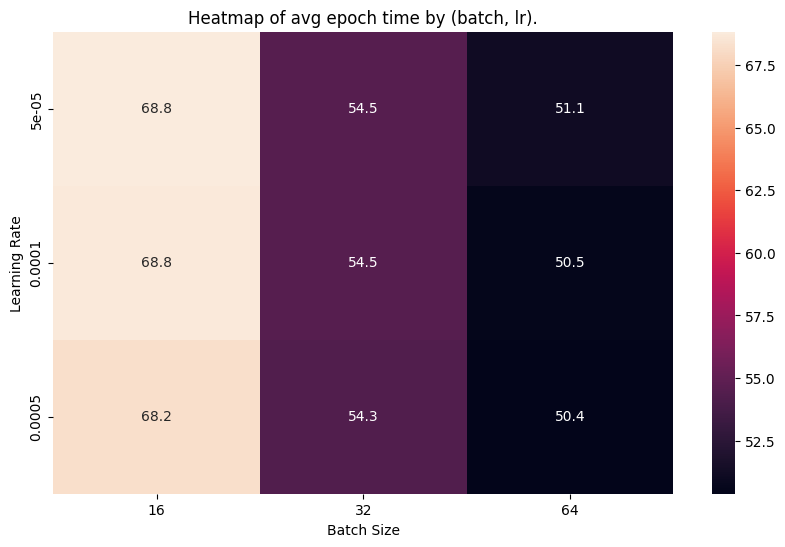

In [18]:
# C6 Results
import seaborn as sns

pivot_table = df.pivot(index='learning_rate', columns='batch_size', values='avg_epoch_time')

plt.figure(figsize=(10, 6))

sns.heatmap(
    pivot_table,
    annot=True,          
    fmt='.1f'         
)

plt.title('Heatmap of avg epoch time by (batch, lr).')
plt.xlabel('Batch Size')
plt.ylabel('Learning Rate')
plt.show()

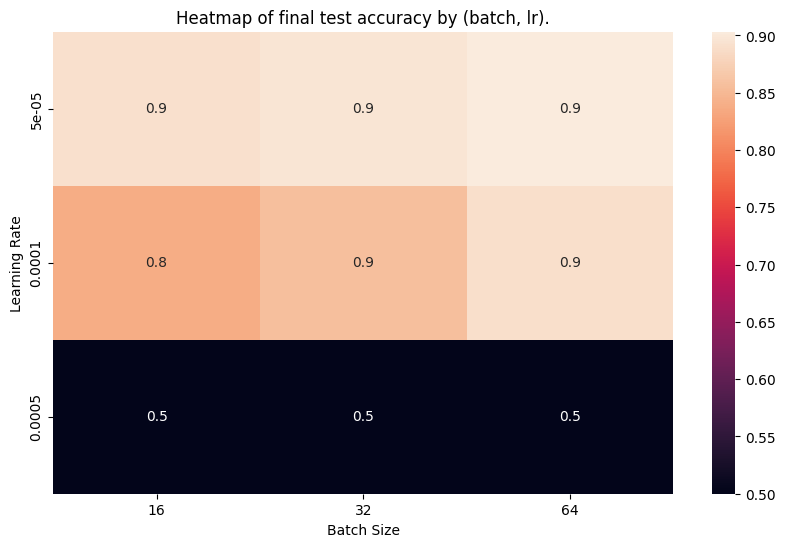

In [19]:
# C6 Results
pivot_table = df.pivot(index='learning_rate', columns='batch_size', values='final_test_acc')

plt.figure(figsize=(10, 6))

sns.heatmap(
    pivot_table,
    annot=True,          
    fmt='.1f'         
)

plt.title('Heatmap of final test accuracy by (batch, lr).')
plt.xlabel('Batch Size')
plt.ylabel('Learning Rate')
plt.show()



In [20]:
# C6 Results
# 2–3 sentence discussion of speed vs. accuracy vs. stability trade-offs.
"""
As batch size increases from 16 to 64, the average epoch time decreases, indicating more efficient and faster training per epoch. However, the larger learning rates above 0.00005 cause the training to become unstable as seen in the decrease in test accuracy and higher losses experienced for the higher learning rates. The best configuration that provides the best balance of stability, efficient training, and high accuracy seems to be a moderate to large batch size(32-64) and a low learning rate(< 0.0001).
"""

'\nAs batch size increases from 16 to 64, the average epoch time decreases, indicating more efficient and faster training per epoch. However, the larger learning rates above 0.00005 cause the training to become unstable as seen in the decrease in test accuracy and higher losses experienced for the higher learning rates. The best configuration that provides the best balance of stability, efficient training, and high accuracy seems to be a moderate to large batch size(32-64) and a low learning rate(< 0.0001).\n'

# W & B Link: https://wandb.ai/pkh2120-columbia-university/hpml_hw2/runs/wzk6p13e?nw=nwuserpkh2120
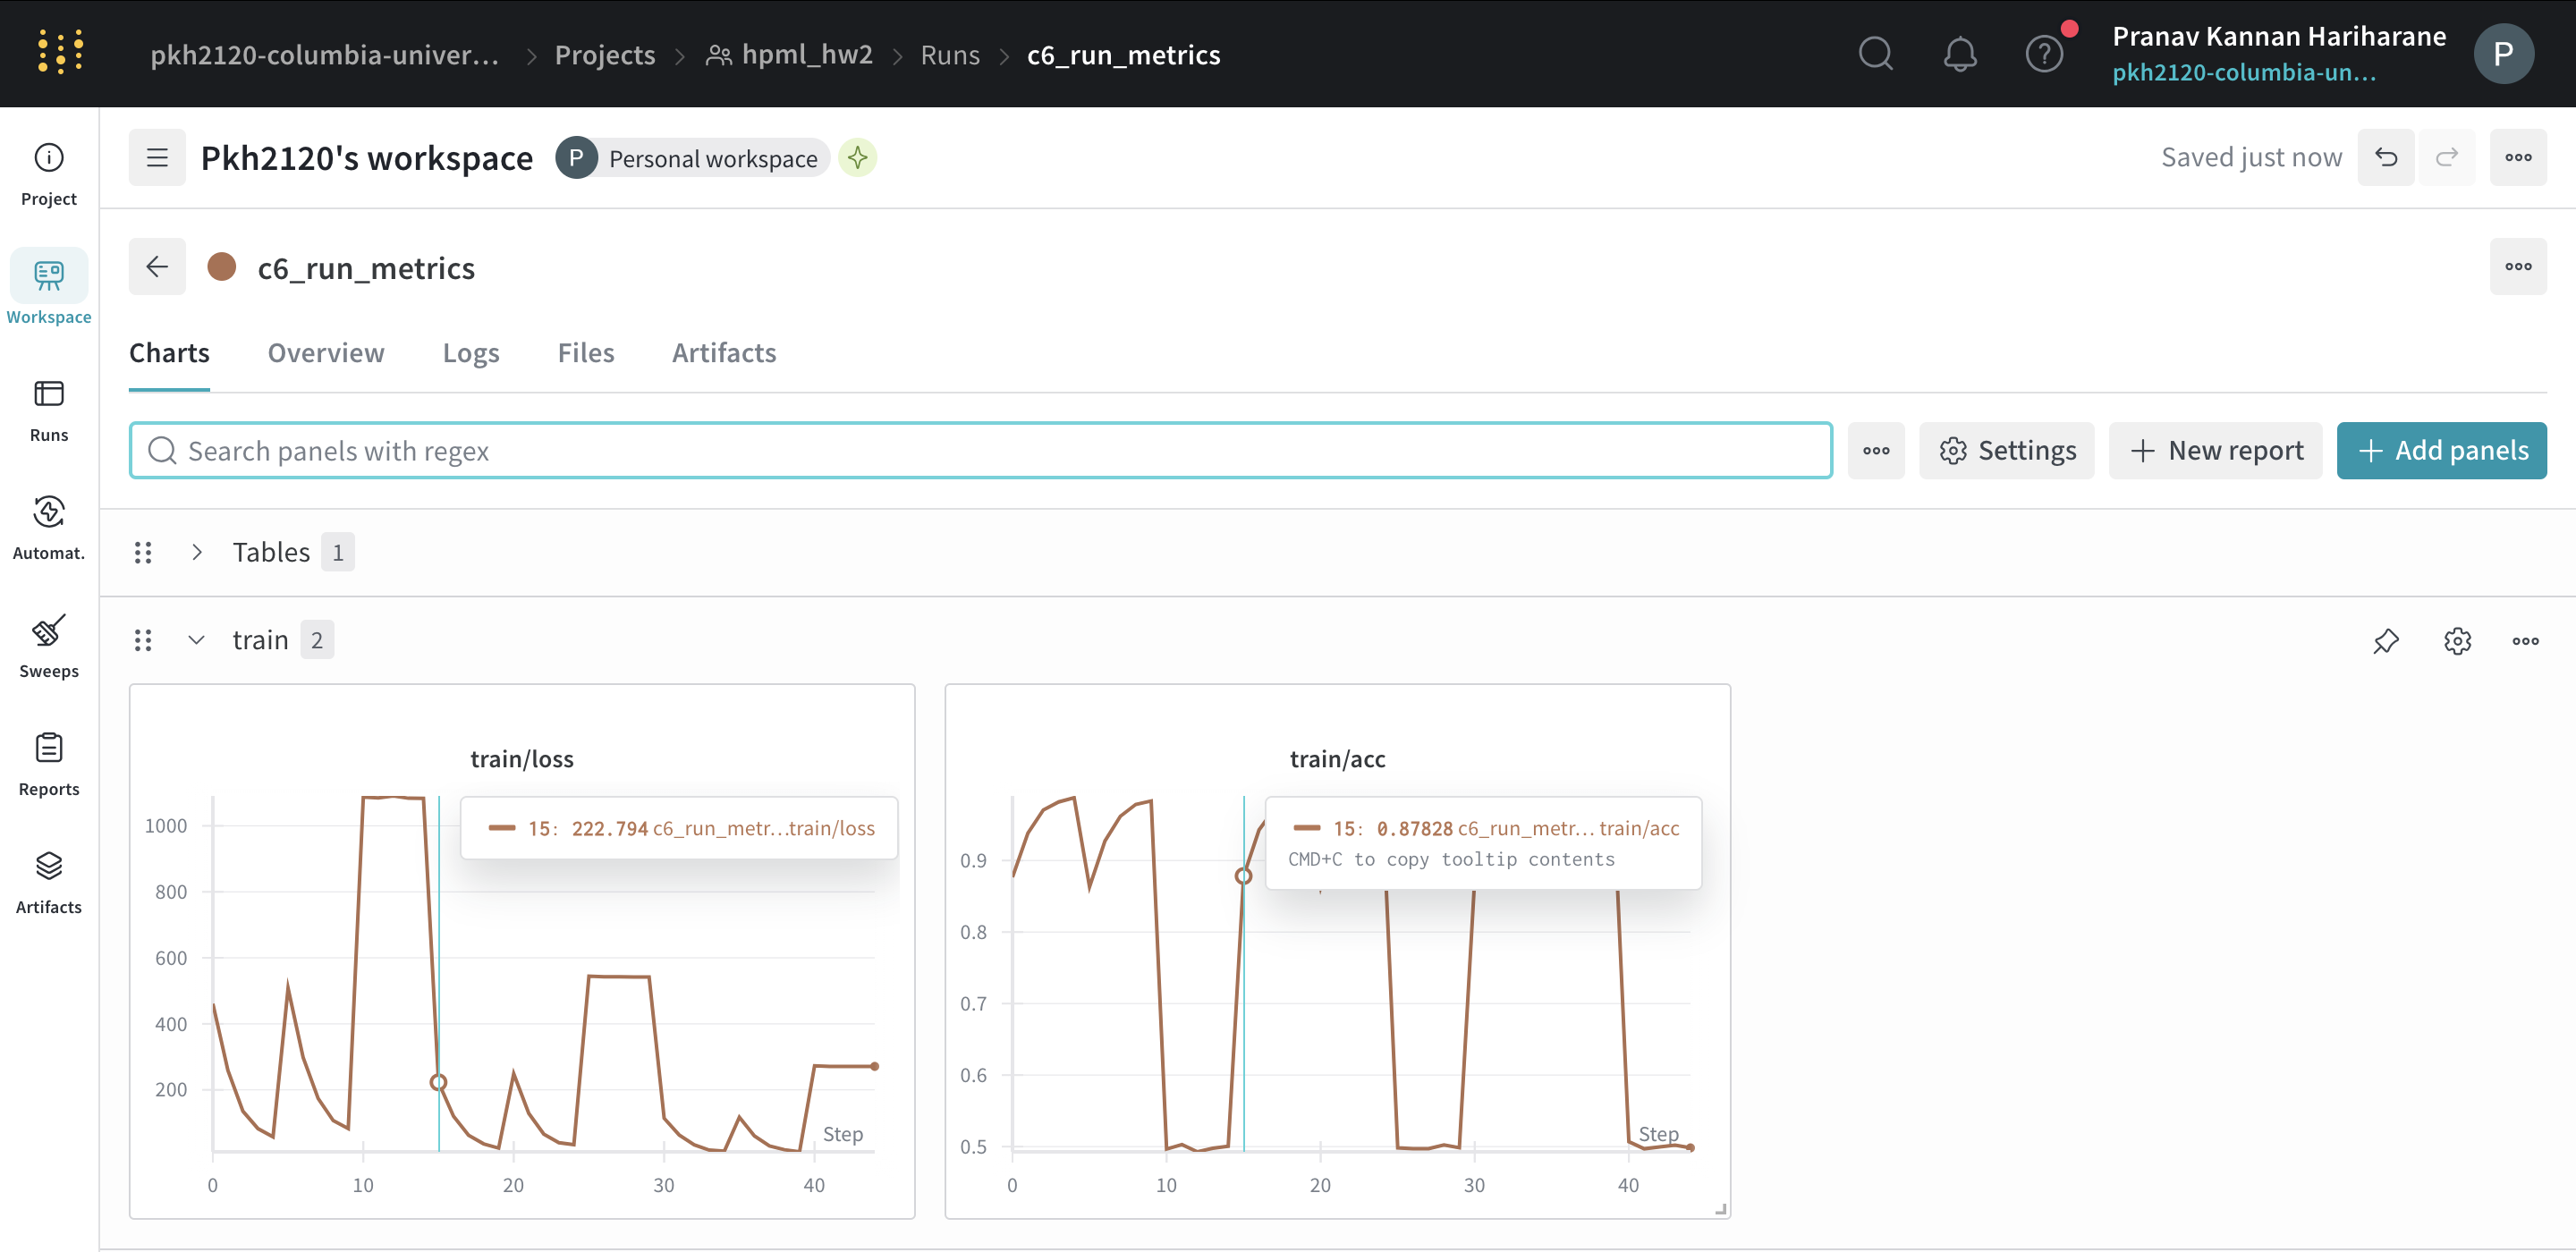
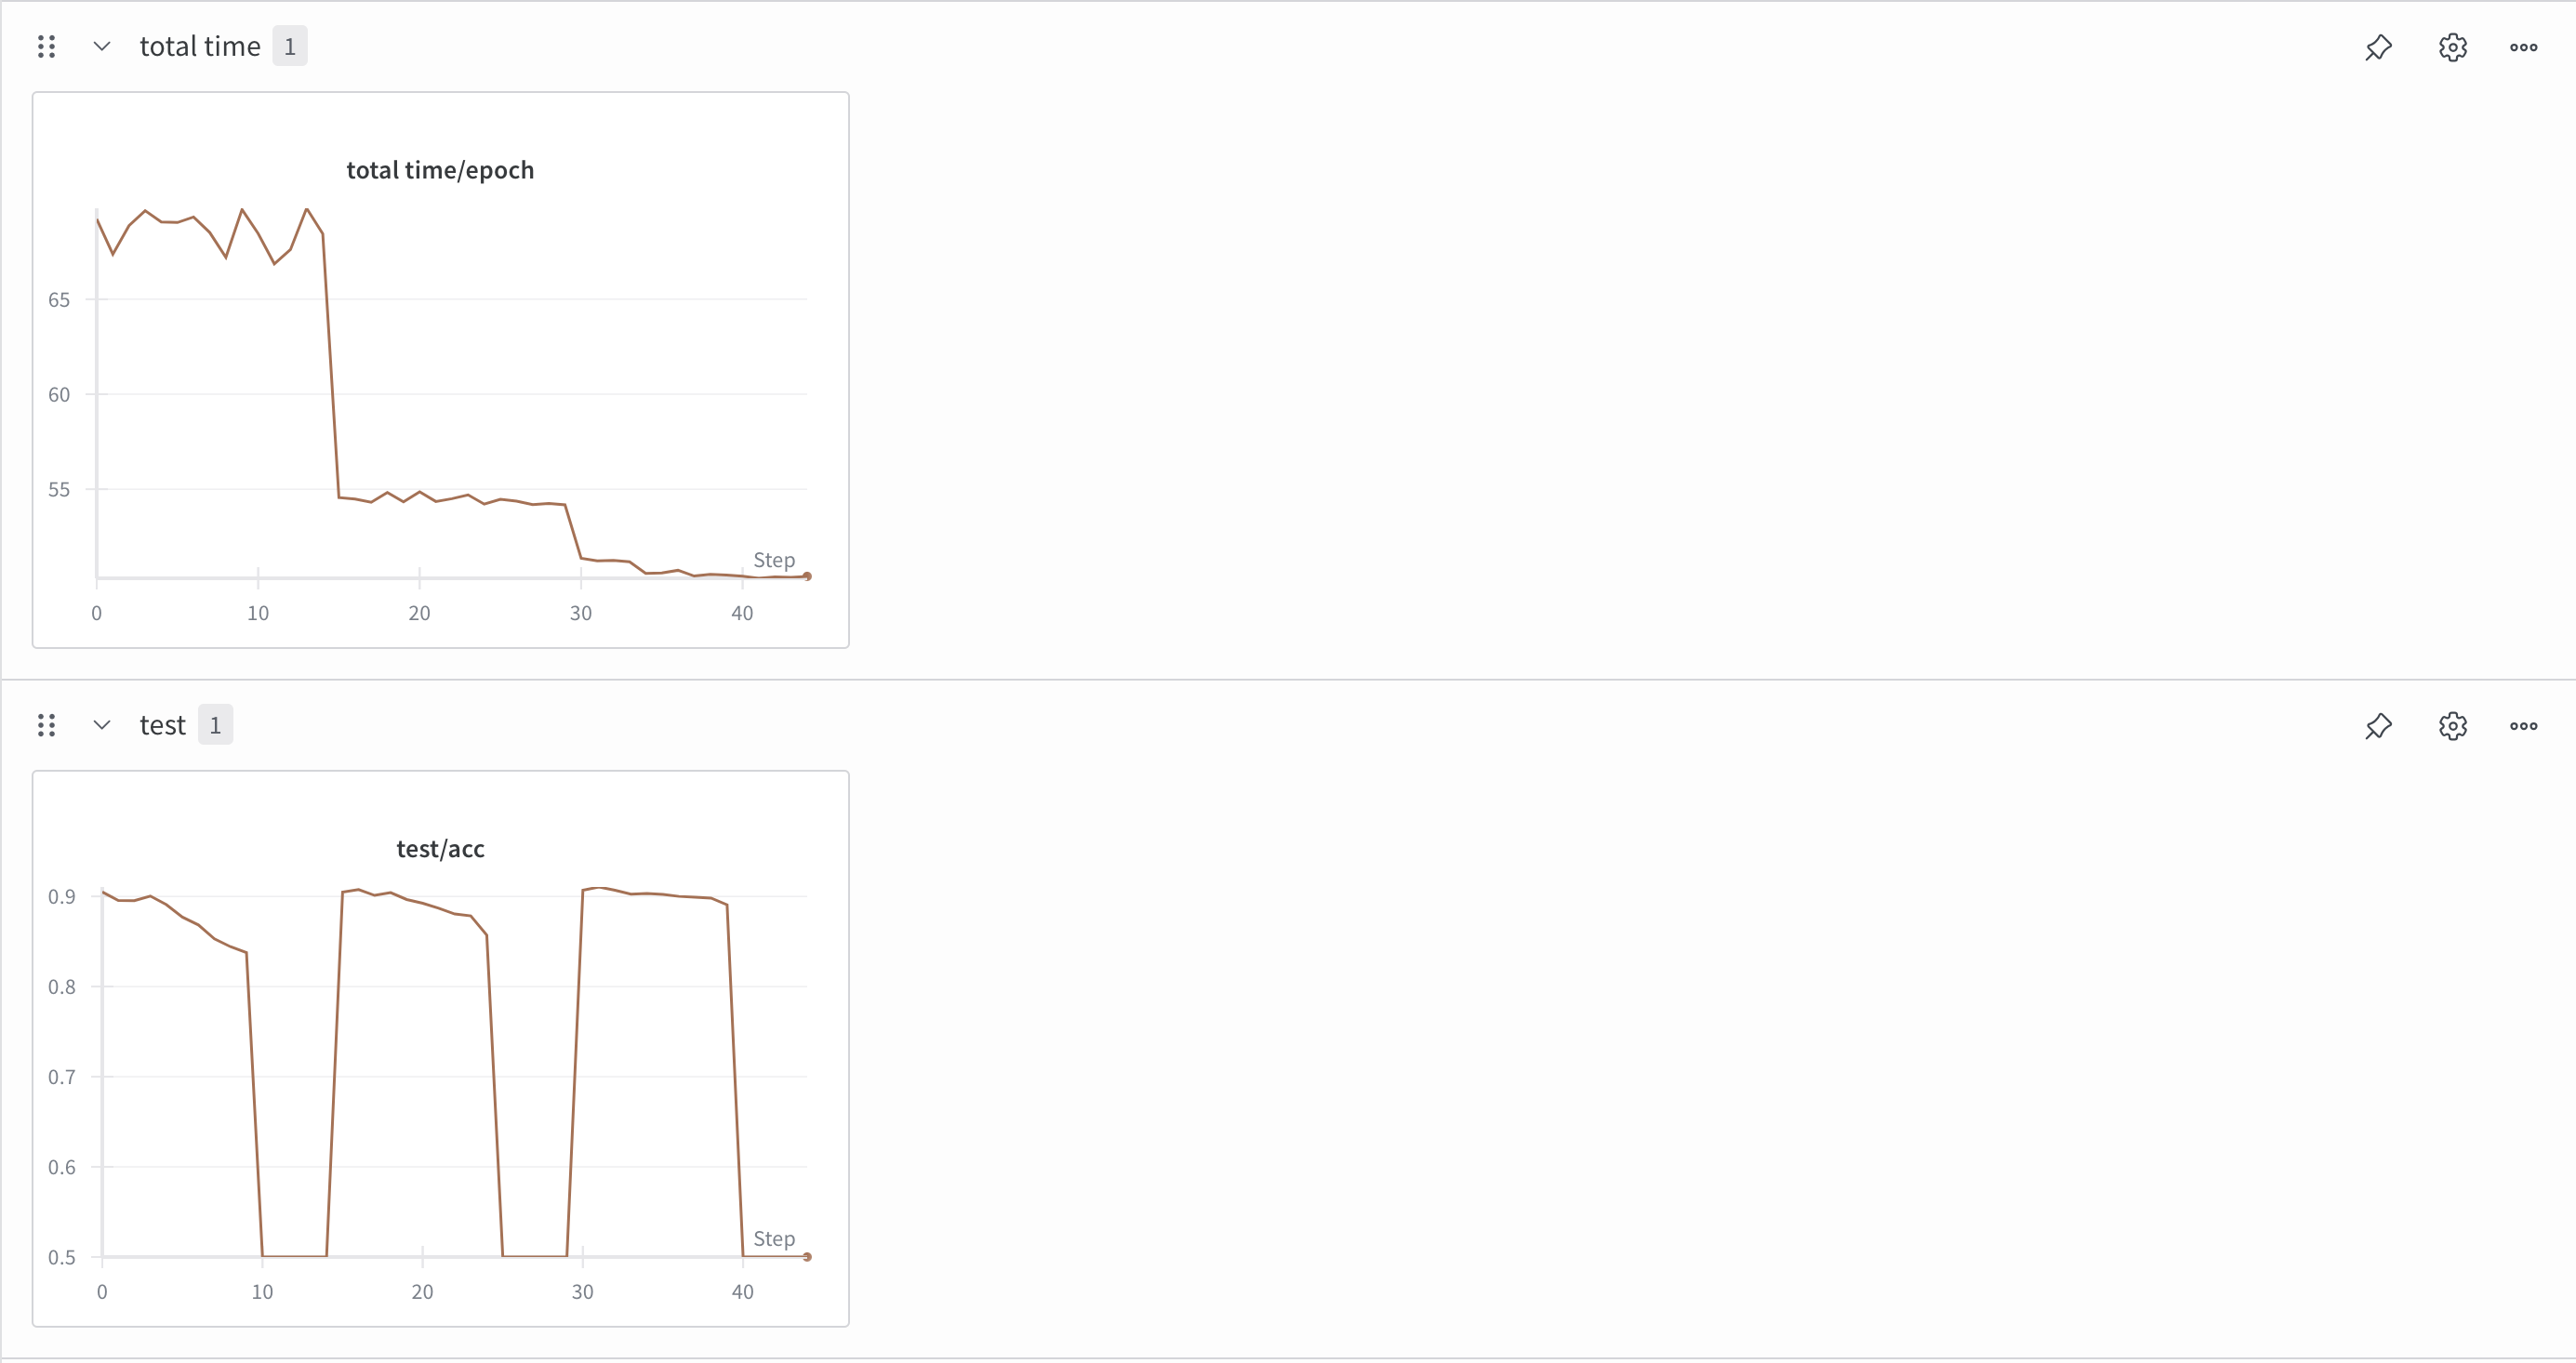
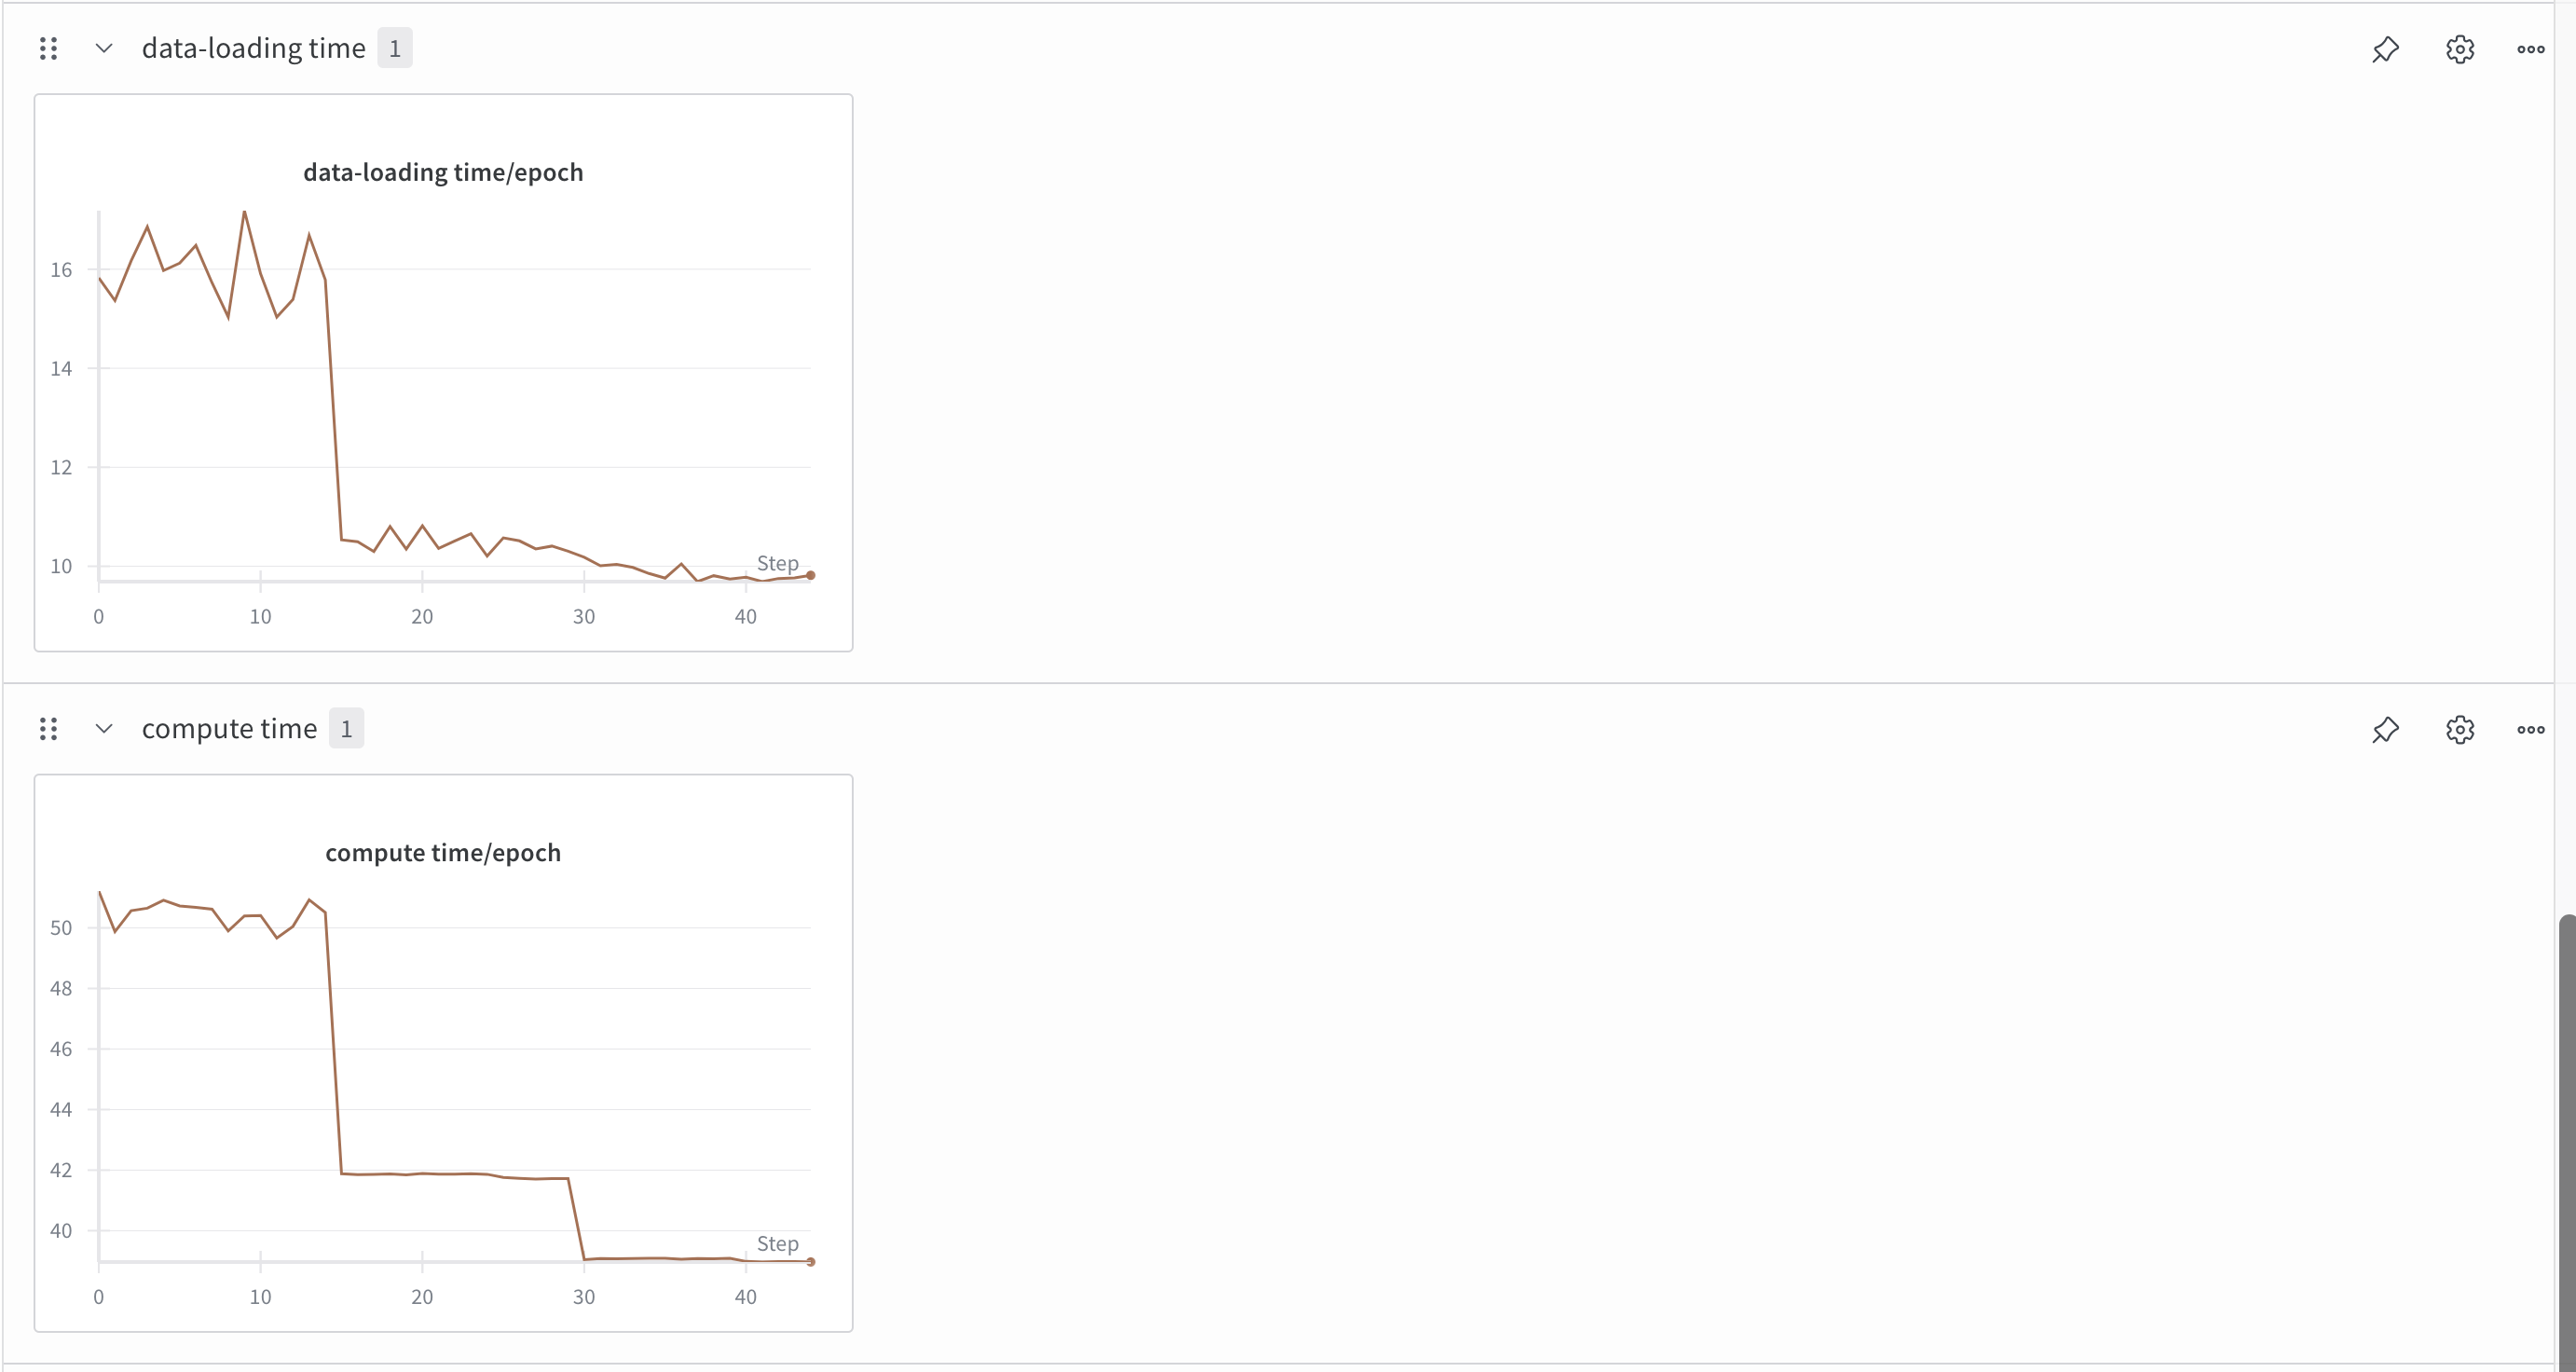

In [21]:
# C7 Results
wandb.init(project="hpml_hw2", name="c7_run_metrics")

configs = {
    'model_name': "distilbert-base-uncased",
    'max_len': 256,
    'batch_size': 32,
    "learning_rate": 1e-4,
    "optimizer": "AdamW", 
    "num_workers": 1,
    "epochs": 5, 
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    "compile_mode": False
}

metrics = {}

optims = ["SGD", "Adam", "AdamW"]
for op in optims:
    model = DistilBertForSequenceClassification.from_pretrained(
        configs['model_name']
    )
    model.to(configs['device'])

    optimizer = None
    if op == "SGD":
        configs["optimizer"] = "SGD"
        optimizer = optim.SGD(model.parameters(), lr=configs['learning_rate'])
    elif op == "Adam":
        configs["optimizer"] = "Adam"
        optimizer = optim.Adam(model.parameters(), lr=configs['learning_rate'])
    else:
        configs["optimizer"] = "AdamW"
        optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])
    
    train_dataloader = DataLoader(
        tokenized_datasets['train'],
        batch_size=configs['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=configs['num_workers']
    )
    test_dataloader = DataLoader(
        tokenized_datasets['test'],
        batch_size=configs['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=configs['num_workers']
    )
    wandb.config.update(configs)
    
    total_epoch_time = 0
    final_train_loss = 0
    final_test_acc = 0
    for epoch in range(1, configs['epochs'] + 1):
        epoch_start = time.time()
        train_loss, train_acc, data_loading_time, compute_time = train_epoch(
            model, train_dataloader, optimizer, configs['device']
        )
        epoch_end = time.time()
        test_acc = test(model, test_dataloader, configs['device'])
        total_time = epoch_end - epoch_start

        total_epoch_time += total_time
        final_train_loss = train_loss
        final_test_acc = test_acc
        final_train_acc = train_acc
        wandb.log({"train/loss": train_loss, "train/acc": train_acc, "test/acc": test_acc, "data-loading time/epoch": data_loading_time, "compute time/epoch": compute_time, "total time/epoch": total_time})
    
    metrics[op] = {
        'avg_epoch_time': total_epoch_time / configs['epochs'],
        'final_train_loss': final_train_loss,
        'final_train_acc': final_train_acc,
        'final_test_acc': final_test_acc
    }
    del model, optimizer, train_dataloader, test_dataloader
    torch.cuda.empty_cache()


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-strea

In [22]:
# C7 Results
rows = []
for op, stuff in metrics.items():
    row = {'Optimizer': op}
    row.update(stuff)
    rows.append(row)

df = pd.DataFrame(rows)
print("Table T7:")
wandb.log({"table_t7": df})
print(df)

Table T7:
  Optimizer  avg_epoch_time  final_train_loss  final_train_acc  final_test_acc
0       SGD       51.128797        520.813459          0.71604         0.80128
1      Adam       53.270664         28.840285          0.98808         0.87080
2     AdamW       53.809333         32.188346          0.98624         0.87280


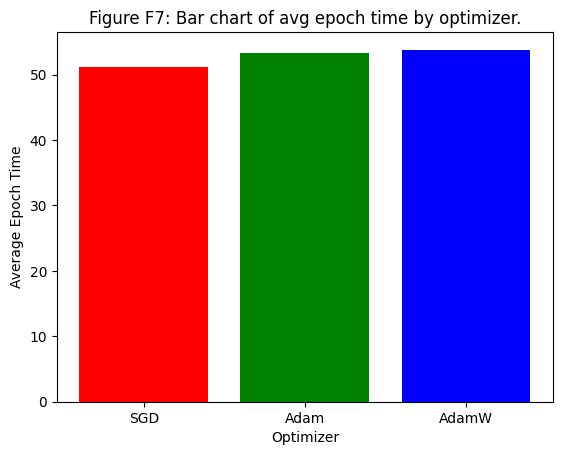

In [47]:
# C7 Results
categories = ["SGD", "Adam", "AdamW"]
values = [51.128797, 53.270664, 53.809333]
plt.bar(categories, values, color=['red', 'green', 'blue'])
plt.xlabel('Optimizer')
plt.ylabel('Average Epoch Time')
plt.title('Figure F7: Bar chart of avg epoch time by optimizer.')
plt.show()


In [52]:
# C7 Results
# 2 sentences: convergence/variance observations.
"""
The Adam and AdamW optimizers converge much better than SGD since they achieve a significantly lower final training loss and higher accuracies. Between Adam and AdamW, AdamW achieves a slightly better final test set accuracy which suggests that it provides lower variance and more stable convergence.
"""


'\nThe Adam and AdamW optimizers converge much better than SGD since they achieve a significantly lower final training loss and higher accuracies. Between Adam and AdamW, AdamW achieves a slightly better final test set accuracy which suggests that it provides lower variance and more stable convergence.\n'

# W & B Link: https://wandb.ai/pkh2120-columbia-university/hpml_hw2/runs/3sn56xxq?nw=nwuserpkh2120
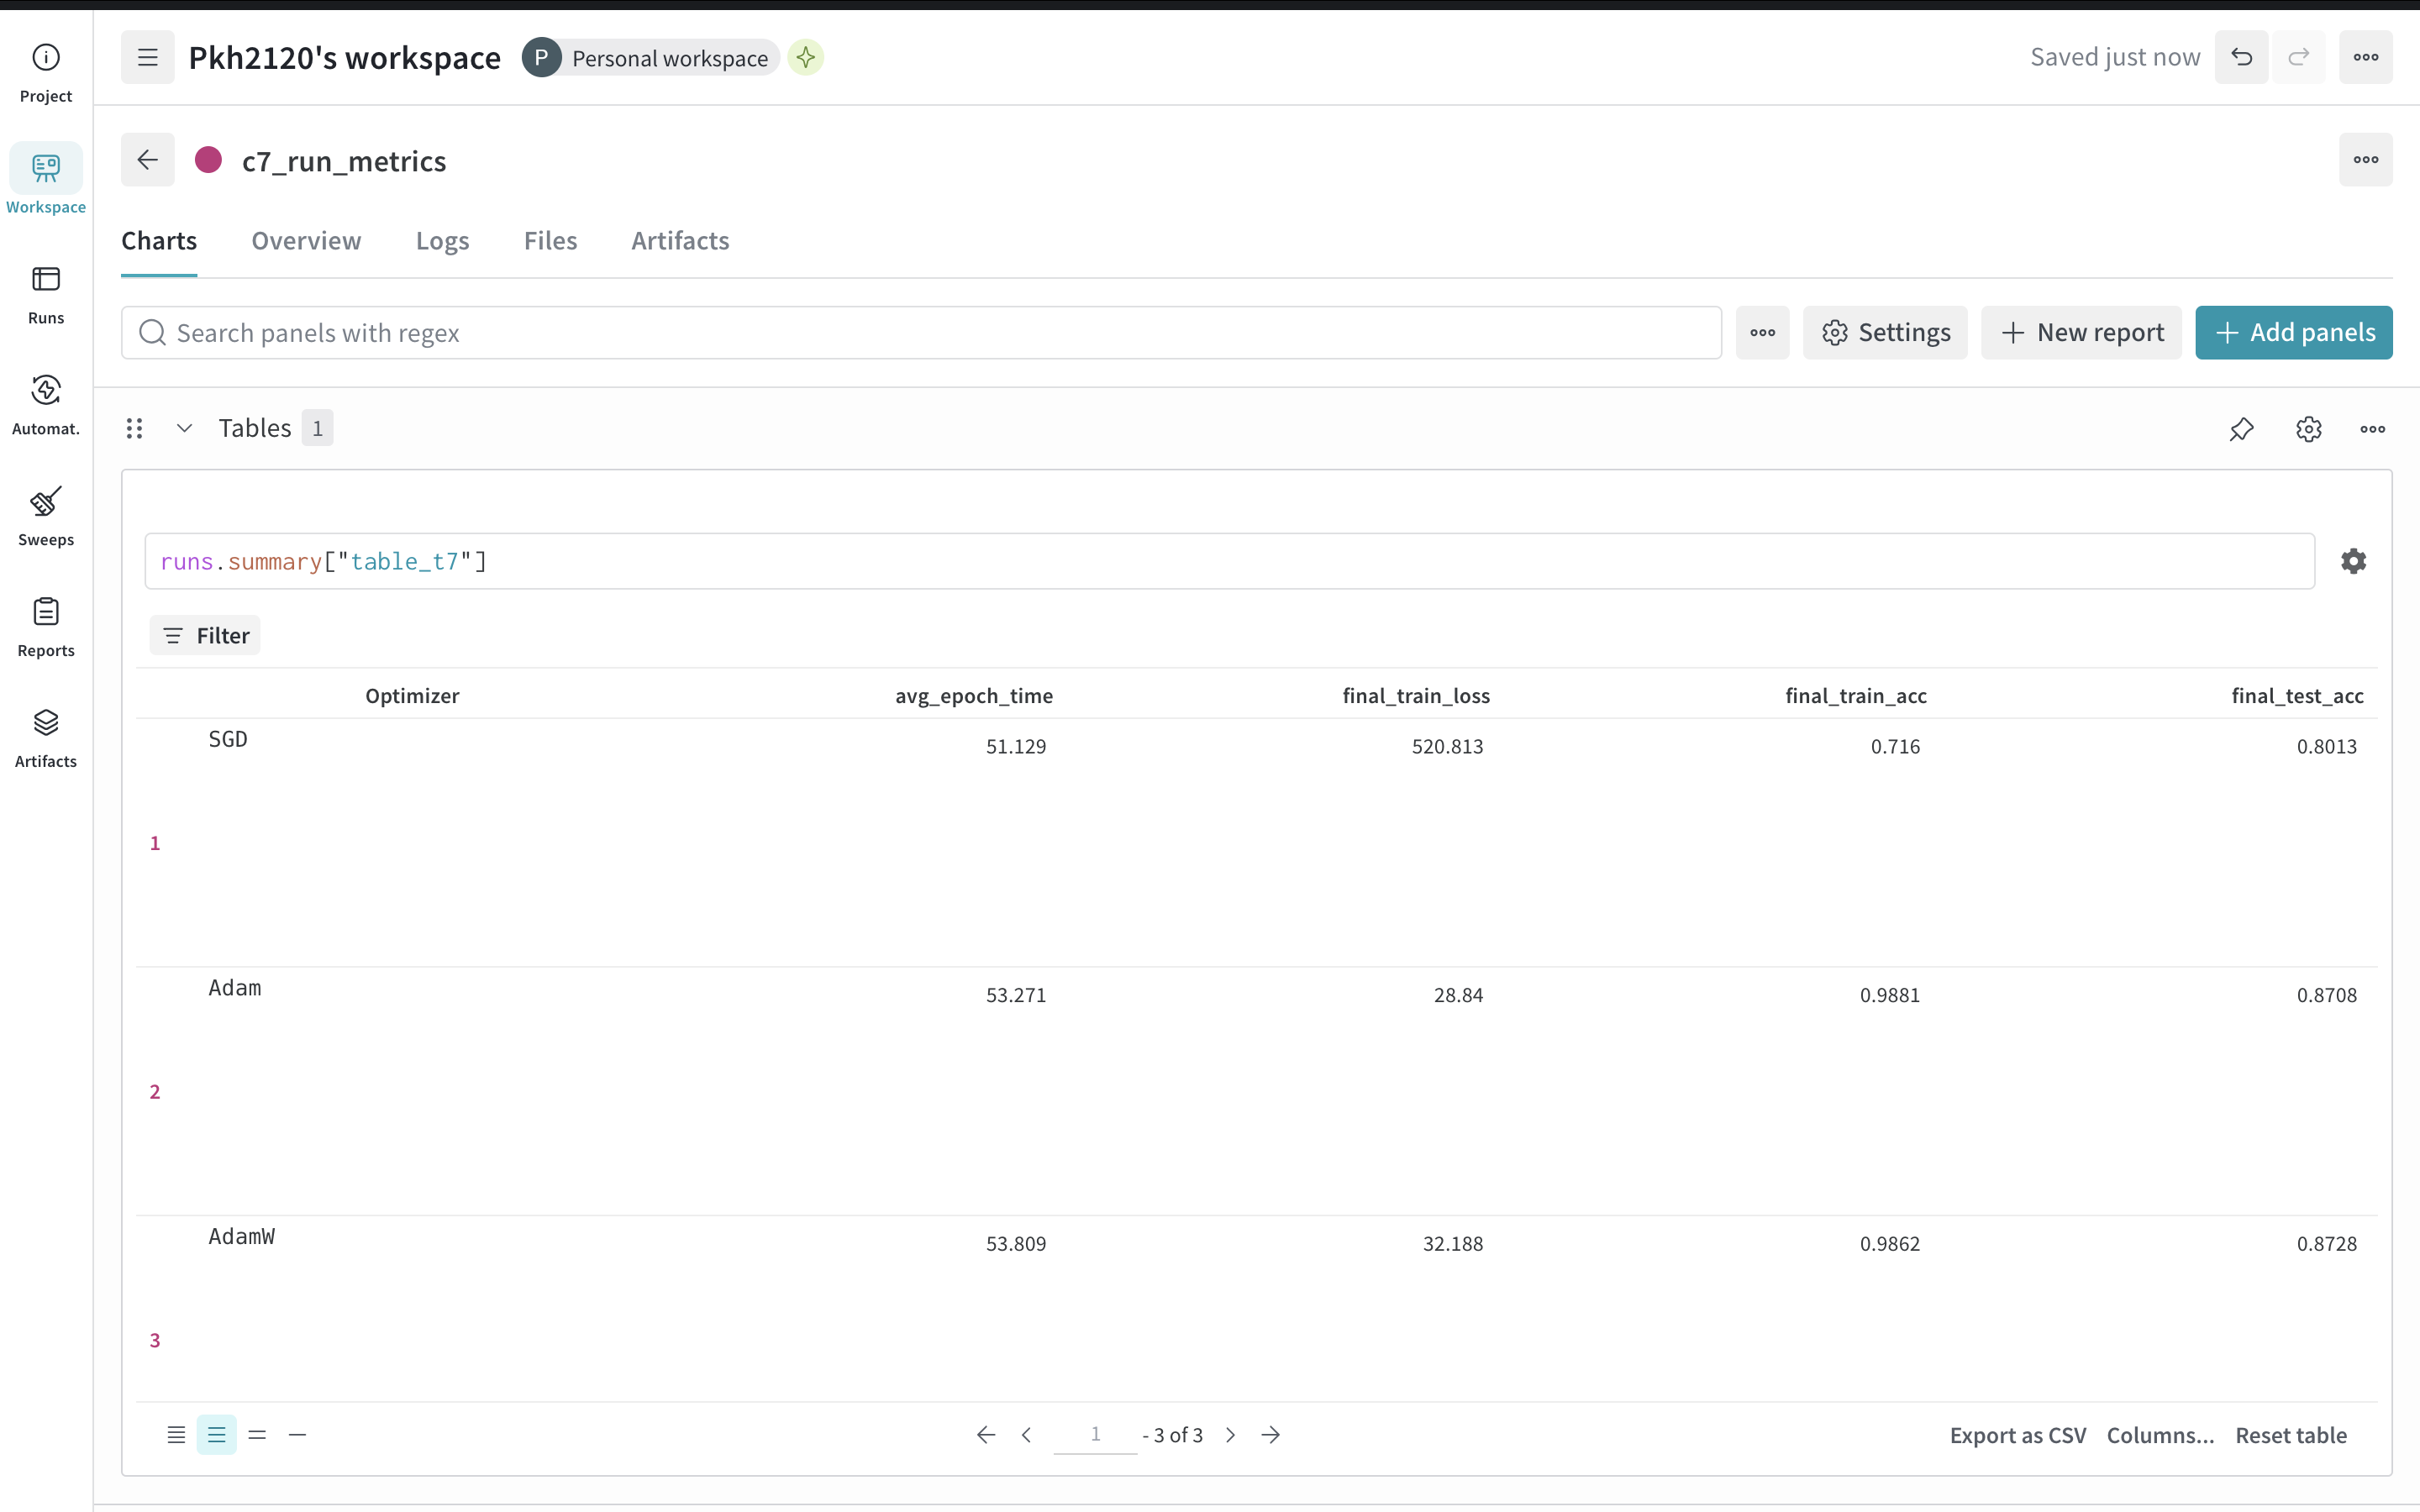
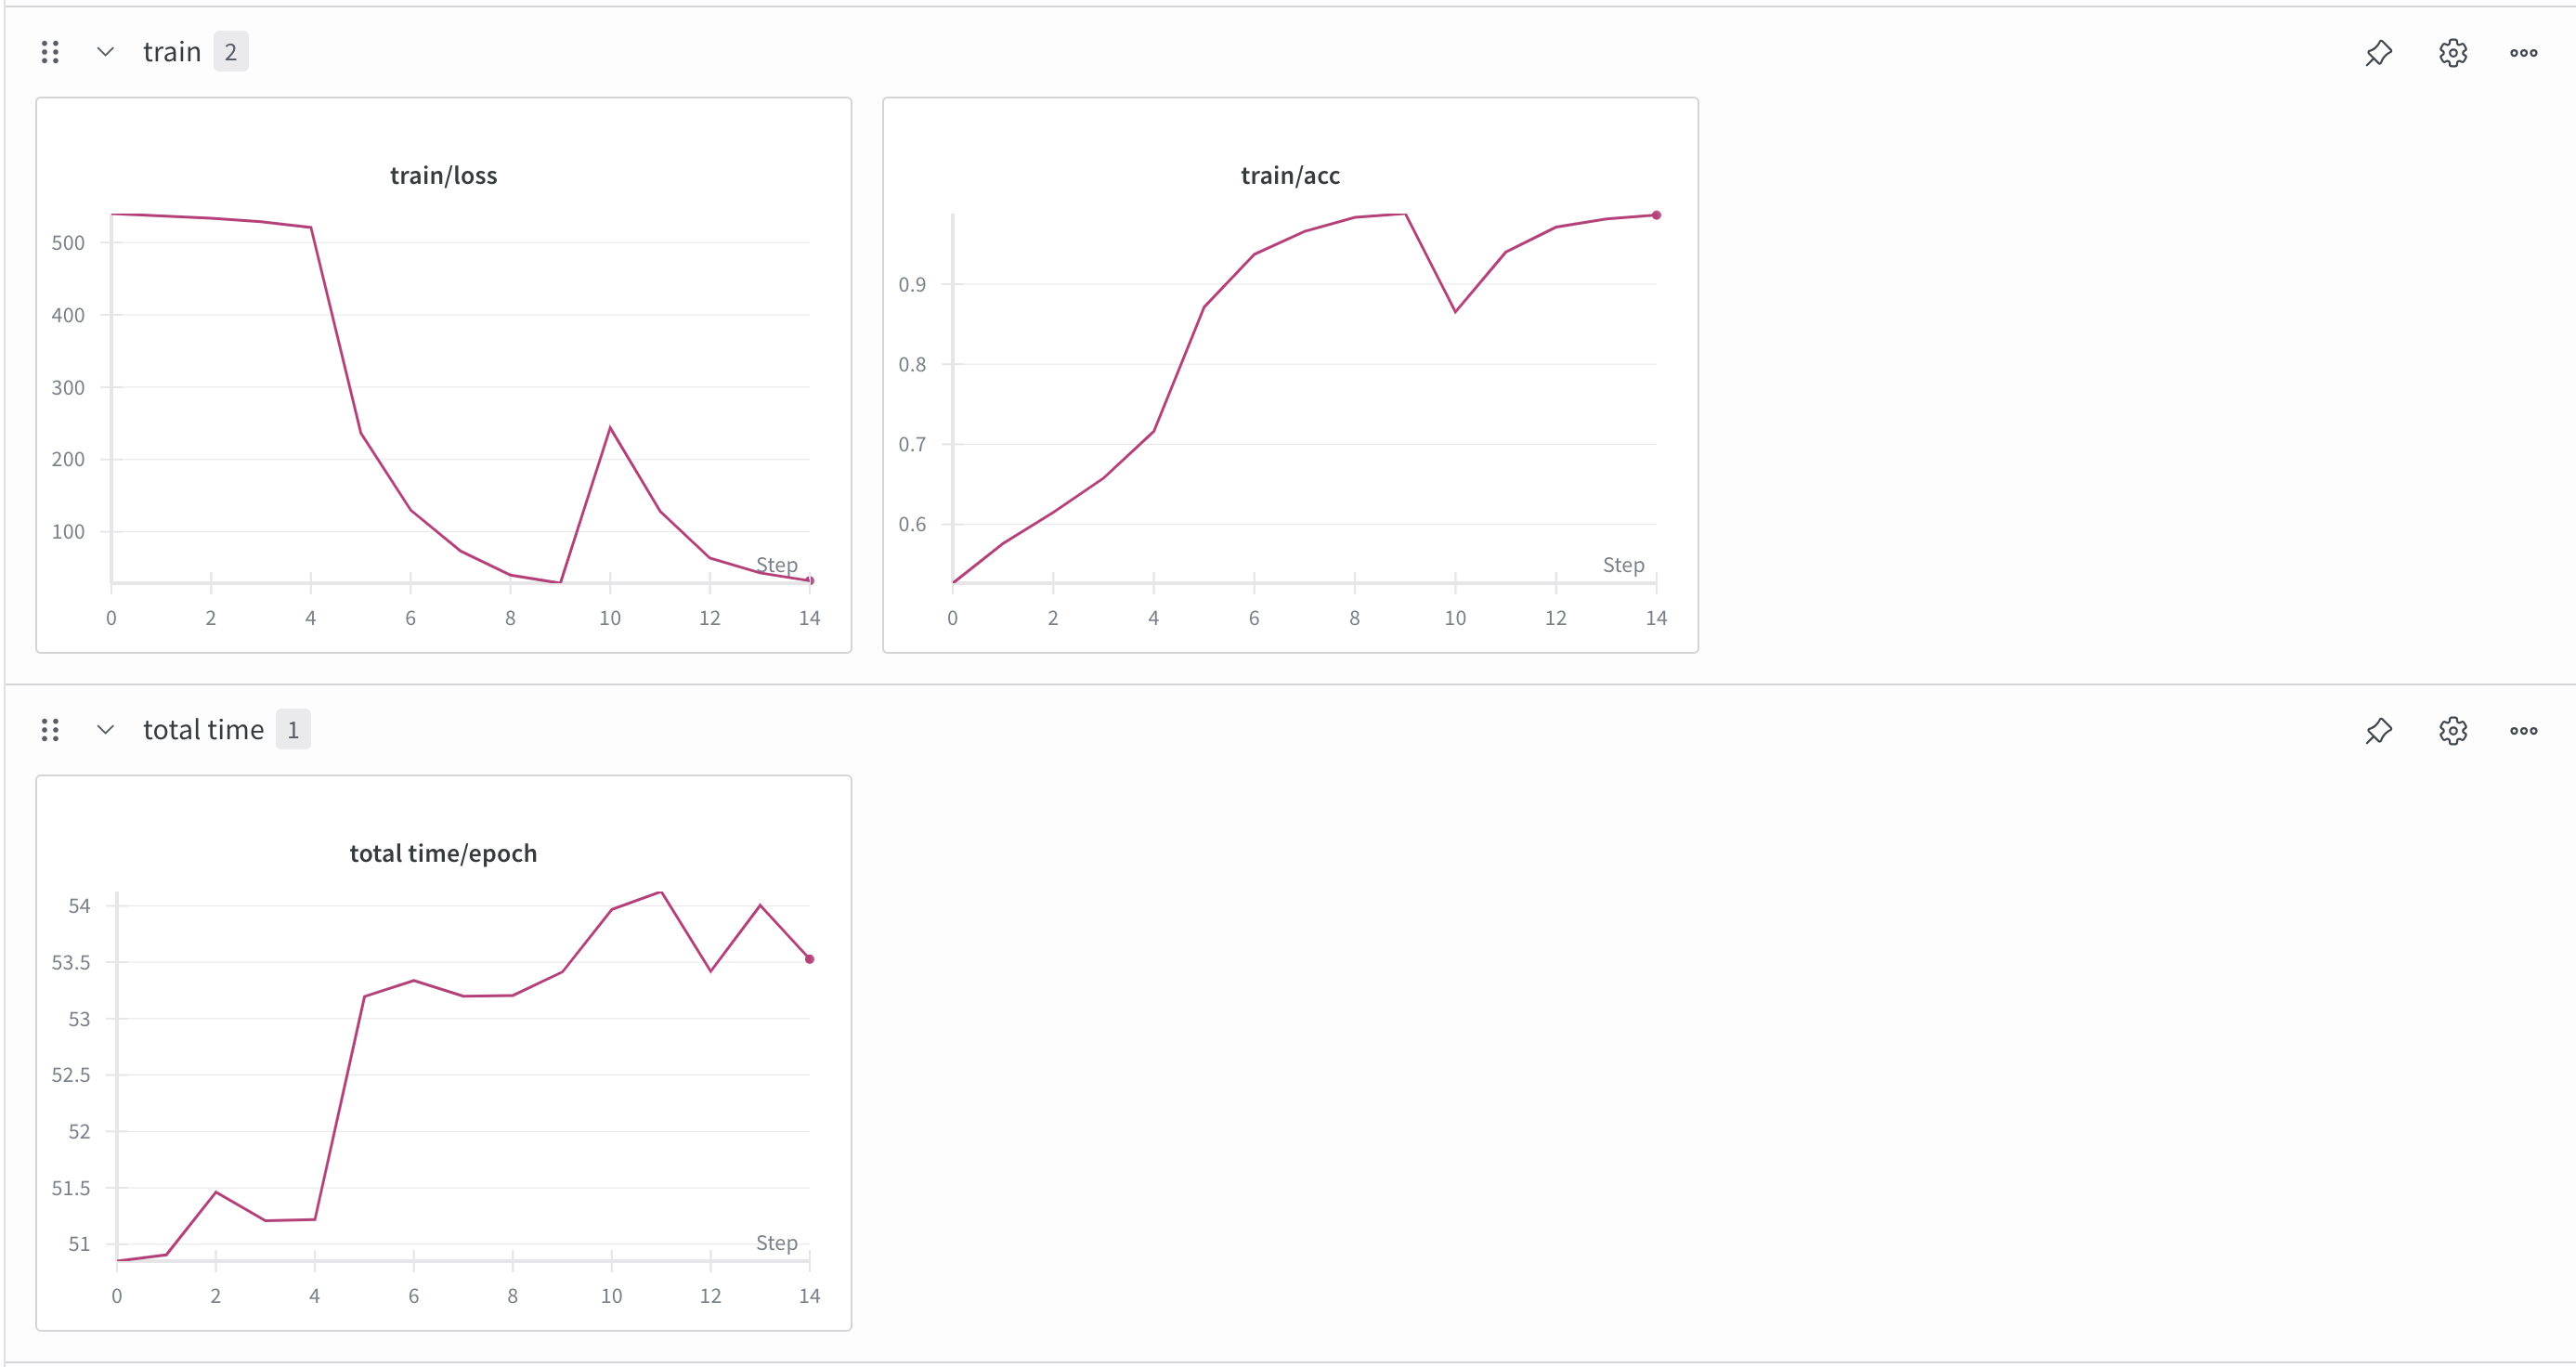
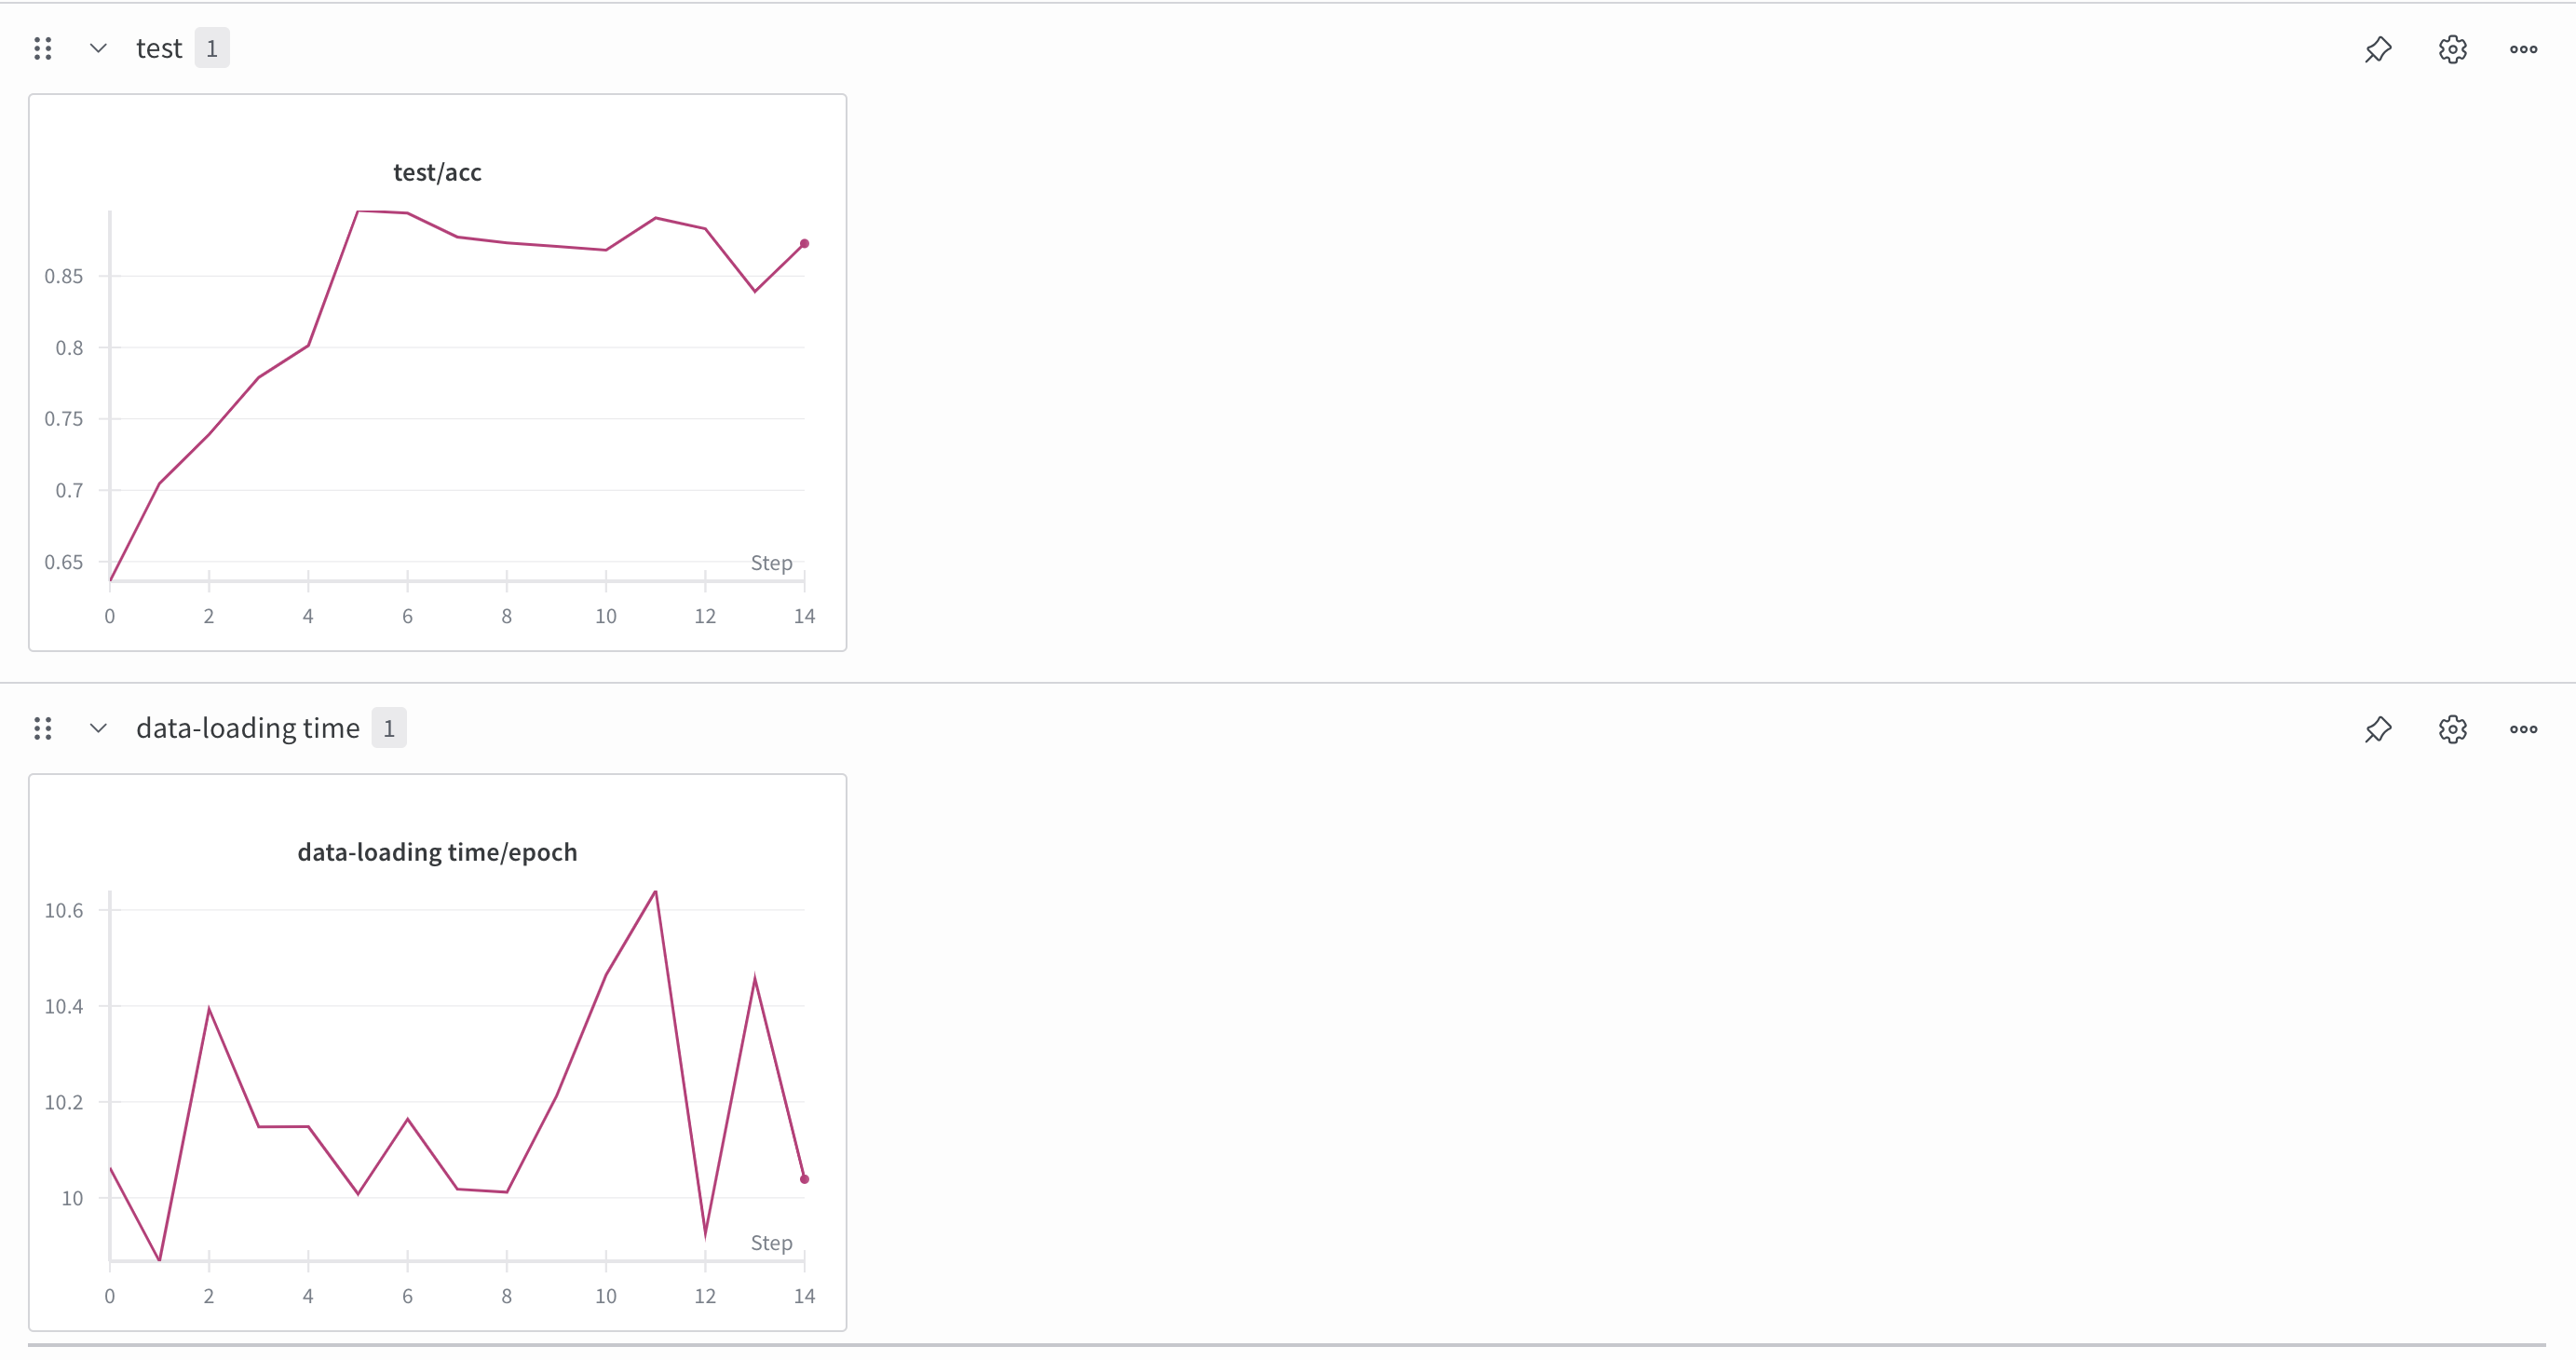
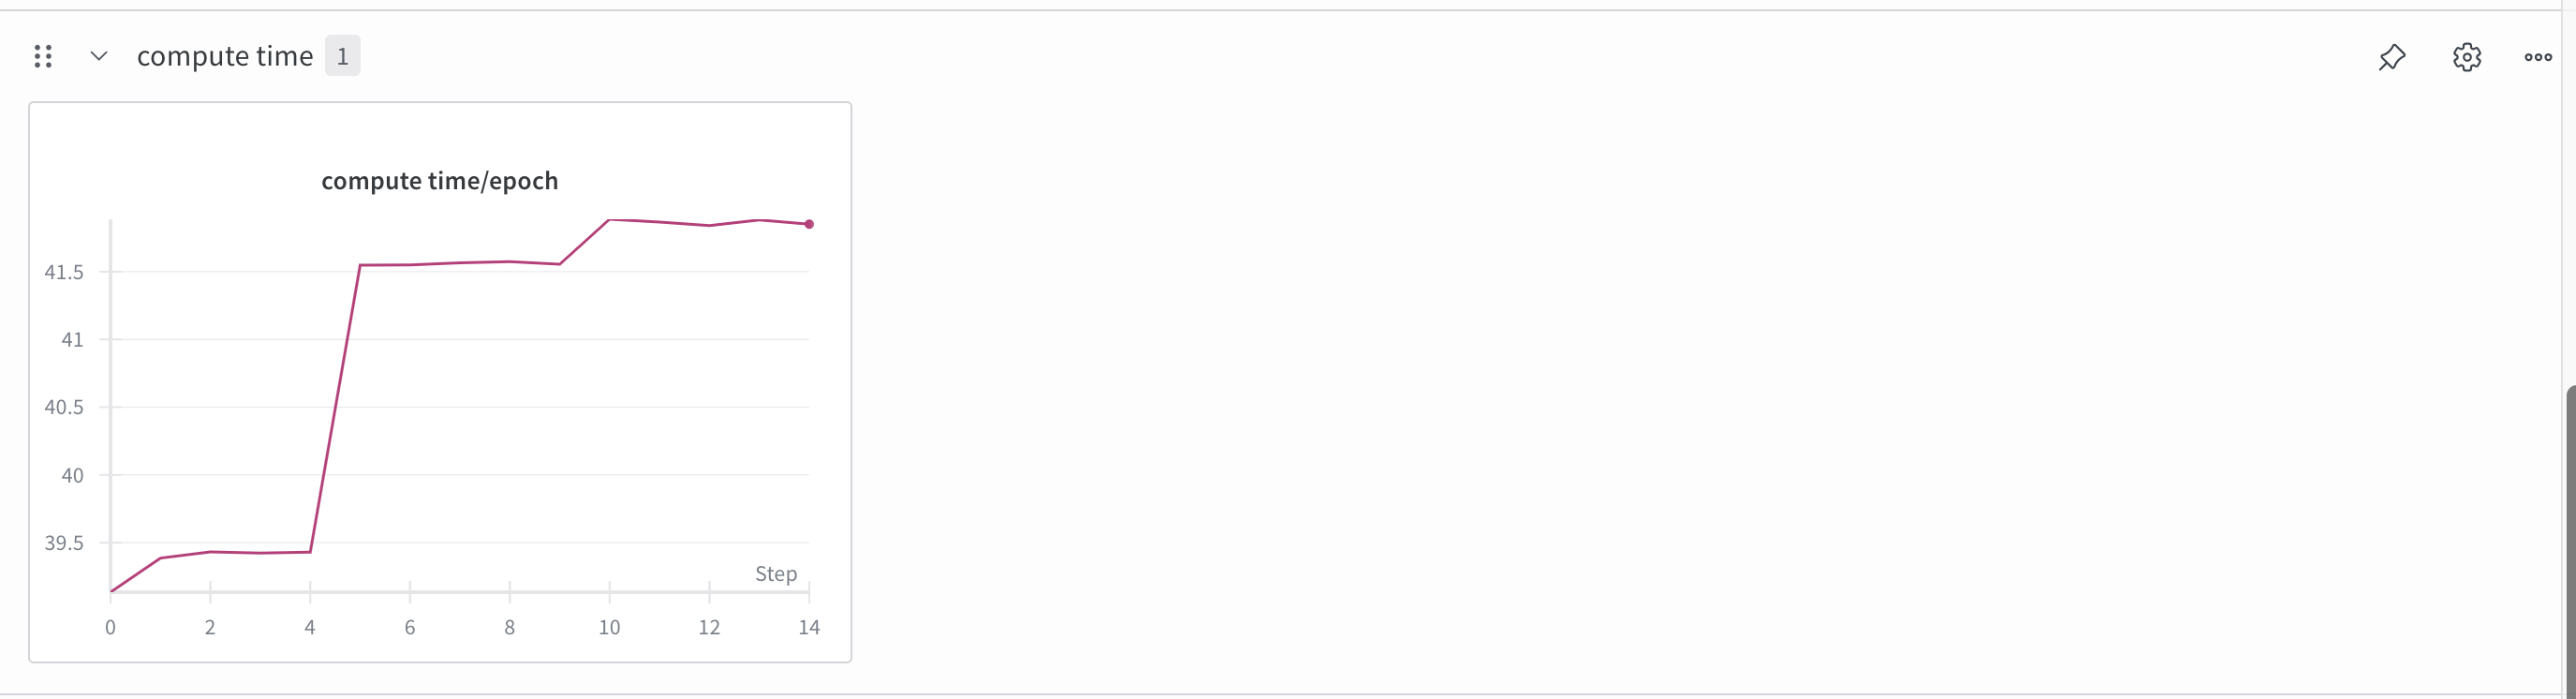

In [24]:
# C8 torch.compile
wandb.init(project="hpml_hw2", name="c8_run_metrics")

configs = {
    'model_name': "distilbert-base-uncased",
    'max_len': 256,
    'batch_size': 32,
    "learning_rate": 1e-4,
    "optimizer": "AdamW", 
    "num_workers": 1,
    "epochs": 10, 
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    "compile_mode": False
}

metrics = {}

model = DistilBertForSequenceClassification.from_pretrained(
    configs['model_name']
)
model.to(configs['device'])
optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])
train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=configs['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=configs['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
wandb.config.update(configs)
total_epoch_time_last_5 = 0
first_epoch_time = 0
for epoch in range(1, configs['epochs'] + 1):
    epoch_start = time.time()
    train_loss, train_acc, data_loading_time, compute_time = train_epoch(
        model, train_dataloader, optimizer, configs['device']
    )
    epoch_end = time.time()
    test_acc = test(model, test_dataloader, configs['device'])
    total_time = epoch_end - epoch_start
    wandb.log({"train/loss": train_loss, "train/acc": train_acc, "test/acc": test_acc, "data-loading time/epoch": data_loading_time, "compute time/epoch": compute_time, "total time/epoch": total_time})

    if epoch >= 6:
        total_epoch_time_last_5 += total_time
    elif epoch == 1:
        first_epoch_time = total_time
  
del model, optimizer, train_dataloader, test_dataloader
torch.cuda.empty_cache()
metrics["Eager"] = {
    "first_epoch_time": first_epoch_time,
    "avg_epoch_time": total_epoch_time_last_5 / 5
}

model = DistilBertForSequenceClassification.from_pretrained(
    configs['model_name']
)
model.to(configs['device'])
model = torch.compile(model, backend="inductor")
optimizer = optim.AdamW(model.parameters(), lr=configs['learning_rate'])
train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=configs['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=configs['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=configs['num_workers']
)
configs["compile_mode"] = True
wandb.config.update(configs)
total_epoch_time_last_5 = 0
first_epoch_time = 0
for epoch in range(1, configs['epochs'] + 1):
    epoch_start = time.time()
    train_loss, train_acc, data_loading_time, compute_time = train_epoch(
        model, train_dataloader, optimizer, configs['device']
    )
    epoch_end = time.time()
    test_acc = test(model, test_dataloader, configs['device'])
    total_time = epoch_end - epoch_start
    wandb.log({"train/loss": train_loss, "train/acc": train_acc, "test/acc": test_acc, "data-loading time/epoch": data_loading_time, "compute time/epoch": compute_time, "total time/epoch": total_time})

    if epoch >= 6:
        total_epoch_time_last_5 += total_time
    elif epoch == 1:
        first_epoch_time = total_time
  
del model, optimizer, train_dataloader, test_dataloader
torch.cuda.empty_cache()
metrics["Compile"] = {
    "first_epoch_time": first_epoch_time,
    "avg_epoch_time": total_epoch_time_last_5 / 5
}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
W1026 17:20:15.758000 29619 site-packages/torch/fx/experimental/symbolic_shapes.py:6833] [0/2] _maybe_guard_rel() was called on non-relation expression Eq(s43, 1) | Eq(s72, s43)
W1026 17:20:22.330000 29619 site-packages/torch/fx/experimental/symbolic_shapes.py:6833] [0/3] _maybe_guard_rel() wa

In [25]:
# C8 Results

rows = []
for mode, stuff in metrics.items():
    row = {'Mode': mode}
    row.update(stuff)
    rows.append(row)

df = pd.DataFrame(rows)
print("Table T8:")
wandb.log({"table_t8": df})
print(df)

Table T8:
      Mode  first_epoch_time  avg_epoch_time
0    Eager         53.350641       53.771597
1  Compile         58.237342       51.174216


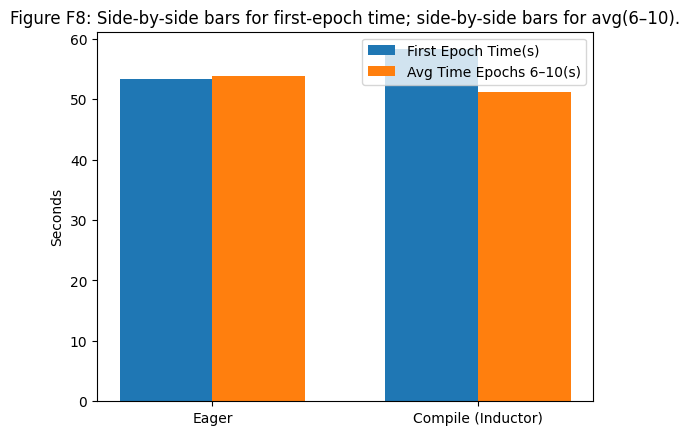

In [26]:
# C8 Results

modes = ['Eager', 'Compile (Inductor)']
first_epoch_times = [metrics["Eager"]["first_epoch_time"], metrics["Compile"]["first_epoch_time"]]
avg_epoch_times = [metrics["Eager"]["avg_epoch_time"], metrics["Compile"]["avg_epoch_time"]]

x = np.arange(len(modes))  
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, first_epoch_times, width, label='First Epoch Time(s)')
rects2 = ax.bar(x + width/2, avg_epoch_times, width, label='Avg Time Epochs 6–10(s)')

ax.set_ylabel('Seconds')
ax.set_title('Figure F8: Side-by-side bars for first-epoch time; side-by-side bars for avg(6–10).')
ax.set_xticks(x)
ax.set_xticklabels(modes)
ax.legend()
plt.show()

In [27]:
# C8 Results
# 1–2 sentences: why the first compiled epoch is slower and later epochs faster
"""
In compile(inductor) mode the first epoch is slower because PyTorch captures and compiles the model's computation graph into optimized code in this epoch which adds some extra overhead to the overall runtime for the epoch. The later epochs are faster since they can just reuse the optimized code created in the first epoch.
"""

"\nIn compile(inductor) mode the first epoch is slower because PyTorch captures and compiles the model's computation graph into optimized code in this epoch which adds some extra overhead to the overall runtime for the epoch. The later epochs are faster since they can just reuse the optimized code created in the first epoch.\n"

# W & B Link: https://wandb.ai/pkh2120-columbia-university/hpml_hw2/runs/wvpclauf?nw=nwuserpkh2120
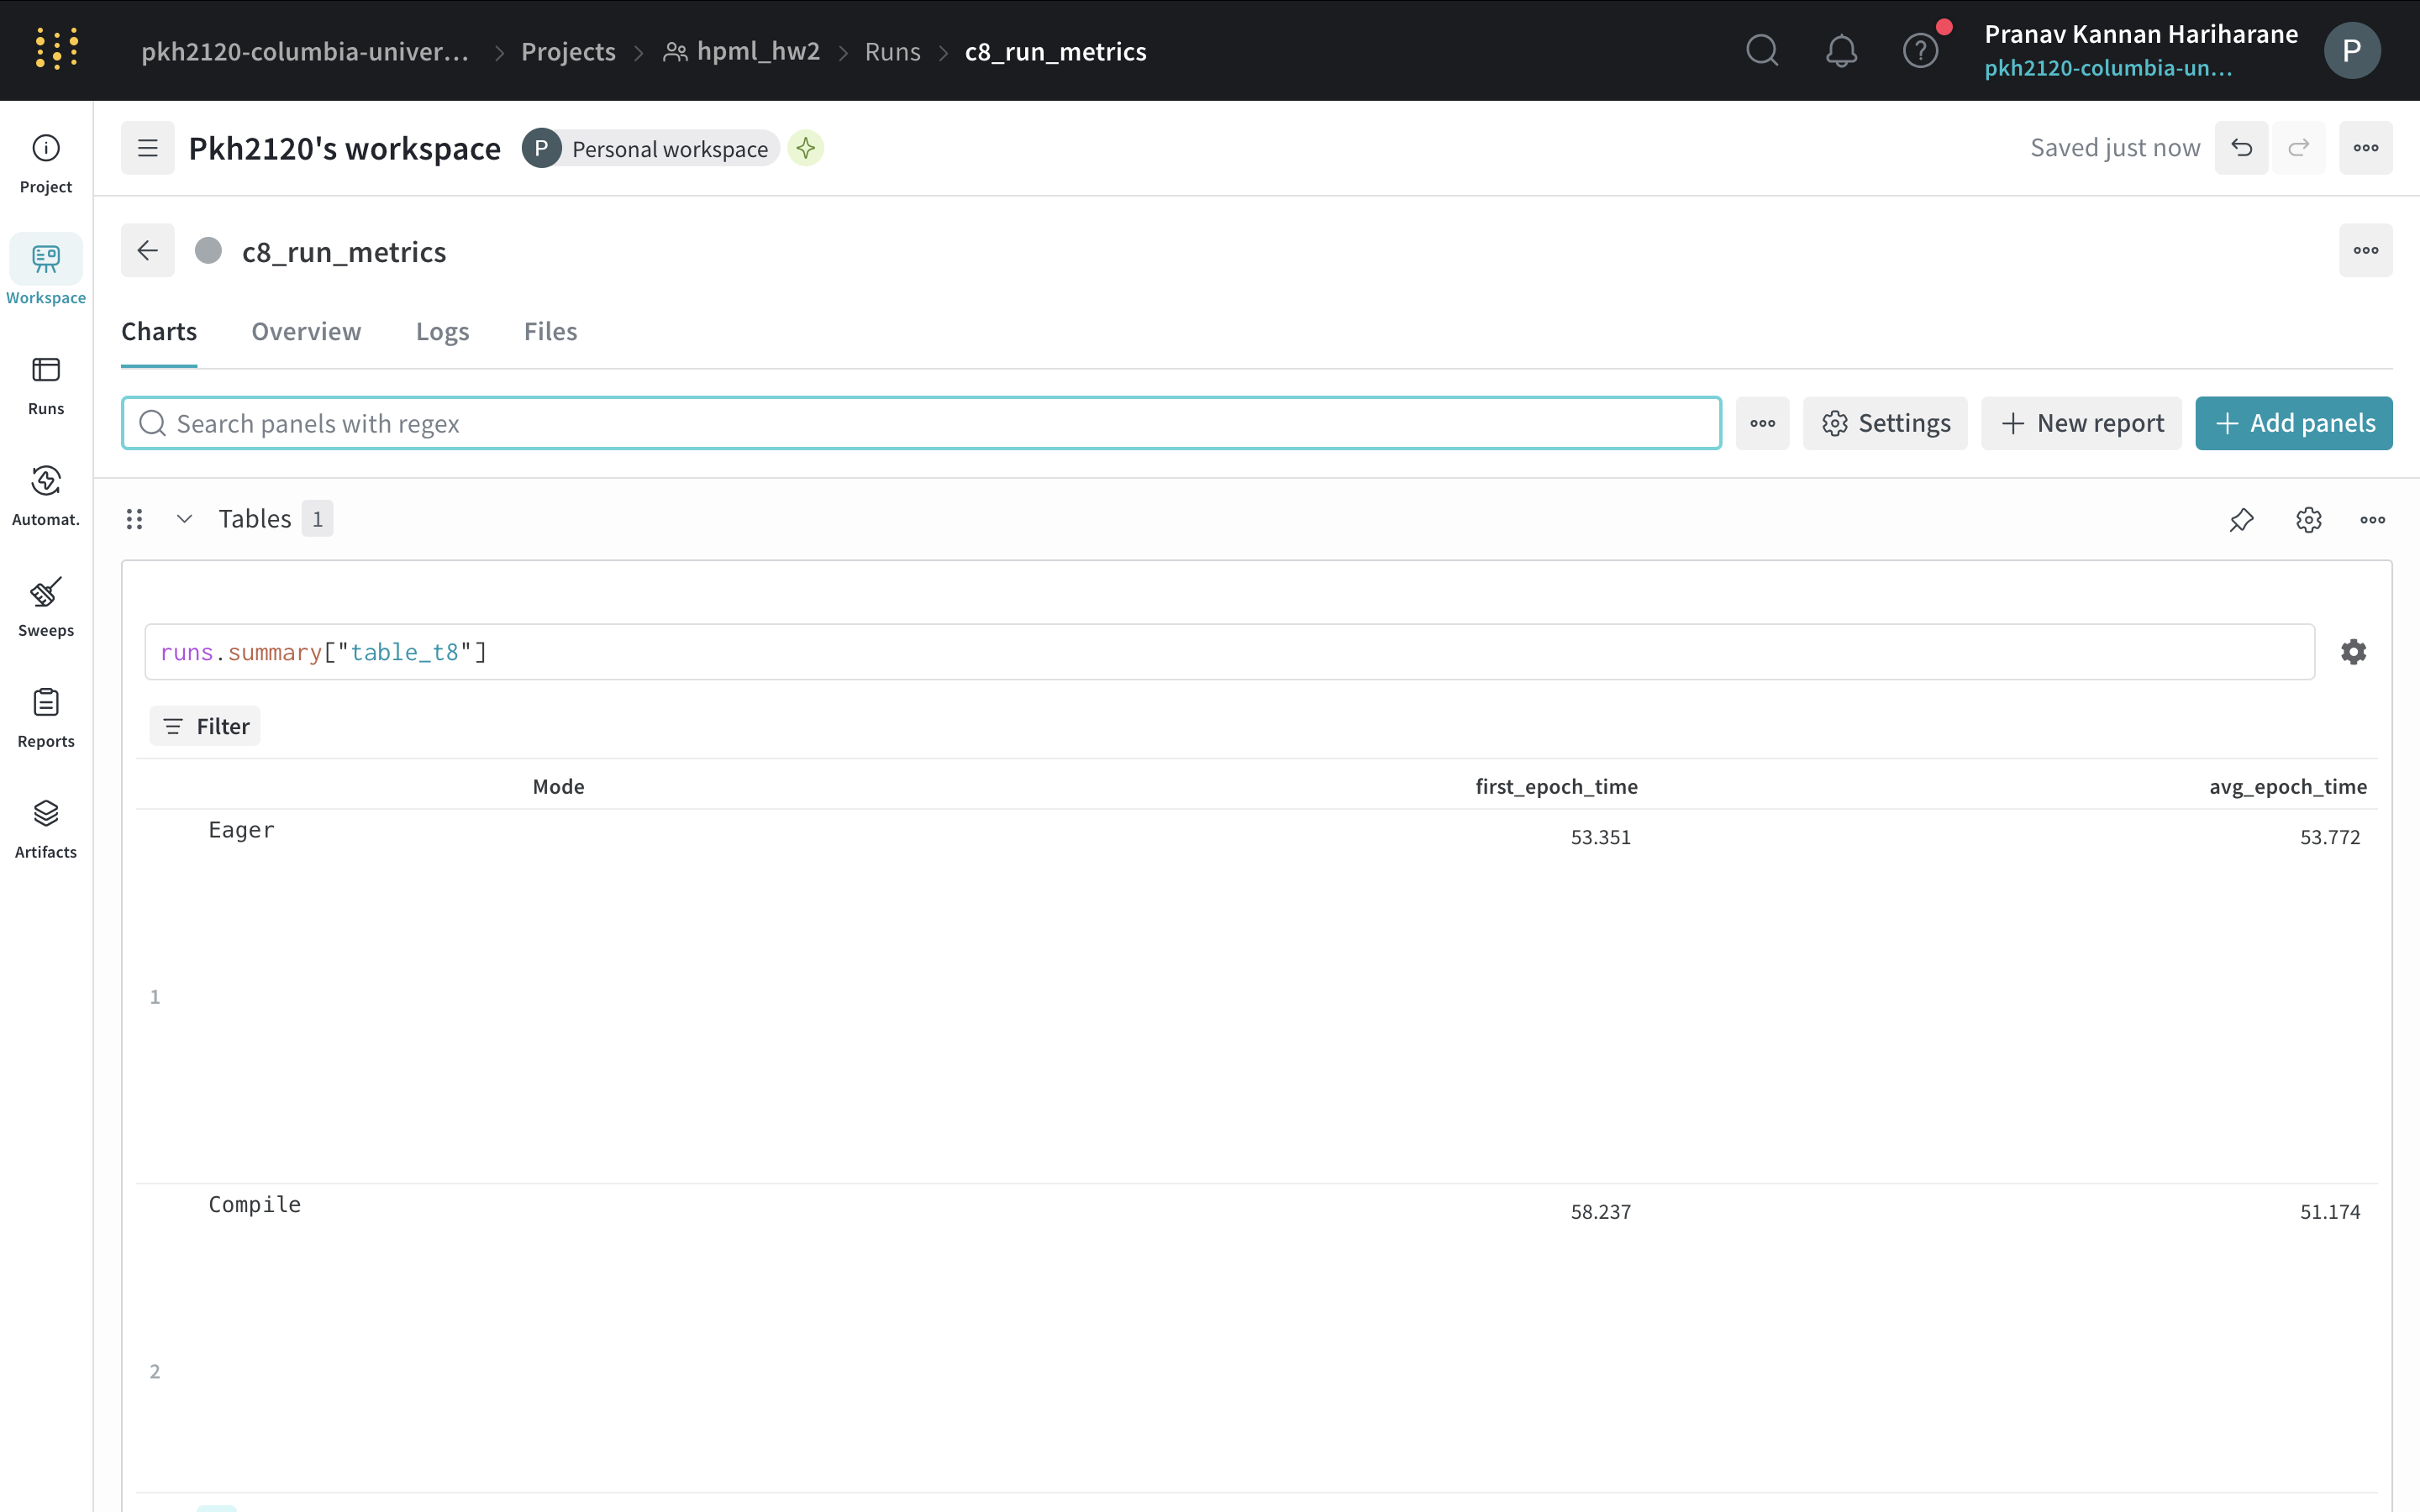
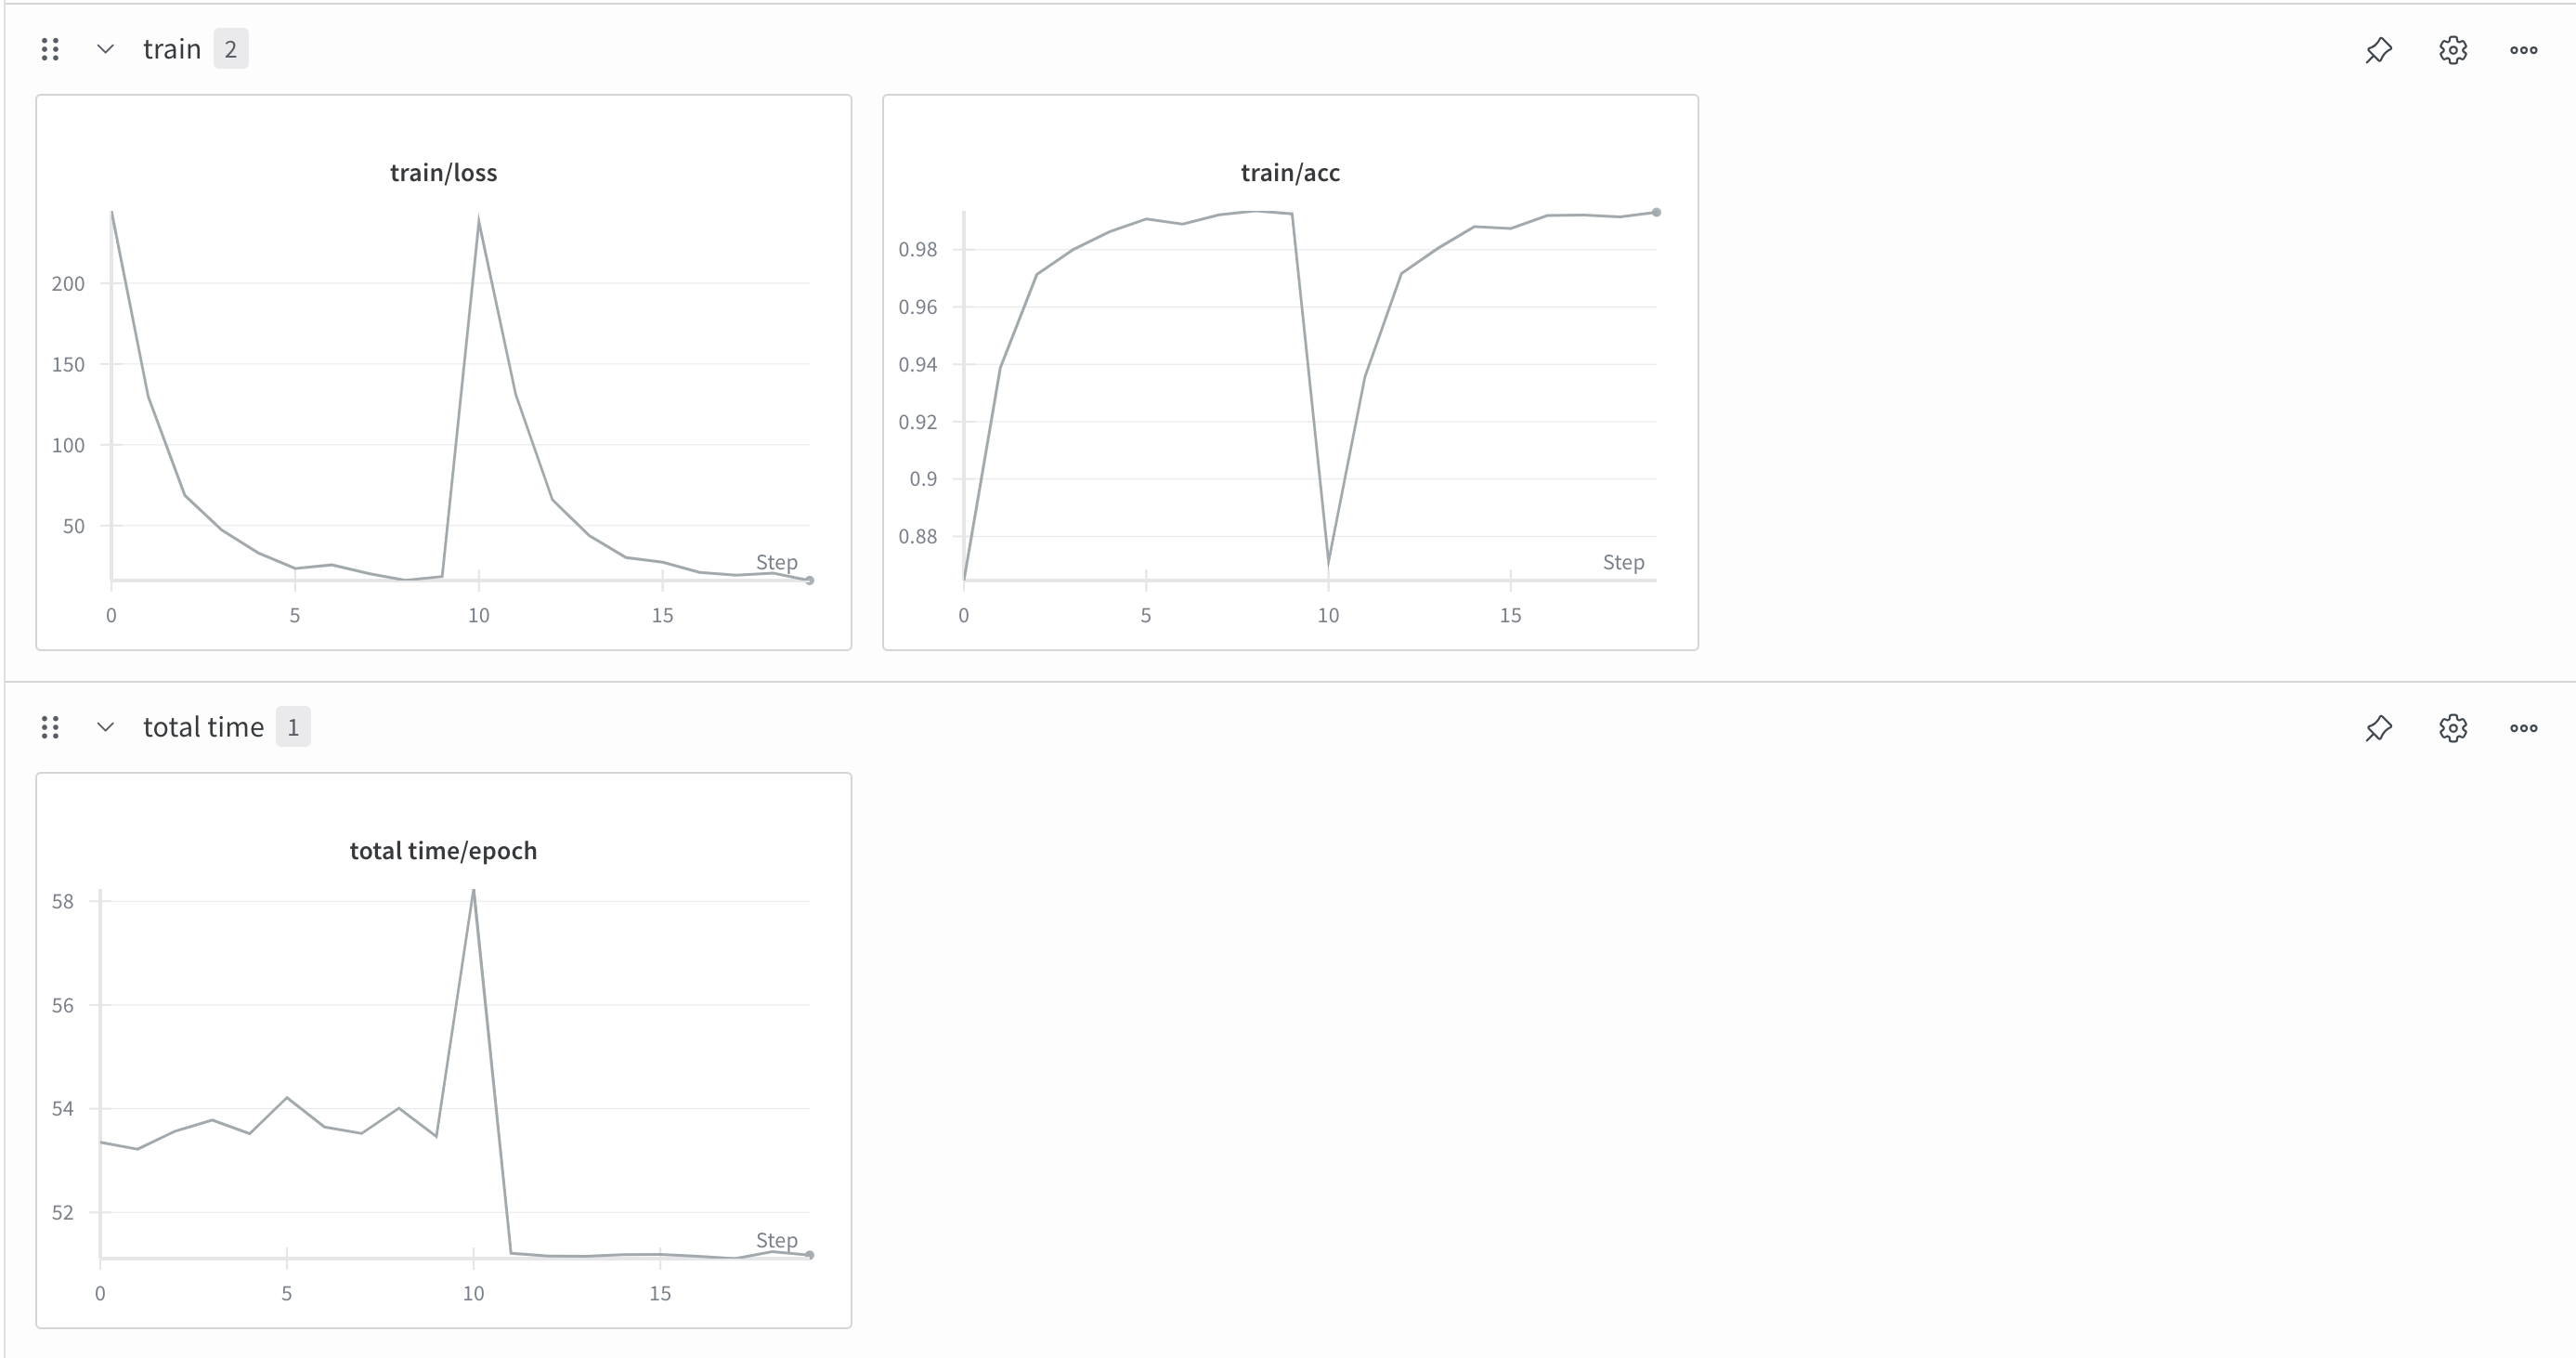
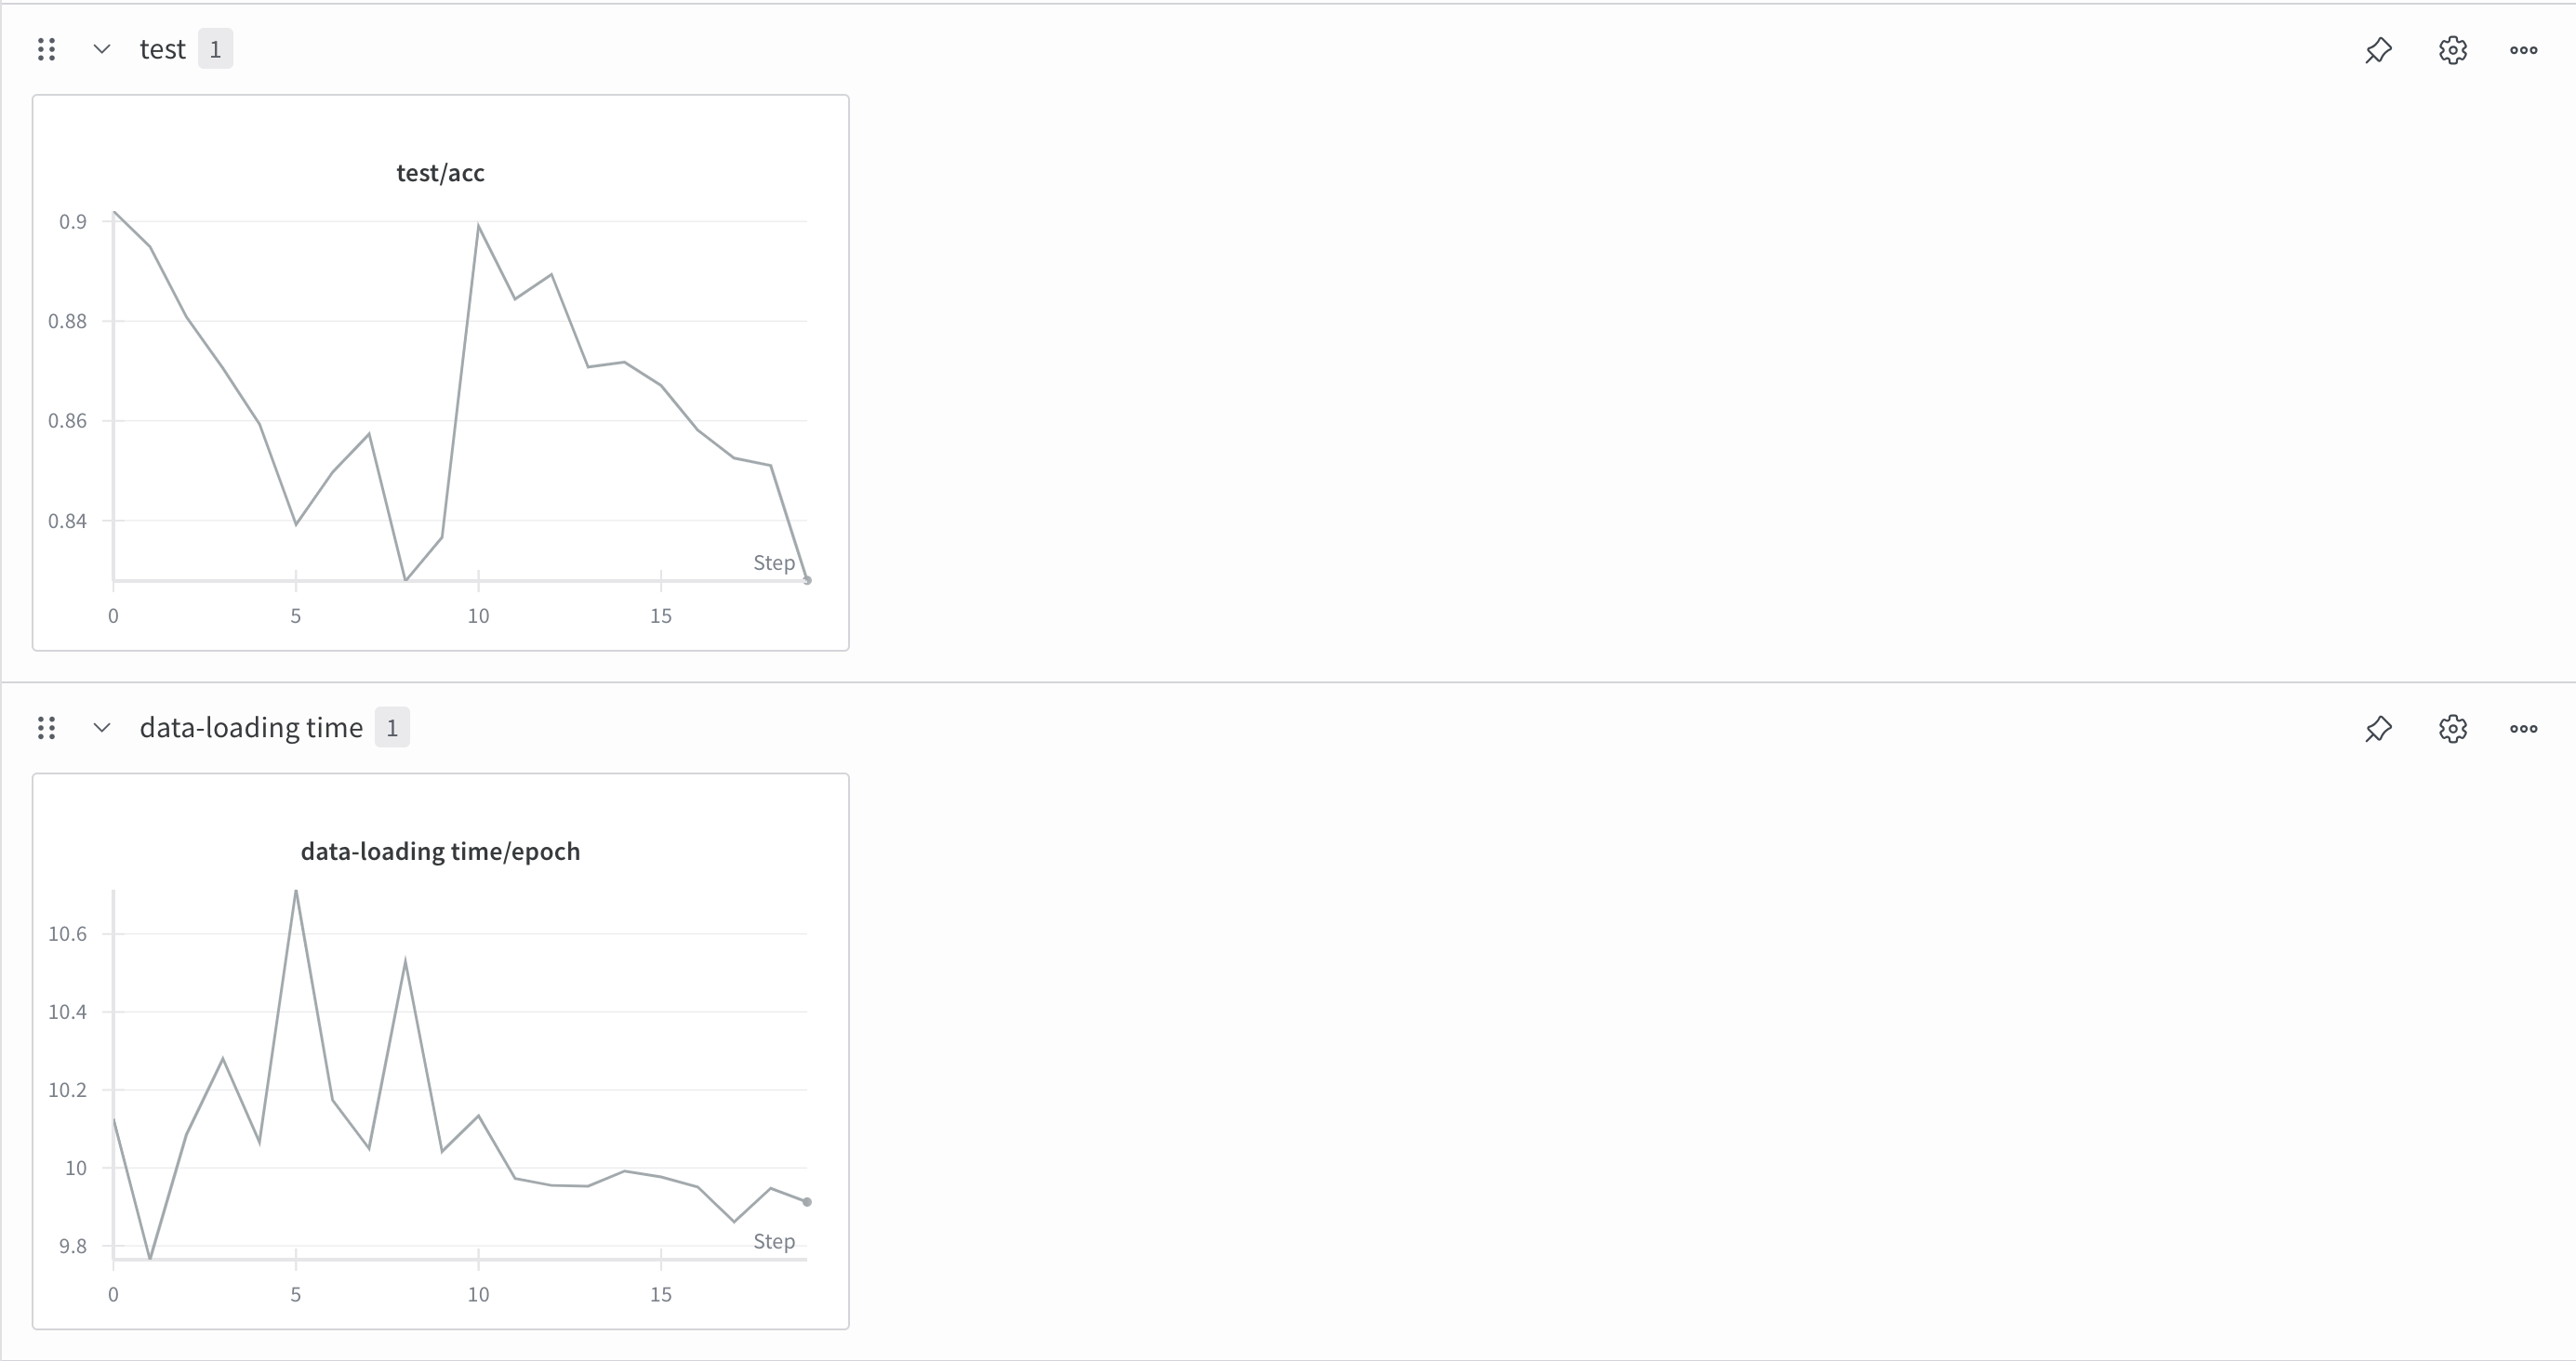
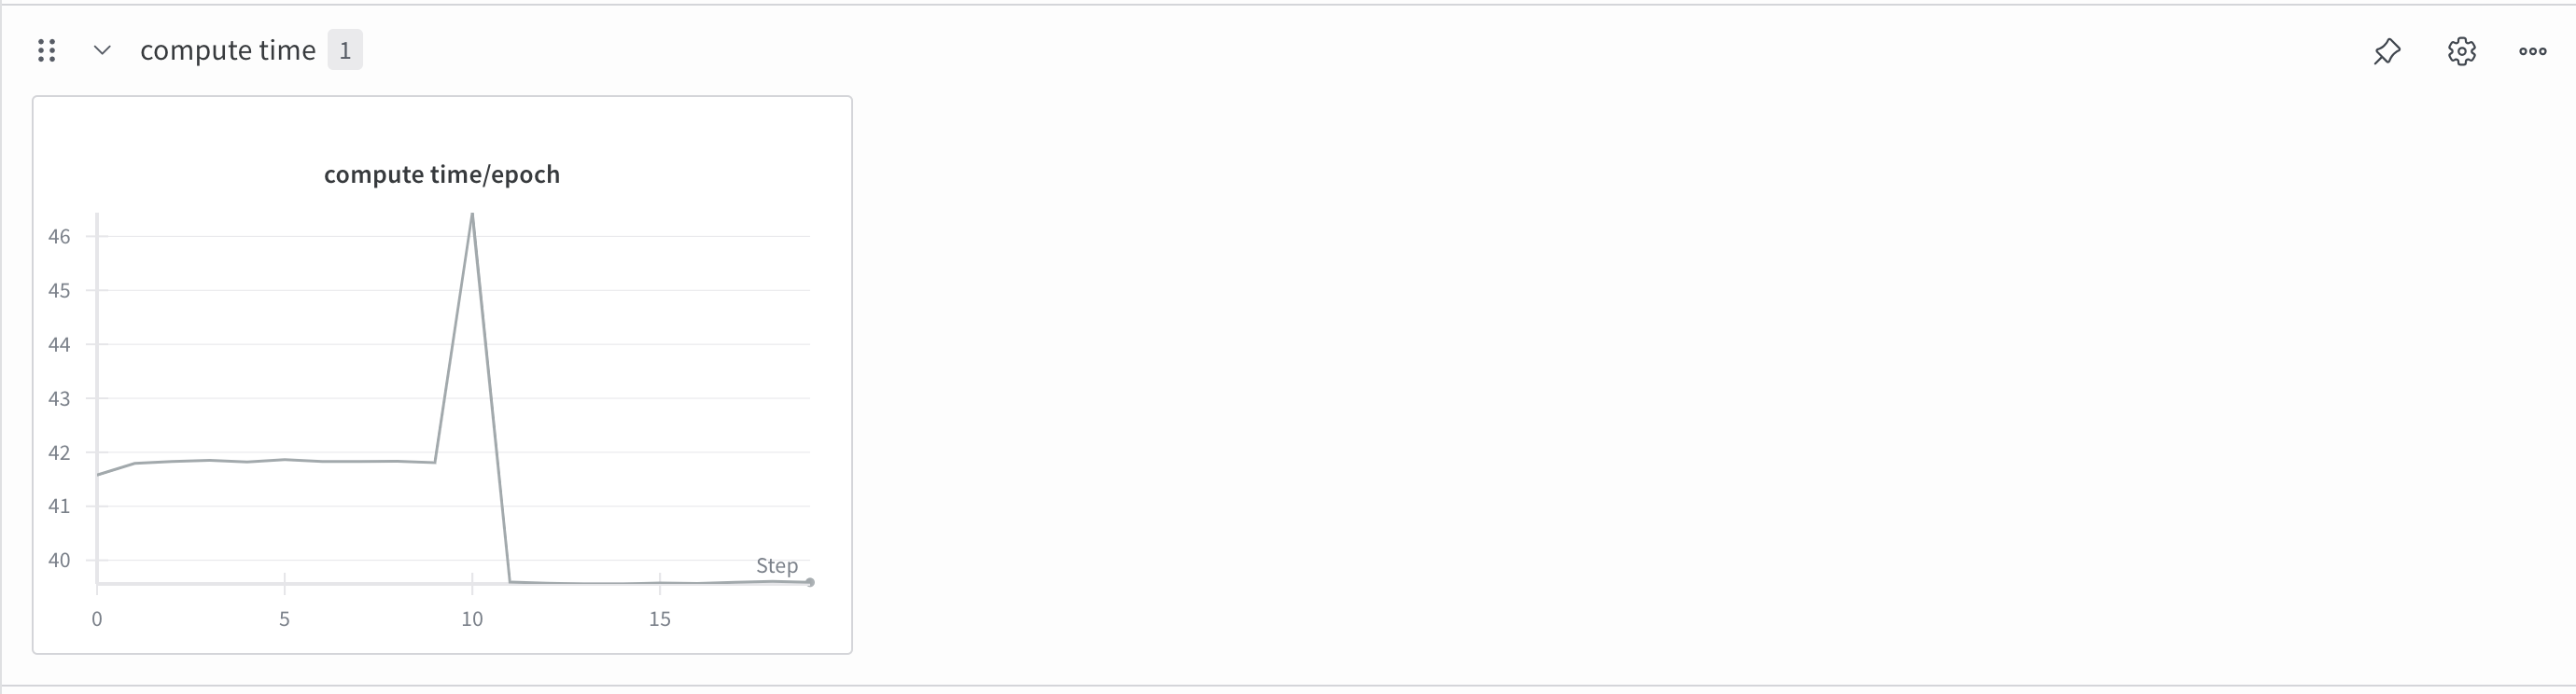

In [53]:
# Short Answer Questions
"""
Q1: The input dimension of DistilBERT’s embedding layer is 30522 since 30522 is the vocabulary size that DistilBERT accommodates.\n
Q2 The output dimension of the classifier head for IMDB is two since there's only two sentiment classes(Positive and Negative).\n
Q3: Number of trainable parameters = 66955010, Number of parameters with gradients after backward pass = 66955010, Code is below.
Q4. The parameter count doesn't change when switching from SGD to Adam. However, Adam does maintain additional tensors to store moment estimates for each parameter.\n
Q5: With torch.compile, in the first epoch, PyTorch captures and compiles the model's computation graph into optimized code. Since the later epochs just reuse the optimized code, they tend to run much faster.\n
"""

"\nQ1: The input dimension of DistilBERT’s embedding layer is 30522 since 30522 is the vocabulary size that DistilBERT accommodates.\n\nQ2 The output dimension of the classifier head for IMDB is two since there's only two sentiment classes(Positive and Negative).\n\nQ3: Number of trainable parameters = 66955010, Number of parameters with gradients after backward pass = 66955010, Code is below.\nQ4. The parameter count doesn't change when switching from SGD to Adam. However, Adam does maintain additional tensors to store moment estimates for each parameter.\n\nQ5: With torch.compile, in the first epoch, PyTorch captures and compiles the model's computation graph into optimized code. Since the later epochs just reuse the optimized code, they tend to run much faster.\n\n"

In [28]:
# Code for Q3
model = DistilBertForSequenceClassification.from_pretrained(configs['model_name'])
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: " + str(num_trainable))

# Dummy Data
inputs = {
    "input_ids": torch.randint(0, 30522, (2, 16)),
    "attention_mask": torch.ones((2, 16), dtype=torch.long),
    "labels": torch.tensor([0, 1])
}

outputs = model(**inputs)
loss = outputs.loss
loss.backward()

num_with_grads = sum(p.numel() for p in model.parameters() if p.grad is not None)
print(f"Parameters with gradients after backward pass: " + str(num_with_grads))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 66955010
Parameters with gradients after backward pass: 66955010


# W & B Link: https://wandb.ai/pkh2120-columbia-university/hpml_hw2?nw=nwuserpkh2120
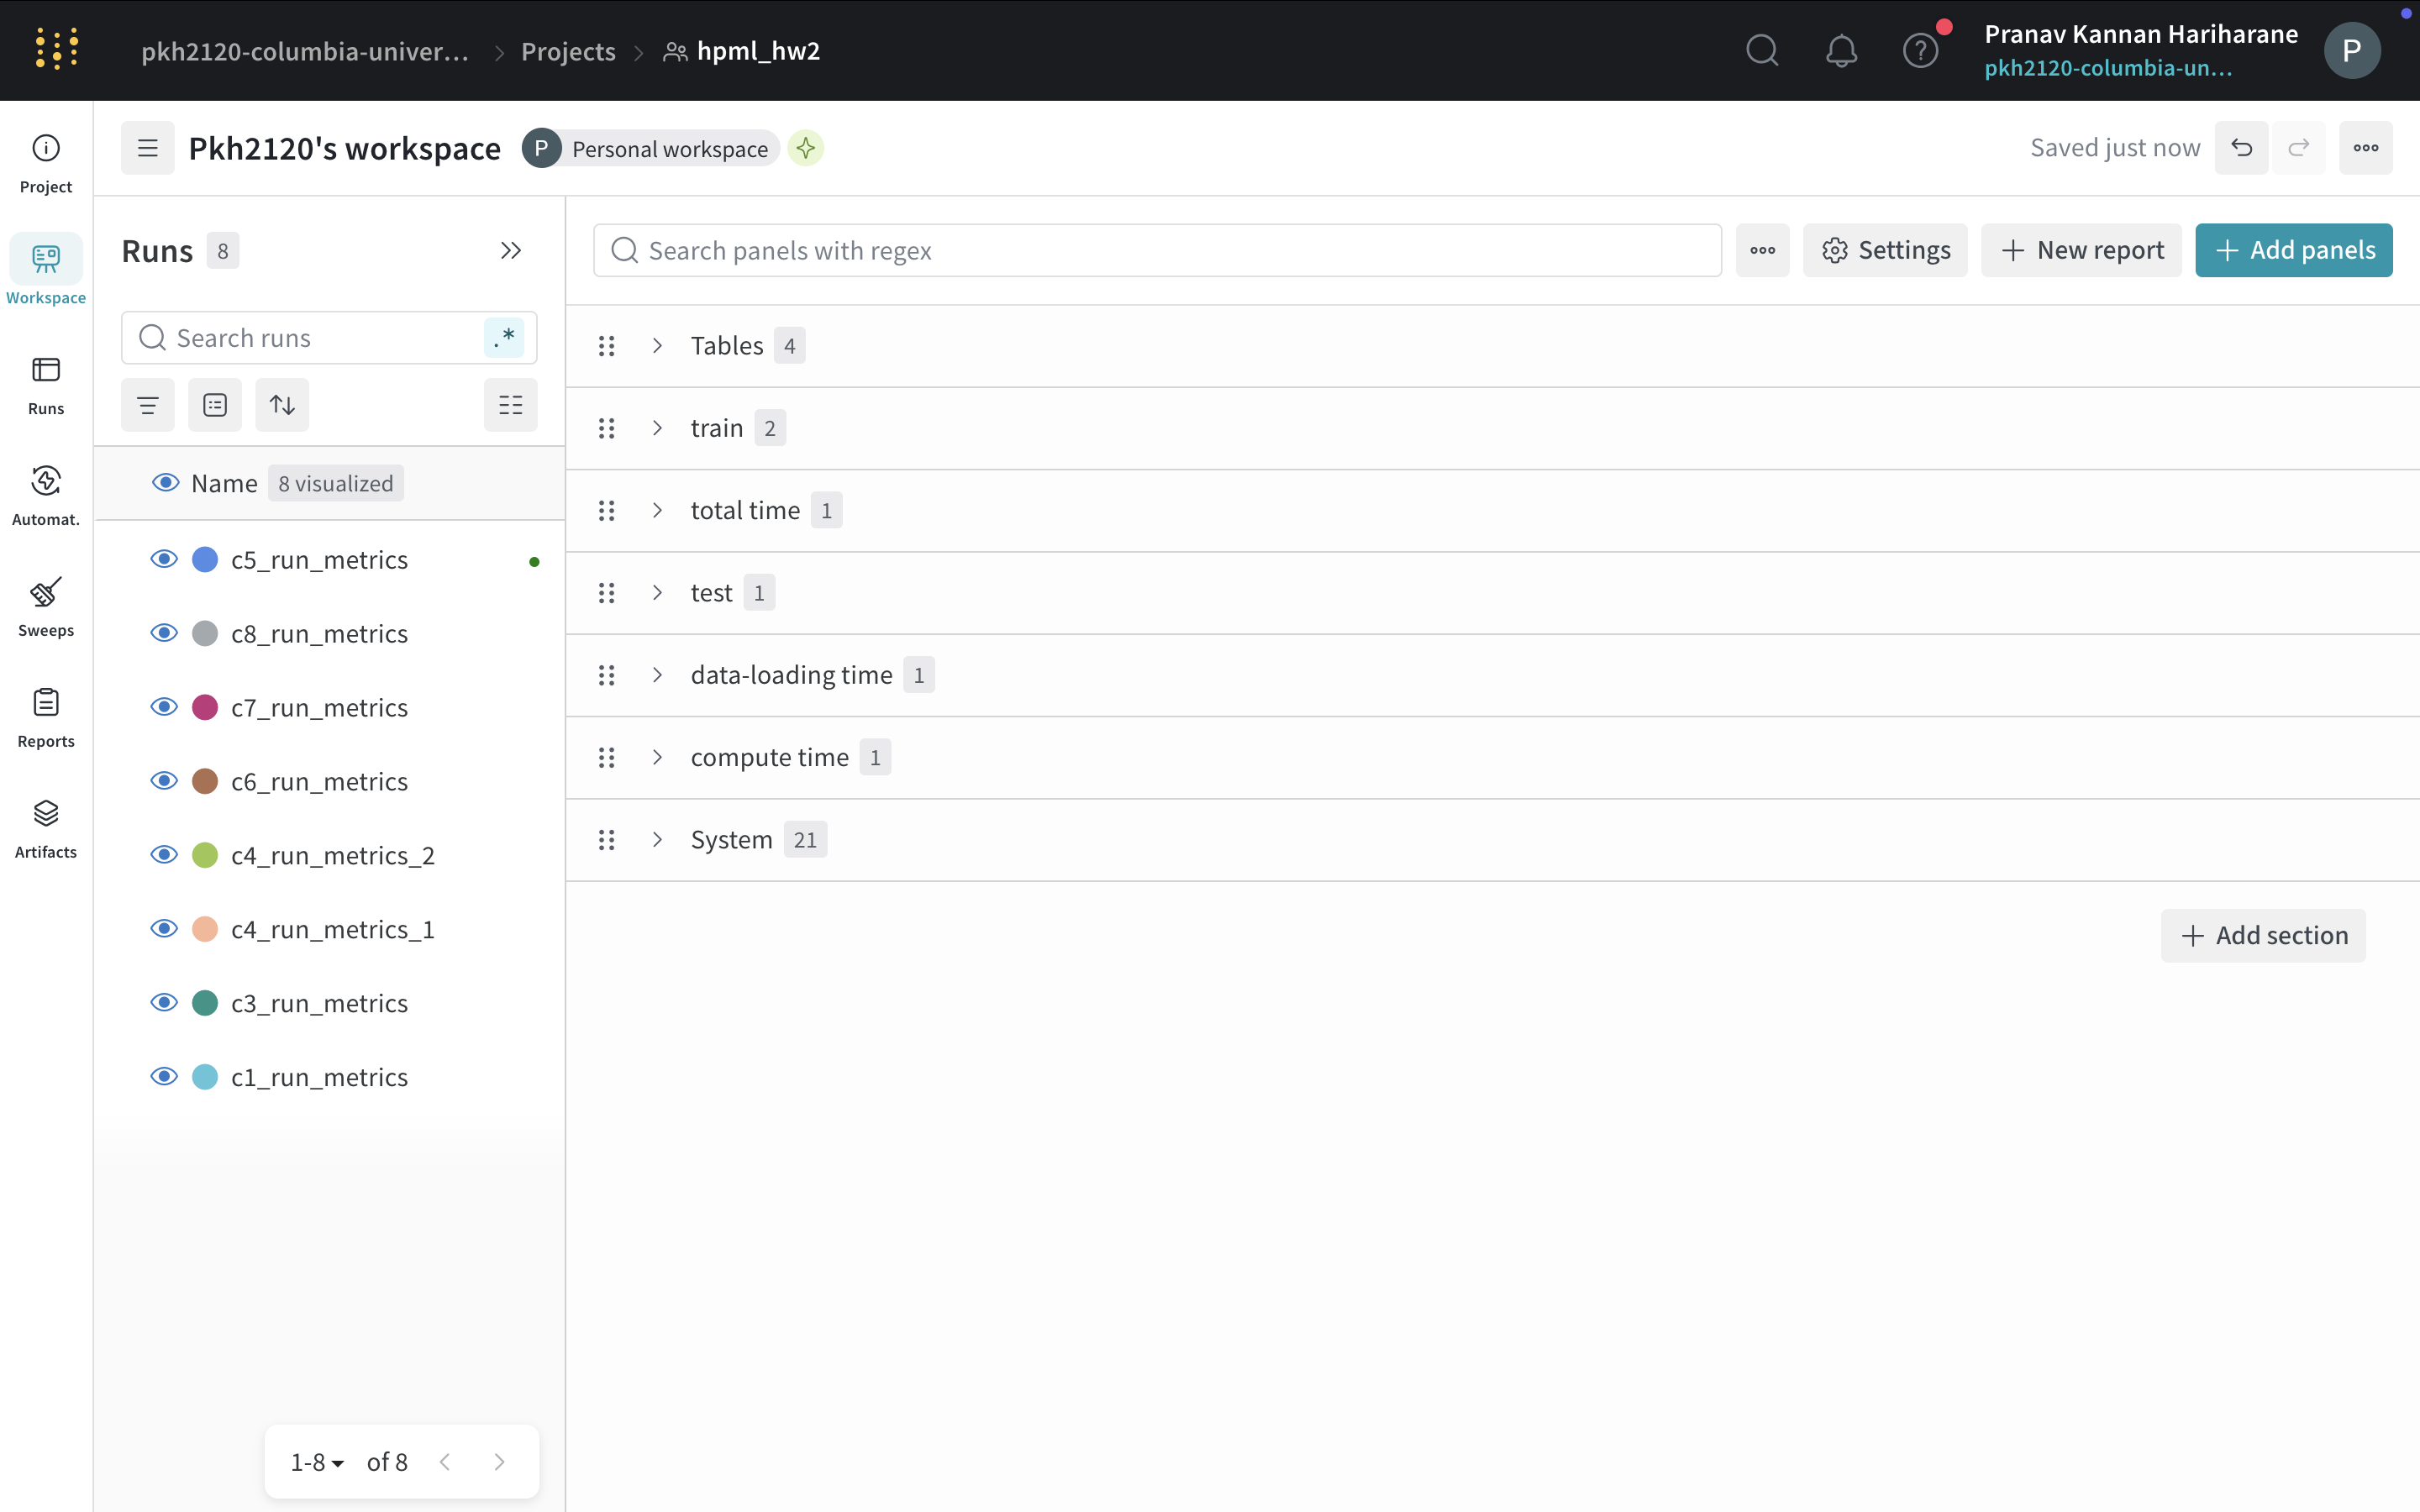